# Outcomes after Thoracic Surgery for Patients with Lung Cancer
## Capstone 2

## Import packages and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.stats import pearsonr
import re
import seaborn as sns
from IPython.display import display, HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import (XGBClassifier, plot_importance, DMatrix)
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import xgboost
from sklearn.neighbors import KNeighborsClassifier



In [3]:
thoracic_df = pd.read_csv('./thoracicsurgery.txt', sep=",", header=None)
#thoracic_df.columns = ['DGN', 'PRE4', 'PRE5', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14,' 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'AGE', 'Risk1Y']

thoracic_df.columns = ['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea', 'Cough', 
                       'Weakness', 'Tumor_size', 'T2DM', 'MI', 'PAD', 'Smoking', 'Asthma', 'Age', 'Risk1Y']

In [4]:
thoracic_df.head(15)

DGN   FVC  FEV1 Zubrod Pain Haemoptysis Dyspnea Cough Weakness  \
0   DGN2  2.88  2.16   PRZ1    F           F       F     T        T   
1   DGN3  3.40  1.88   PRZ0    F           F       F     F        F   
2   DGN3  2.76  2.08   PRZ1    F           F       F     T        F   
3   DGN3  3.68  3.04   PRZ0    F           F       F     F        F   
4   DGN3  2.44  0.96   PRZ2    F           T       F     T        T   
5   DGN3  2.48  1.88   PRZ1    F           F       F     T        F   
6   DGN3  4.36  3.28   PRZ1    F           F       F     T        F   
7   DGN2  3.19  2.50   PRZ1    F           F       F     T        F   
8   DGN3  3.16  2.64   PRZ2    F           F       F     T        T   
9   DGN3  2.32  2.16   PRZ1    F           F       F     T        F   
10  DGN3  2.56  2.32   PRZ0    F           T       F     T        F   
11  DGN3  4.28  4.44   PRZ1    F           F       F     F        F   
12  DGN3  3.00  2.36   PRZ1    F           F       F     T        T   
13  DGN2  3.98  3.06   PRZ2    F           F       F     T        T   
14  DGN3  1.96  1.40   PRZ1    F           F       F     T        F   

   Tumor_size T2DM MI PAD Smoking Asthma  Age Risk1Y  
0        OC14    F  F   F       T      F   60      F  
1        OC12    F  F   F       T      F   51      F  
2        OC11    F  F   F       T      F   59      F  
3        OC11    F  F   F       F      F   54      F  
4        OC11    F  F   F       T      F   73      T  
5        OC11    F  F   F       F      F   51      F  
6        OC12    T  F   F       T      F   59      T  
7        OC11    F  F   T       T      F   66      T  
8        OC11    F  F   F       T      F   68      F  
9        OC11    F  F   F       T      F   54      F  
10       OC12    F  F   F       F      F   60      F  
11       OC12    F  F   F       T      F   58      F  
12       OC11    F  F   F       T      F   68      F  
13       OC14    F  F   F       T      F   80      T  
14       OC11    F  F   F       T      F   77      F

In [5]:
thoracic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 17 columns):
DGN            470 non-null object
FVC            470 non-null float64
FEV1           470 non-null float64
Zubrod         470 non-null object
Pain           470 non-null object
Haemoptysis    470 non-null object
Dyspnea        470 non-null object
Cough          470 non-null object
Weakness       470 non-null object
Tumor_size     470 non-null object
T2DM           470 non-null object
MI             470 non-null object
PAD            470 non-null object
Smoking        470 non-null object
Asthma         470 non-null object
Age            470 non-null int64
Risk1Y         470 non-null object
dtypes: float64(2), int64(1), object(14)
memory usage: 62.5+ KB


In [6]:
def recode(value):
    if isinstance(value, int) or isinstance(value, float):
        return value
    elif not isinstance(value, int) or not isinstance(value, float):
        if value == "F":
            return 0
            value.astype(int)
        elif value == "T":
            return 1
            value.astype(int)


        

thoracic_df['Pain'] = thoracic_df.Pain.apply(recode)
thoracic_df['Haemoptysis'] = thoracic_df.Haemoptysis.apply(recode)
thoracic_df['Dyspnea'] = thoracic_df.Dyspnea.apply(recode)
thoracic_df['Cough'] = thoracic_df.Cough.apply(recode)
thoracic_df['Weakness'] = thoracic_df.Weakness.apply(recode)
thoracic_df['T2DM'] = thoracic_df.T2DM.apply(recode)
thoracic_df['MI'] = thoracic_df.MI.apply(recode)
thoracic_df['PAD'] = thoracic_df.PAD.apply(recode)
thoracic_df['Smoking'] = thoracic_df.Smoking.apply(recode)
thoracic_df['Asthma'] = thoracic_df.Asthma.apply(recode)
thoracic_df['Risk1Y'] = thoracic_df.Risk1Y.apply(recode)

thoracic_df.head(15)

DGN   FVC  FEV1 Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0   DGN2  2.88  2.16   PRZ1     0            0        0      1         1   
1   DGN3  3.40  1.88   PRZ0     0            0        0      0         0   
2   DGN3  2.76  2.08   PRZ1     0            0        0      1         0   
3   DGN3  3.68  3.04   PRZ0     0            0        0      0         0   
4   DGN3  2.44  0.96   PRZ2     0            1        0      1         1   
5   DGN3  2.48  1.88   PRZ1     0            0        0      1         0   
6   DGN3  4.36  3.28   PRZ1     0            0        0      1         0   
7   DGN2  3.19  2.50   PRZ1     0            0        0      1         0   
8   DGN3  3.16  2.64   PRZ2     0            0        0      1         1   
9   DGN3  2.32  2.16   PRZ1     0            0        0      1         0   
10  DGN3  2.56  2.32   PRZ0     0            1        0      1         0   
11  DGN3  4.28  4.44   PRZ1     0            0        0      0         0   
12  DGN3  3.00  2.36   PRZ1     0            0        0      1         1   
13  DGN2  3.98  3.06   PRZ2     0            0        0      1         1   
14  DGN3  1.96  1.40   PRZ1     0            0        0      1         0   

   Tumor_size  T2DM  MI  PAD  Smoking  Asthma  Age  Risk1Y  
0        OC14     0   0    0        1       0   60       0  
1        OC12     0   0    0        1       0   51       0  
2        OC11     0   0    0        1       0   59       0  
3        OC11     0   0    0        0       0   54       0  
4        OC11     0   0    0        1       0   73       1  
5        OC11     0   0    0        0       0   51       0  
6        OC12     1   0    0        1       0   59       1  
7        OC11     0   0    1        1       0   66       1  
8        OC11     0   0    0        1       0   68       0  
9        OC11     0   0    0        1       0   54       0  
10       OC12     0   0    0        0       0   60       0  
11       OC12     0   0    0        1       0   58       0  
12       OC11     0   0    0        1       0   68       0  
13       OC14     0   0    0        1       0   80       1  
14       OC11     0   0    0        1       0   77       0

In [7]:
thoracic_df['DGN'].replace(regex=True, inplace=True, to_replace=r'\D',value=r'')
thoracic_df['Zubrod'].replace(regex=True, inplace=True, to_replace=r'\D',value=r'')
thoracic_df['Tumor_size'].replace(regex=True, inplace=True, to_replace=r'\D',value=r'')

thoracic_df.head(15)

DGN   FVC  FEV1 Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0    2  2.88  2.16      1     0            0        0      1         1   
1    3  3.40  1.88      0     0            0        0      0         0   
2    3  2.76  2.08      1     0            0        0      1         0   
3    3  3.68  3.04      0     0            0        0      0         0   
4    3  2.44  0.96      2     0            1        0      1         1   
5    3  2.48  1.88      1     0            0        0      1         0   
6    3  4.36  3.28      1     0            0        0      1         0   
7    2  3.19  2.50      1     0            0        0      1         0   
8    3  3.16  2.64      2     0            0        0      1         1   
9    3  2.32  2.16      1     0            0        0      1         0   
10   3  2.56  2.32      0     0            1        0      1         0   
11   3  4.28  4.44      1     0            0        0      0         0   
12   3  3.00  2.36      1     0            0        0      1         1   
13   2  3.98  3.06      2     0            0        0      1         1   
14   3  1.96  1.40      1     0            0        0      1         0   

   Tumor_size  T2DM  MI  PAD  Smoking  Asthma  Age  Risk1Y  
0          14     0   0    0        1       0   60       0  
1          12     0   0    0        1       0   51       0  
2          11     0   0    0        1       0   59       0  
3          11     0   0    0        0       0   54       0  
4          11     0   0    0        1       0   73       1  
5          11     0   0    0        0       0   51       0  
6          12     1   0    0        1       0   59       1  
7          11     0   0    1        1       0   66       1  
8          11     0   0    0        1       0   68       0  
9          11     0   0    0        1       0   54       0  
10         12     0   0    0        0       0   60       0  
11         12     0   0    0        1       0   58       0  
12         11     0   0    0        1       0   68       0  
13         14     0   0    0        1       0   80       1  
14         11     0   0    0        1       0   77       0


1. DGN: Diagnosis - specific combination of ICD-10 codes for primary and secondary as well multiple tumours if any (DGN3,DGN2,DGN4,DGN6,DGN5,DGN8,DGN1) 
2. PRE4: Forced vital capacity - FVC (numeric) 
3. PRE5: Volume that has been exhaled at the end of the first second of forced expiration - FEV1 (numeric) 
4. PRE6: Performance status - Zubrod scale (PRZ2,PRZ1,PRZ0) 
5. PRE7: Pain before surgery (T,F) 
6. PRE8: Haemoptysis before surgery (T,F) 
7. PRE9: Dyspnoea before surgery (T,F) 
8. PRE10: Cough before surgery (T,F) 
9. PRE11: Weakness before surgery (T,F) 
10. PRE14: T in clinical TNM - size of the original tumour, from OC11 (smallest) to OC14 (largest) (OC11,OC14,OC12,OC13) 
11. PRE17: Type 2 DM - diabetes mellitus (T,F) 
12. PRE19: MI up to 6 months (T,F) 
13. PRE25: PAD - peripheral arterial diseases (T,F) 
14. PRE30: Smoking (T,F) 
15. PRE32: Asthma (T,F) 
16. AGE: Age at surgery (numeric) 
17. Risk1Y: 1 year survival period - (T)rue value if died (T,F) 


In [8]:
thoracic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 17 columns):
DGN            470 non-null object
FVC            470 non-null float64
FEV1           470 non-null float64
Zubrod         470 non-null object
Pain           470 non-null int64
Haemoptysis    470 non-null int64
Dyspnea        470 non-null int64
Cough          470 non-null int64
Weakness       470 non-null int64
Tumor_size     470 non-null object
T2DM           470 non-null int64
MI             470 non-null int64
PAD            470 non-null int64
Smoking        470 non-null int64
Asthma         470 non-null int64
Age            470 non-null int64
Risk1Y         470 non-null int64
dtypes: float64(2), int64(12), object(3)
memory usage: 62.5+ KB


In [9]:
thoracic_df['DGN'] = thoracic_df['DGN'].astype(int)
thoracic_df['Zubrod'] = thoracic_df['Zubrod'].astype(int)
thoracic_df['Cough'] = thoracic_df['Cough'].astype(int)
thoracic_df['Tumor_size'] = thoracic_df['Tumor_size'].astype(int)
thoracic_df['Age'] = thoracic_df['Age'].astype(float)

thoracic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 17 columns):
DGN            470 non-null int64
FVC            470 non-null float64
FEV1           470 non-null float64
Zubrod         470 non-null int64
Pain           470 non-null int64
Haemoptysis    470 non-null int64
Dyspnea        470 non-null int64
Cough          470 non-null int64
Weakness       470 non-null int64
Tumor_size     470 non-null int64
T2DM           470 non-null int64
MI             470 non-null int64
PAD            470 non-null int64
Smoking        470 non-null int64
Asthma         470 non-null int64
Age            470 non-null float64
Risk1Y         470 non-null int64
dtypes: float64(3), int64(14)
memory usage: 62.5 KB


In [10]:
thoracic_df.head(15)

DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0     2  2.88  2.16       1     0            0        0      1         1   
1     3  3.40  1.88       0     0            0        0      0         0   
2     3  2.76  2.08       1     0            0        0      1         0   
3     3  3.68  3.04       0     0            0        0      0         0   
4     3  2.44  0.96       2     0            1        0      1         1   
5     3  2.48  1.88       1     0            0        0      1         0   
6     3  4.36  3.28       1     0            0        0      1         0   
7     2  3.19  2.50       1     0            0        0      1         0   
8     3  3.16  2.64       2     0            0        0      1         1   
9     3  2.32  2.16       1     0            0        0      1         0   
10    3  2.56  2.32       0     0            1        0      1         0   
11    3  4.28  4.44       1     0            0        0      0         0   
12    3  3.00  2.36       1     0            0        0      1         1   
13    2  3.98  3.06       2     0            0        0      1         1   
14    3  1.96  1.40       1     0            0        0      1         0   

    Tumor_size  T2DM  MI  PAD  Smoking  Asthma   Age  Risk1Y  
0           14     0   0    0        1       0  60.0       0  
1           12     0   0    0        1       0  51.0       0  
2           11     0   0    0        1       0  59.0       0  
3           11     0   0    0        0       0  54.0       0  
4           11     0   0    0        1       0  73.0       1  
5           11     0   0    0        0       0  51.0       0  
6           12     1   0    0        1       0  59.0       1  
7           11     0   0    1        1       0  66.0       1  
8           11     0   0    0        1       0  68.0       0  
9           11     0   0    0        1       0  54.0       0  
10          12     0   0    0        0       0  60.0       0  
11          12     0   0    0        1       0  58.0       0  
12          11     0   0    0        1       0  68.0       0  
13          14     0   0    0        1       0  80.0       1  
14          11     0   0    0        1       0  77.0       0

## Examine data

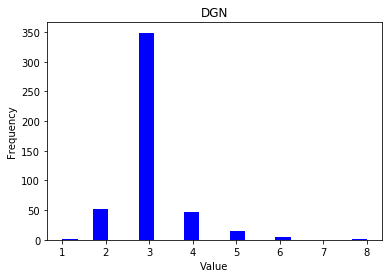

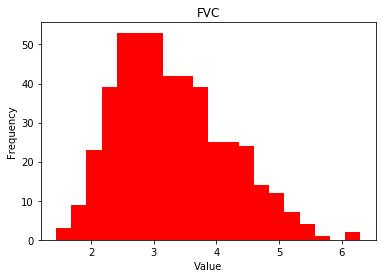

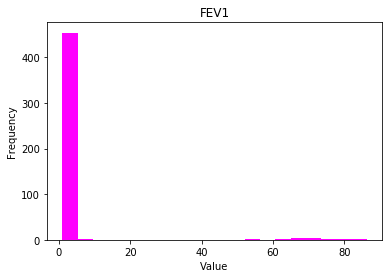

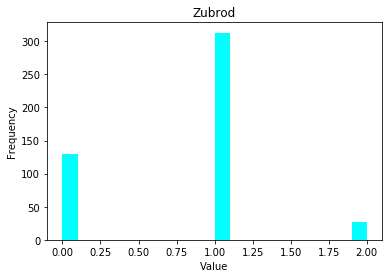

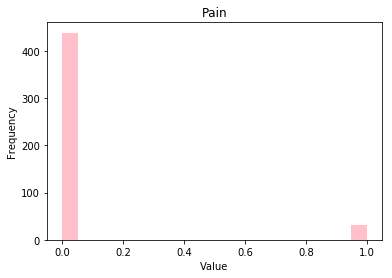

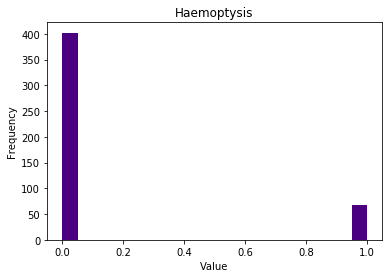

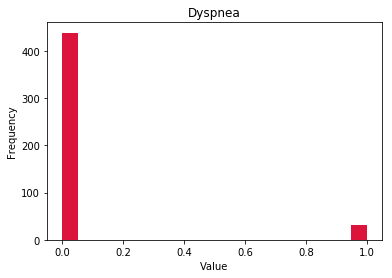

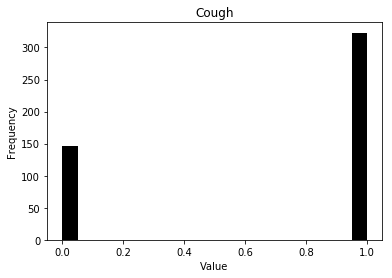

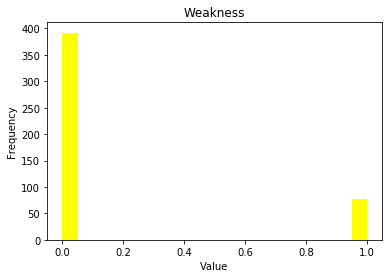

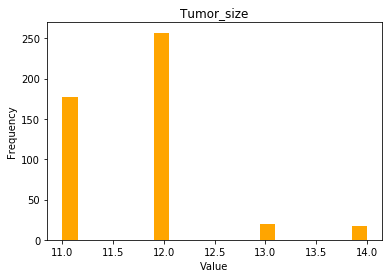

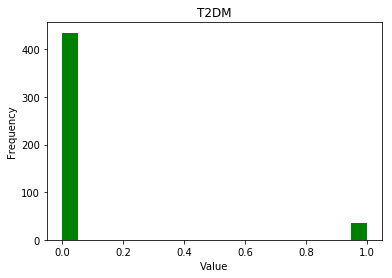

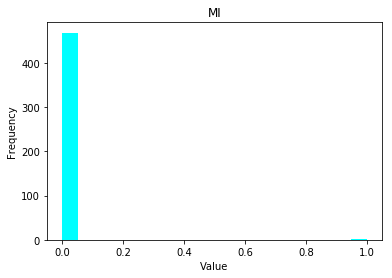

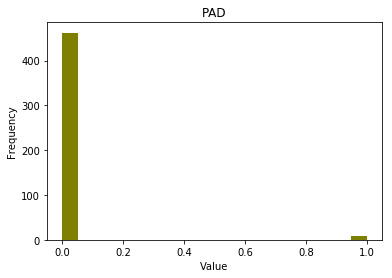

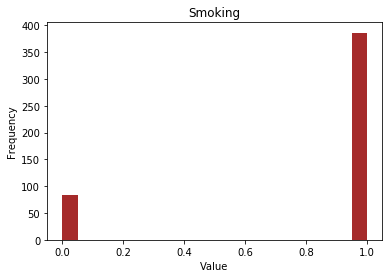

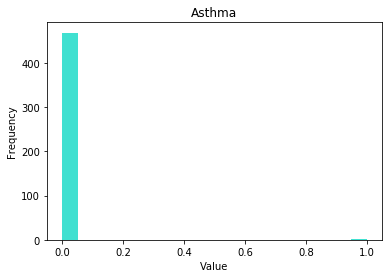

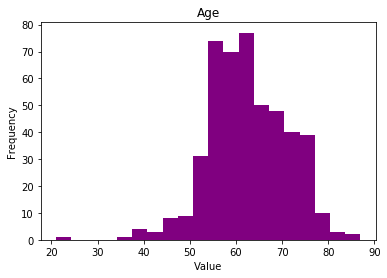

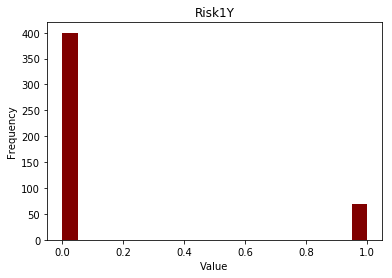

In [11]:
thoracic_df['DGN'].plot(kind='hist', bins=20, color='blue')
plt.xlabel('Value')
plt.title('DGN')
plt.show()

thoracic_df['FVC'].plot(kind='hist', bins=20, color='red')
plt.xlabel('Value')
plt.title('FVC')
plt.show()

thoracic_df['FEV1'].plot(kind='hist', bins=20, color='magenta')
plt.xlabel('Value')
plt.title('FEV1')
plt.show()

thoracic_df['Zubrod'].plot(kind='hist', bins=20, color='aqua')
plt.xlabel('Value')
plt.title('Zubrod')
plt.show()

thoracic_df['Pain'].plot(kind='hist', bins=20, color='pink')
plt.xlabel('Value')
plt.title('Pain')
plt.show()

thoracic_df['Haemoptysis'].plot(kind='hist', bins=20, color='indigo')
plt.xlabel('Value')
plt.title('Haemoptysis')
plt.show()

thoracic_df['Dyspnea'].plot(kind='hist', bins=20, color='crimson')
plt.xlabel('Value')
plt.title('Dyspnea')
plt.show()

thoracic_df['Cough'].plot(kind='hist', bins=20, color='black')
plt.xlabel('Value')
plt.title('Cough')
plt.show()

thoracic_df['Weakness'].plot(kind='hist', bins=20, color='yellow')
plt.xlabel('Value')
plt.title('Weakness')
plt.show()

thoracic_df['Tumor_size'].plot(kind='hist', bins=20, color='orange')
plt.xlabel('Value')
plt.title('Tumor_size')
plt.show()

thoracic_df['T2DM'].plot(kind='hist', bins=20, color='green')
plt.xlabel('Value')
plt.title('T2DM')
plt.show()

thoracic_df['MI'].plot(kind='hist', bins=20, color='cyan')
plt.xlabel('Value')
plt.title('MI')
plt.show()

thoracic_df['PAD'].plot(kind='hist', bins=20, color='olive')
plt.xlabel('Value')
plt.title('PAD')
plt.show()

thoracic_df['Smoking'].plot(kind='hist', bins=20, color='brown')
plt.xlabel('Value')
plt.title('Smoking')
plt.show()

thoracic_df['Asthma'].plot(kind='hist', bins=20, color='turquoise')
plt.xlabel('Value')
plt.title('Asthma')
plt.show()

thoracic_df['Age'].plot(kind='hist', bins=20, color='purple')
plt.xlabel('Value')
plt.title('Age')
plt.show()

thoracic_df['Risk1Y'].plot(kind='hist', bins=20, color='maroon')
plt.xlabel('Value')
plt.title('Risk1Y')
plt.show()

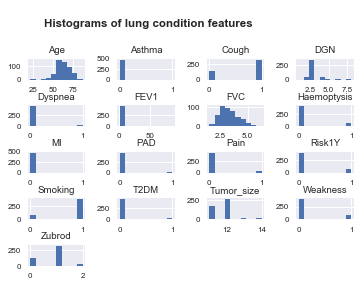

In [12]:
sns.set(font_scale=0.8)
thoracic_df.hist()
plt.suptitle('\nHistograms of lung condition features', fontweight='bold')
plt.tight_layout(rect=[0.15, 0, 1, 2.5], h_pad=6)
plt.subplots_adjust(top=0.80)
plt.show()

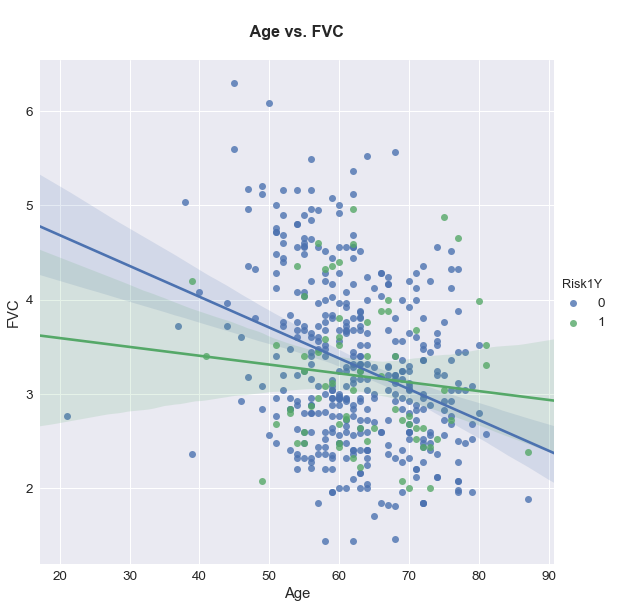

In [13]:
sns.set(font_scale=1.35)
sns.lmplot(x='Age', y='FVC', data=thoracic_df, hue='Risk1Y',size=8)
plt.title('\n Age vs. FVC \n', fontweight='bold')
plt.show()

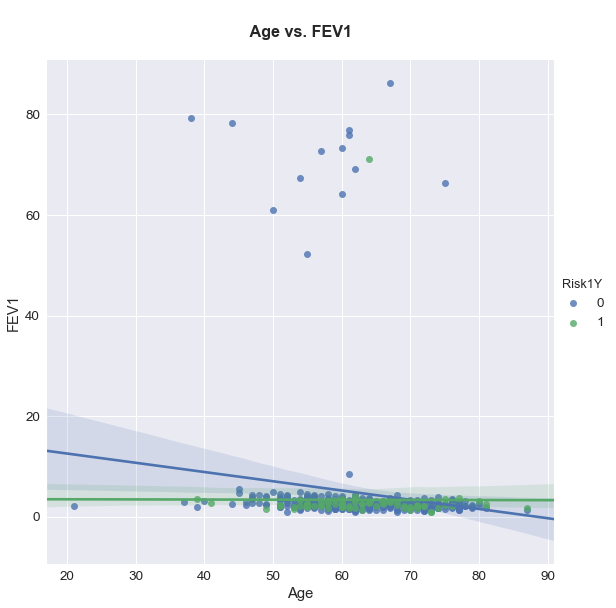

In [14]:
sns.set(font_scale=1.35)
axy = sns.lmplot(x='Age', y='FEV1', data=thoracic_df, hue='Risk1Y',size=8)
plt.title('\n Age vs. FEV1 \n', fontweight='bold')
#axy.set(ylim=(0, 10)) 
plt.show()

## Consider outliers

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('FEV1 ~ Age',thoracic_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   FEV1   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.372
Date:                Mon, 16 Jul 2018   Prob (F-statistic):             0.0119
Time:                        12:27:13   Log-Likelihood:                -1821.9
No. Observations:                 470   AIC:                             3648.
Df Residuals:                     468   BIC:                             3656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3644      3.918      3.666      0.0

Text(0.5,1,'Relationship between Original and Predicted FEV1 values')

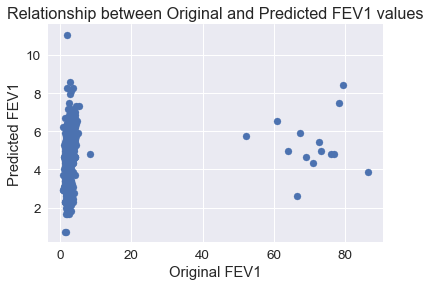

In [16]:
plt.scatter(thoracic_df.FEV1, m.fittedvalues)
plt.xlabel("Original FEV1")
plt.ylabel("Predicted FEV1")
plt.title("Relationship between Original and Predicted FEV1 values")

In [17]:
from sklearn.linear_model import LinearRegression
Xlr = thoracic_df.drop('FEV1', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
lm.fit(Xlr, thoracic_df.FEV1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0.5,1,'Relationship between Original and Predicted FEV1: sklearn')

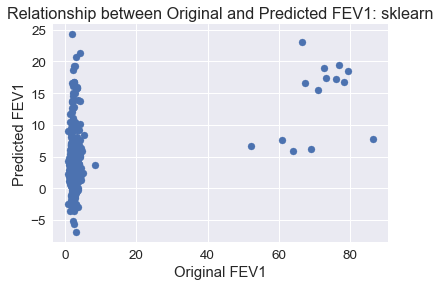

In [19]:
plt.scatter(thoracic_df.FEV1, lm.predict(Xlr))
plt.xlabel("Original FEV1")
plt.ylabel("Predicted FEV1")
plt.title("Relationship between Original and Predicted FEV1: sklearn")

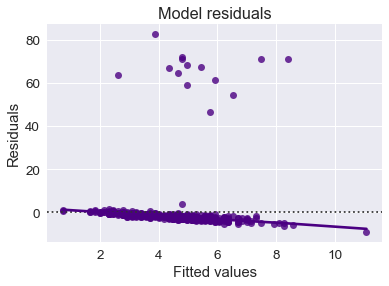

In [20]:
sns.residplot(m.fittedvalues, m.resid, lowess=True, color="indigo")
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Model residuals')
plt.show()

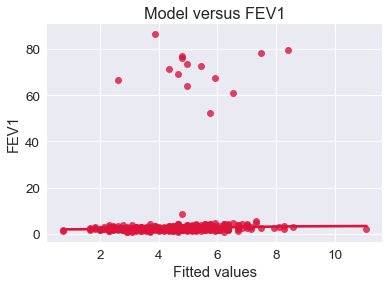

In [21]:
sns.regplot(m.fittedvalues, thoracic_df.FEV1, lowess=True, color='crimson')
plt.xlabel('Fitted values')
plt.title('Model versus FEV1')
plt.show()

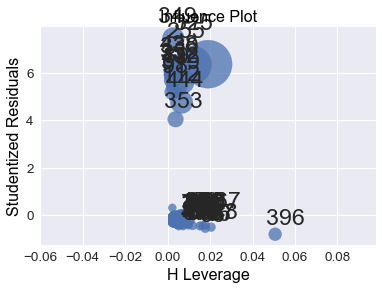

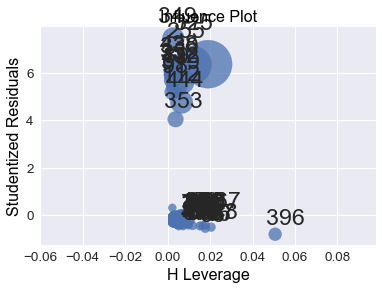

In [22]:
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(m)

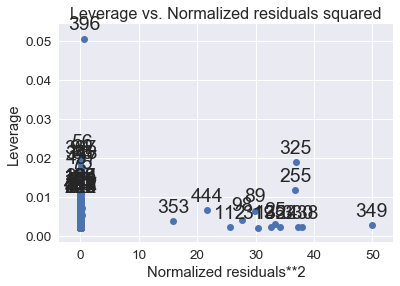

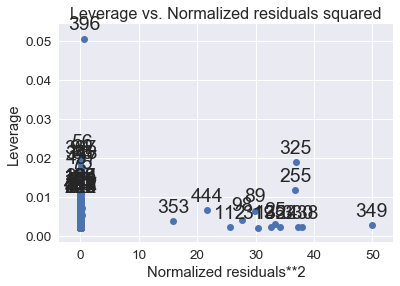

In [23]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
plot_leverage_resid2(m)

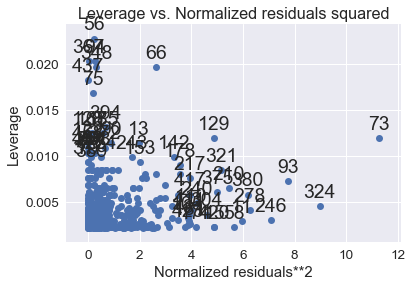

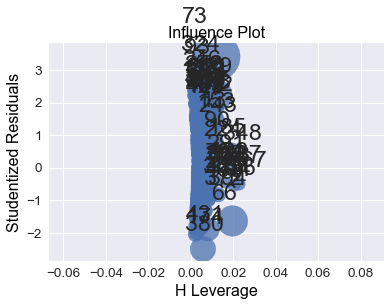

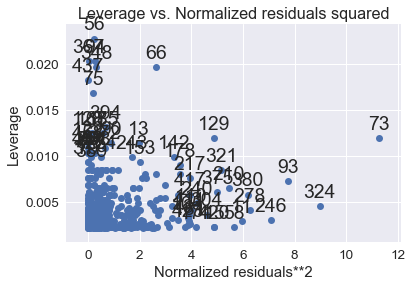

In [24]:
#thoracic_df_new = thoracic_df.drop(thoracic_df.index[[89,112,353,325,349,444,255,132,98,319]]) eh hard to see all
thoracic_df_new = thoracic_df[thoracic_df.FEV1 <40]
thoracic_df_new = thoracic_df_new.drop(thoracic_df.index[[215,396]]) #from doing the following on just the first drops
mnew = ols('FEV1 ~ Age',thoracic_df_new).fit()
influence_plot(mnew)
plot_leverage_resid2(mnew)

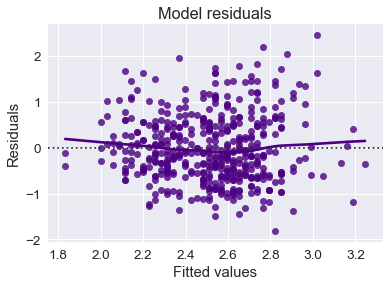

In [25]:
sns.residplot(mnew.fittedvalues, mnew.resid, lowess=True, color="indigo")
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Model residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 Risk1Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8605
Date:                Mon, 16 Jul 2018   Prob (F-statistic):              0.354
Time:                        12:31:36   Log-Likelihood:                -181.08
No. Observations:                 470   AIC:                             366.2
Df Residuals:                     468   BIC:                             374.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1549      0.018      8.779      0.0

Text(0.5,1,'Relationship between Original and Predicted Risk1Y values')

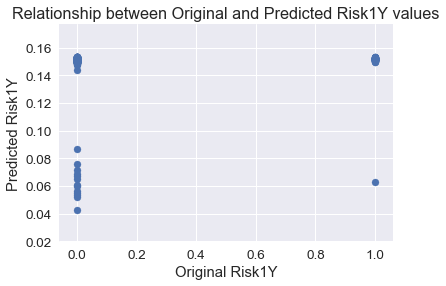

In [26]:
mmf = ols('Risk1Y ~ FEV1',thoracic_df).fit() #seeing if outliers in FEV1 may affect Risk1Y in the old thoracic df
print(mmf.summary())
plt.scatter(thoracic_df.Risk1Y, mmf.fittedvalues)
plt.xlabel("Original Risk1Y")
plt.ylabel("Predicted Risk1Y")
plt.title("Relationship between Original and Predicted Risk1Y values")

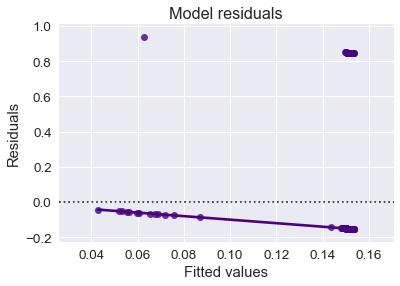

In [27]:
sns.residplot(mmf.fittedvalues, mmf.resid, lowess=True, color="indigo") 
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Model residuals')
plt.show()

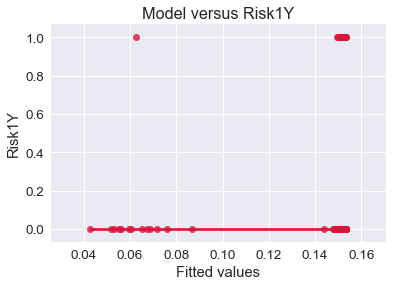

In [28]:
sns.regplot(mmf.fittedvalues, thoracic_df.Risk1Y, lowess=True, color='crimson')
plt.xlabel('Fitted values')
plt.title('Model versus Risk1Y')
plt.show()

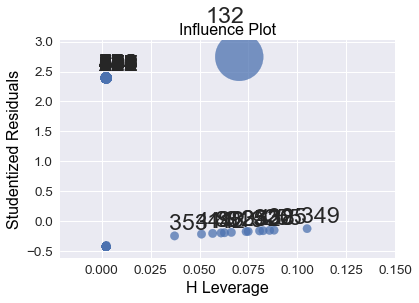

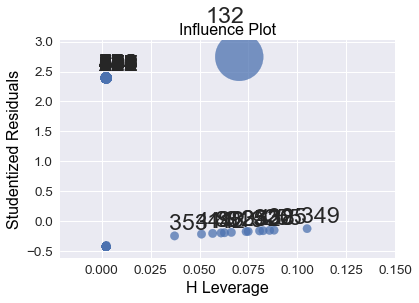

In [29]:
influence_plot(mmf)

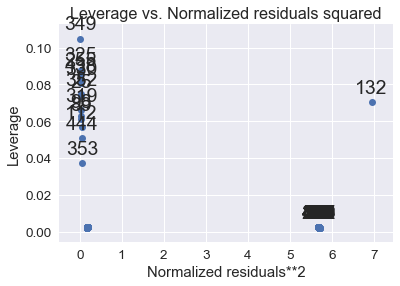

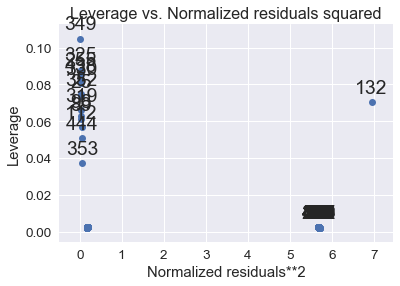

In [30]:
plot_leverage_resid2(mmf)

In [31]:
thoracic_df.iloc[132]       #shows that this individual passed away while having FEV1 of 71.1 - obvious influential outlier

DGN             2.0
FVC             2.5
FEV1           71.1
Zubrod          0.0
Pain            0.0
Haemoptysis     0.0
Dyspnea         1.0
Cough           0.0
Weakness        0.0
Tumor_size     13.0
T2DM            0.0
MI              0.0
PAD             0.0
Smoking         1.0
Asthma          0.0
Age            64.0
Risk1Y          1.0
Name: 132, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                 Risk1Y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.448
Date:                Mon, 16 Jul 2018   Prob (F-statistic):              0.118
Time:                        12:31:59   Log-Likelihood:                -177.88
No. Observations:                 454   AIC:                             359.8
Df Residuals:                     452   BIC:                             368.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2380      0.057      4.139      0.0

Text(0.5,1,'Relationship between Original and Predicted Risk1Y values')

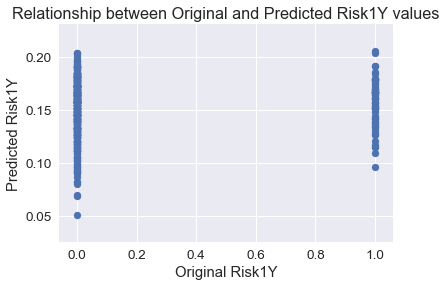

In [32]:
mmfnew = ols('Risk1Y ~ FEV1',thoracic_df_new).fit() #seeing if difference with the new thoracic df
print(mmfnew.summary())
plt.scatter(thoracic_df_new.Risk1Y, mmfnew.fittedvalues)
plt.xlabel("Original Risk1Y")
plt.ylabel("Predicted Risk1Y")
plt.title("Relationship between Original and Predicted Risk1Y values")

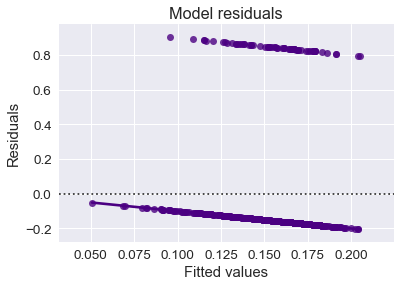

In [33]:
sns.residplot(mmfnew.fittedvalues, mmfnew.resid, lowess=True, color="indigo") #is this one u-shaped?
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Model residuals')
plt.show()

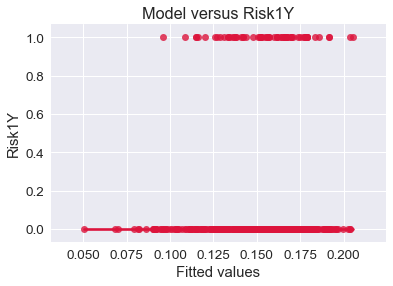

In [34]:
sns.regplot(mmfnew.fittedvalues, thoracic_df_new.Risk1Y, lowess=True, color='crimson')
plt.xlabel('Fitted values')
plt.title('Model versus Risk1Y')
plt.show()

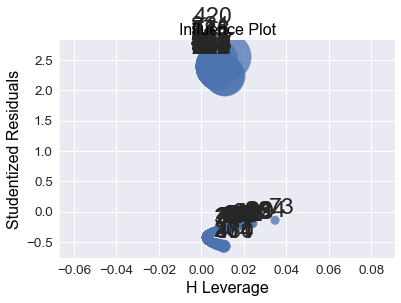

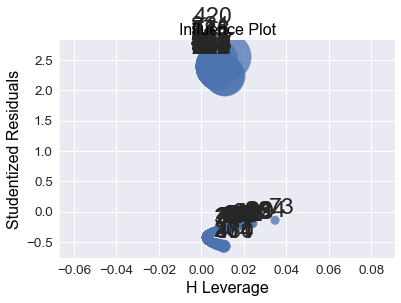

In [35]:
influence_plot(mmfnew)

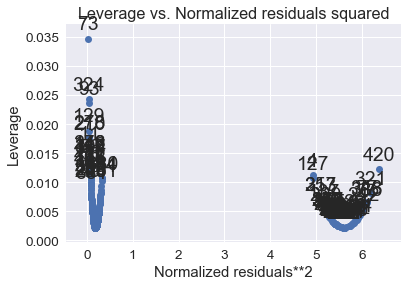

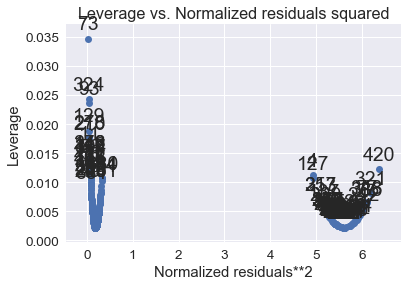

In [36]:
plot_leverage_resid2(mmfnew)

## Continued exploratory data analysis with outliers removed

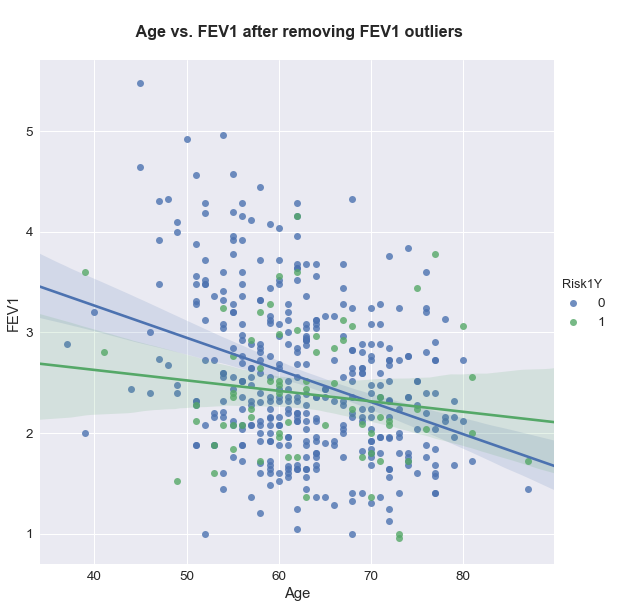

In [37]:
sns.set(font_scale=1.35)
axy = sns.lmplot(x='Age', y='FEV1', data=thoracic_df_new, hue='Risk1Y',size=8)
plt.title('\n Age vs. FEV1 after removing FEV1 outliers\n', fontweight='bold')
plt.show()

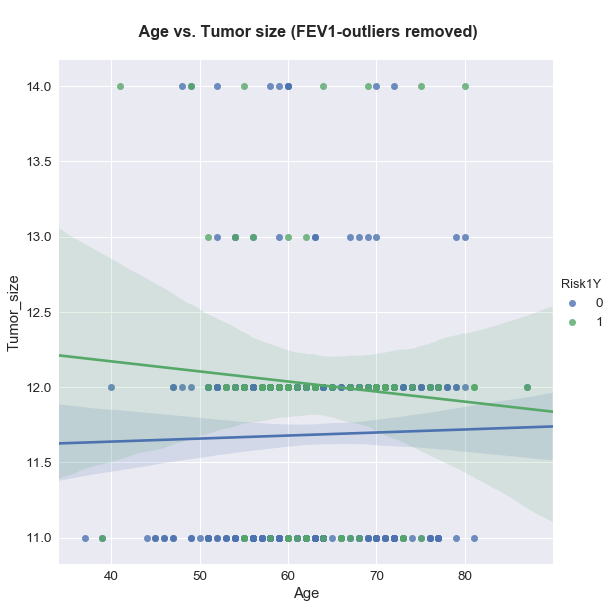

In [38]:
sns.set(font_scale=1.35)
sns.lmplot(x='Age', y='Tumor_size', data=thoracic_df_new, hue='Risk1Y',size=8)
plt.title('\n Age vs. Tumor size (FEV1-outliers removed)\n', fontweight='bold')
plt.show()

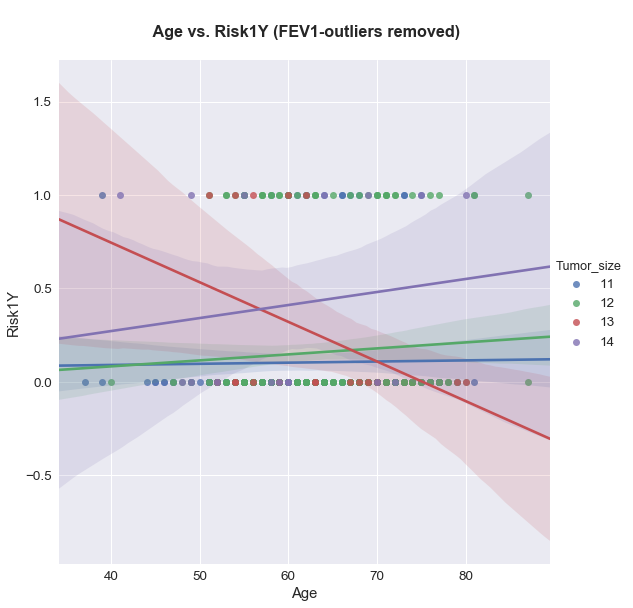

In [39]:
sns.set(font_scale=1.35)
sns.lmplot(x='Age', y='Risk1Y', data=thoracic_df_new, hue='Tumor_size',size=8)
plt.title('\n Age vs. Risk1Y (FEV1-outliers removed)\n', fontweight='bold')
plt.show()

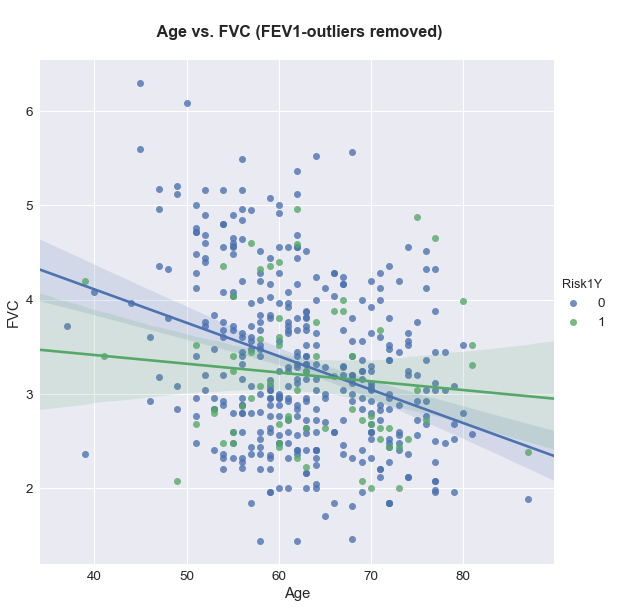

In [40]:
sns.set(font_scale=1.35)
sns.lmplot(x='Age', y='FVC', data=thoracic_df_new, hue='Risk1Y',size=8)
plt.title('\n Age vs. FVC (FEV1-outliers removed)\n', fontweight='bold')
plt.show()

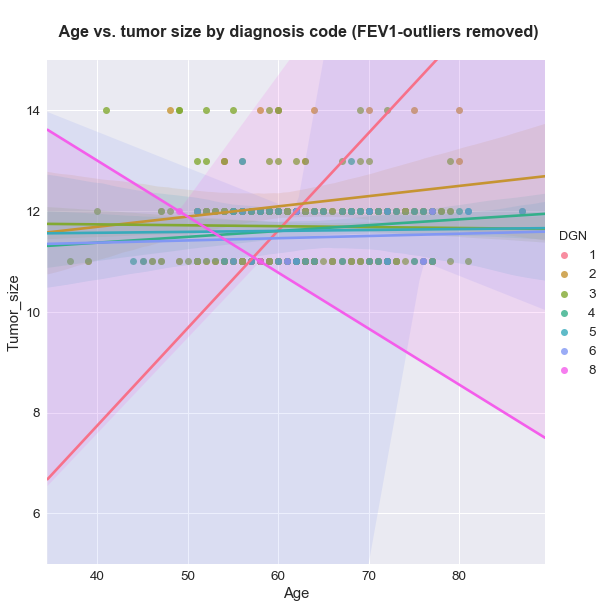

In [41]:
sns.set(font_scale=1.35)
axy1 = sns.lmplot(x='Age', y='Tumor_size', data=thoracic_df_new, hue='DGN',size=8)
plt.title('\n Age vs. tumor size by diagnosis code (FEV1-outliers removed)\n', fontweight='bold')
axy1.set(ylim=(5, 15)) 
plt.show()

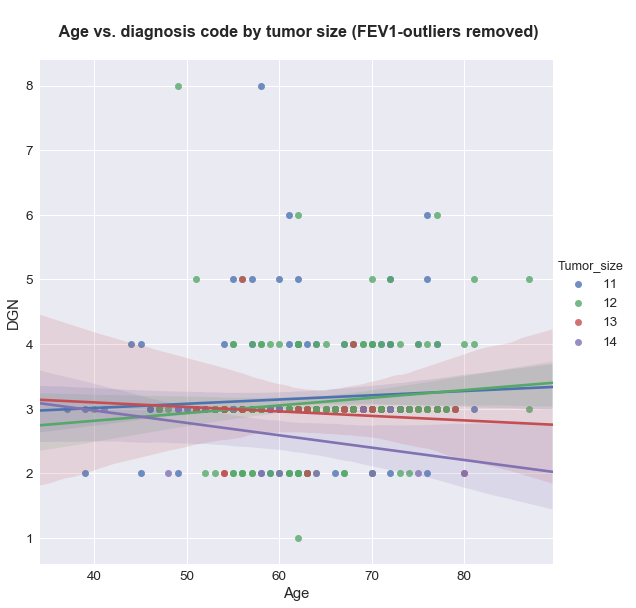

In [42]:
sns.set(font_scale=1.35)
sns.lmplot(x='Age', y='DGN', data=thoracic_df_new, hue='Tumor_size',size=8)
plt.title('\n Age vs. diagnosis code by tumor size (FEV1-outliers removed)\n', fontweight='bold')
plt.show()

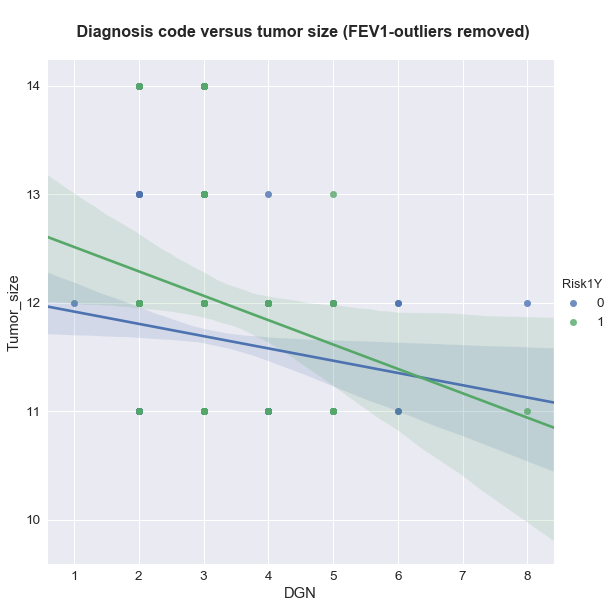

In [43]:
sns.set(font_scale=1.35)
sns.lmplot(x='DGN', y='Tumor_size', data=thoracic_df_new, hue='Risk1Y',size=8)
plt.title('\n Diagnosis code versus tumor size (FEV1-outliers removed)\n', fontweight='bold')
plt.show()

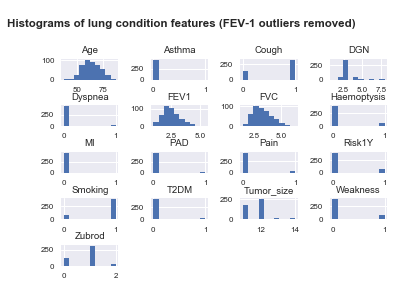

In [45]:
sns.set(font_scale=0.8)
thoracic_df_new.hist()
plt.suptitle('\nHistograms of lung condition features (FEV-1 outliers removed)', fontweight='bold')
plt.tight_layout(rect=[0.15, 0, 1, 2.5], h_pad=6)
plt.subplots_adjust(top=0.80)
plt.show()

## Correlations and chi-squared analyses


Heatmap of correlations between variables


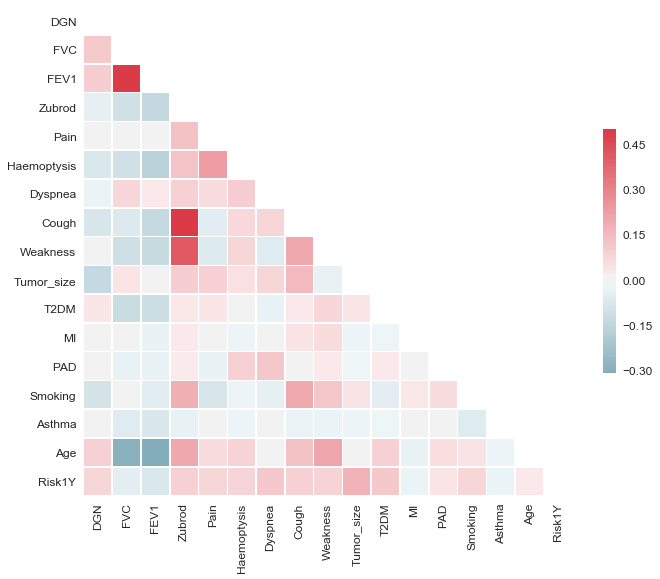

In [46]:
sns.set(style="white", font_scale=1.20)
corr = thoracic_df_new.corr()
mask = np.zeros_like(corr, dtype=np.bool)
# mask upper triangle by replacing values with 0 and masking zeros
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print('\033[1m' + "\nHeatmap of correlations between variables")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [47]:
def pearson_general(colA, colB, alpha=0.001):
    A = thoracic_df_new[colA].astype(float)
    B = thoracic_df_new[colB].astype(float) 
    
    r, p = pearsonr(B,A)
    if p<alpha:
        result="\033[1m {} with {}:".format(colA,colB)
    else:
        result="\033[0m {} with {}:".format(colA,colB)
    print(result, f"Pearson r = {round(r,3)}, p = {round(p,5)}")

print('\033[4m\033[1m\nPearson correlation coefficients (r) and p-values (p) for relationships between continuous variables:\n\033[0m')
cols = ['FVC', 'FEV1', 'Age']
for e,f in itertools.combinations(cols,2):
    pearson_general(e,f)


Pearson correlation coefficients (r) and p-values (p) for relationships between continuous variables:

 FVC with FEV1: Pearson r = 0.888, p = 0.0
 FVC with Age: Pearson r = -0.299, p = 0.0
 FEV1 with Age: Pearson r = -0.31, p = 0.0


In [48]:
def Chi2test_general(colV, colZ, alpha=0.001):
    V = thoracic_df_new[colV].astype(str)
    Z = thoracic_df_new[colZ].astype(str)        
    obs = pd.crosstab(Z,V) 
    chi2, p, dof, expected = stats.chi2_contingency(obs.values)        
    Expected = pd.DataFrame(expected, columns=obs.columns, index = obs.index)
    if p<alpha:
        result="\033[1m {} with {}:".format(colV,colZ)
    else:
        result="\033[0m {} with {}:".format(colV,colZ)
    print(result, f"Chi-square stat. = {round(chi2,2)}, p = {round(p,5)}")
    
print('\033[4m\033[1m\nChi-square statistics and p-values (p) for relationships between categorical variables:\n\033[0m')  
Columns = ['DGN', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea', 'Cough', 'Weakness', 'Tumor_size', 'MI', 'PAD', 'Smoking', 'Asthma', 'Risk1Y']
for g,h in itertools.combinations(Columns,2):
    Chi2test_general(g,h)


Chi-square statistics and p-values (p) for relationships between categorical variables:

 DGN with Zubrod: Chi-square stat. = 12.76, p = 0.38675
 DGN with Pain: Chi-square stat. = 0.89, p = 0.98938
 DGN with Haemoptysis: Chi-square stat. = 6.56, p = 0.36365
 DGN with Dyspnea: Chi-square stat. = 1.59, p = 0.95343
 DGN with Cough: Chi-square stat. = 9.09, p = 0.16847
 DGN with Weakness: Chi-square stat. = 3.62, p = 0.72757
 DGN with Tumor_size: Chi-square stat. = 25.72, p = 0.1063
 DGN with MI: Chi-square stat. = 0.67, p = 0.99504
 DGN with PAD: Chi-square stat. = 5.26, p = 0.51048
 DGN with Smoking: Chi-square stat. = 10.49, p = 0.1053
 DGN with Asthma: Chi-square stat. = 0.67, p = 0.99504
 DGN with Risk1Y: Chi-square stat. = 21.56, p = 0.00145
 Zubrod with Pain: Chi-square stat. = 8.21, p = 0.01651
 Zubrod with Haemoptysis: Chi-square stat. = 7.76, p = 0.02062
 Zubrod with Dyspnea: Chi-square stat. = 3.99, p = 0.13606
 Zubrod with Cough: Chi-square stat. = 259.27, p = 0.0
 Zubrod with

## Preparing data for machine learning (no over- or resampling of training set)

In [49]:
thoracic_df_new['Risk1Y'].value_counts()

0    385
1     69
Name: Risk1Y, dtype: int64

In [50]:
X = thoracic_df_new.drop('Risk1Y', axis = 1)
y = thoracic_df_new.Risk1Y


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, stratify=y)

#random state makes a difference with this small dataset of few in the minority class. 

In [51]:
y_train.value_counts()

0    288
1     52
Name: Risk1Y, dtype: int64

In [52]:
y_test.value_counts()

0    97
1    17
Name: Risk1Y, dtype: int64

In [53]:
y_train = pd.DataFrame(y_train)
y_train.columns = ['Risk1Y']
train_df = pd.merge(X_train, y_train, how='outer', left_index=True, right_index=True, left_on=None, right_on=None )
train_df.columns

Index(['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea',
       'Cough', 'Weakness', 'Tumor_size', 'T2DM', 'MI', 'PAD', 'Smoking',
       'Asthma', 'Age', 'Risk1Y'],
      dtype='object')

## Choosing a classifier using the training set

### Extra trees classifier

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy on training data: 1.0
Accuracy on test data: 0.868
             precision    recall  f1-score   support

          0       0.87      1.00      0.93        97
          1       1.00      0.12      0.21        17

avg / total       0.89      0.87      0.82       114

[[97  0]
 [15  2]]
AU-ROC score for Extra Trees model: 0.6959


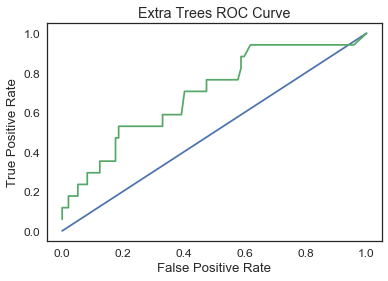

In [54]:

extra = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
extra.fit(X_train, y_train)

print('Accuracy on training data:',round(extra.score(X_train, y_train),3))
print('Accuracy on test data:',round(extra.score(X_test, y_test),3))
extra_pred = extra.predict(X_test)
print(classification_report(y_test,extra_pred))
print(confusion_matrix(y_test,extra_pred))

ey_pred_prob = extra.predict_proba(X_test)[:,1]
print('AU-ROC score for Extra Trees model:', round(roc_auc_score(y_test, ey_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ey_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Extra Trees Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees ROC Curve')
plt.show()

### Setting sample weights

In [55]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight #(class_weight, y, indices=None)[source]

print(y[50])
print(y[4])
cw = compute_class_weight('balanced',[0,1],y)
sw = compute_sample_weight('balanced', y, indices=None)
print(sw[50])
print(sw[4])

0
1
0.58961038961
3.28985507246


In [56]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from matplotlib import cm


X1_train, X1_test, y1_train, y1_test, sw_train, sw_test = \
    train_test_split(X, y, sw, random_state=100, stratify=y)



AU-ROC score for uncalibrated Extra Trees model: 0.6959
AU-ROC score for isotonically calibrated Extra Trees model: 0.748
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6874

Brier scores: (the smaller the better)
No calibration: 0.324
With isotonic calibration: 0.206
With sigmoid calibration: 0.237


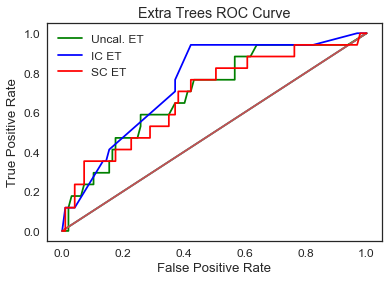

In [57]:
# ET with no calibration
etn = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etn.fit(X1_train, y1_train)  
prob_pos_et1 = etn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y1_test, prob_pos_et1),4))

# ET with isotonic calibration
et_isotonic = CalibratedClassifierCV(etn, cv=2, method='isotonic')
et_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicet = et_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y1_test, prob_pos_isotonicet),4))

# ET with sigmoid calibration
et_sigmoid = CalibratedClassifierCV(etn, cv=2, method='sigmoid')
et_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidet = et_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y1_test, prob_pos_sigmoidet),4))

print("\nBrier scores: (the smaller the better)")

et_score = brier_score_loss(y1_test, prob_pos_et1, sw_test)
print("No calibration: %1.3f" % et_score)

et_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicet, sw_test)
print("With isotonic calibration: %1.3f" % et_isotonic_score)

et_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidet, sw_test)
print("With sigmoid calibration: %1.3f" % et_sigmoid_score)



fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_et1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. ET', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicet)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC ET', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidet)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC ET', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees ROC Curve')

plt.legend()
plt.show()

#isotonic



In [58]:
etn_pred = etn.predict(X_test)
print(classification_report(y_test,etn_pred))
print(confusion_matrix(y_test, etn_pred))

etiso_pred = et_isotonic.predict(X_test)
print(classification_report(y_test,etiso_pred))
print(confusion_matrix(y_test, etiso_pred))

etsig_pred = et_sigmoid.predict(X_test)
print(classification_report(y_test,etsig_pred))
print(confusion_matrix(y_test, etsig_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92        97
          1       0.00      0.00      0.00        17

avg / total       0.72      0.85      0.78       114

[[97  0]
 [17  0]]
             precision    recall  f1-score   support

          0       0.98      0.58      0.73        97
          1       0.28      0.94      0.43        17

avg / total       0.88      0.63      0.68       114

[[56 41]
 [ 1 16]]
             precision    recall  f1-score   support

          0       0.89      0.72      0.80        97
          1       0.23      0.47      0.31        17

avg / total       0.79      0.68      0.72       114

[[70 27]
 [ 9  8]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random forest classifier

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Basic Random Forest accuracy on training data: 1.0
Basic Random Forest accuracy on test data: 0.851
             precision    recall  f1-score   support

          0       0.85      1.00      0.92        97
          1       0.00      0.00      0.00        17

avg / total       0.72      0.85      0.78       114

[[97  0]
 [17  0]]
AU-ROC score for Random Forest model: 0.7129


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


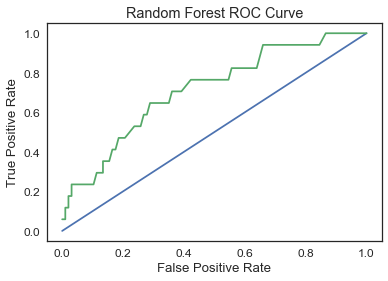

In [59]:
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rf.fit(X_train, y_train)
print('Basic Random Forest accuracy on training data:',round(rf.score(X_train, y_train),3))
print('Basic Random Forest accuracy on test data:',round(rf.score(X_test, y_test),3))
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test, rf_pred))

ry_pred_prob = rf.predict_proba(X_test)[:,1]
print('AU-ROC score for Random Forest model:', round(roc_auc_score(y_test, ry_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ry_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Random forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

AU-ROC score for uncalibrated Random Forest model: 0.7353
AU-ROC score for isotonically calibrated Random Forest model: 0.7135
AU-ROC score for sigmoid calibrated Random Forest model: 0.6962

Brier scores: (the smaller the better)
No calibration: 0.319
With isotonic calibration: 0.218
With sigmoid calibration: 0.243


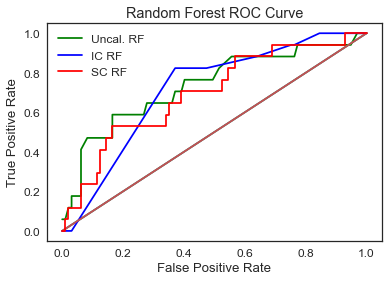

In [60]:
# RF with no calibration
rfn = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfn.fit(X1_train, y1_train)  
prob_pos_rf1 = rfn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated Random Forest model:', round(roc_auc_score(y1_test, prob_pos_rf1),4))

# RF with isotonic calibration
rf_isotonic = CalibratedClassifierCV(rfn, cv=2, method='isotonic')
rf_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicrf = rf_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated Random Forest model:', round(roc_auc_score(y1_test, prob_pos_isotonicrf),4))

# RF with sigmoid calibration
rf_sigmoid = CalibratedClassifierCV(rfn, cv=2, method='sigmoid')
rf_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidrf = rf_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Random Forest model:', round(roc_auc_score(y1_test, prob_pos_sigmoidrf),4))

print("\nBrier scores: (the smaller the better)")

rf_score = brier_score_loss(y1_test, prob_pos_rf1, sw_test)
print("No calibration: %1.3f" % rf_score)

rf_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicrf, sw_test)
print("With isotonic calibration: %1.3f" % rf_isotonic_score)

rf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidrf, sw_test)
print("With sigmoid calibration: %1.3f" % rf_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_rf1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. RF', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicrf)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC RF', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidrf)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC RF', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')

plt.legend()
plt.show()

#isotonic sometimes and uncalibrated other times.



In [61]:
rfn_pred = rfn.predict(X_test)
print(classification_report(y_test,rfn_pred))
print(confusion_matrix(y_test, rfn_pred))

rfiso_pred = rf_isotonic.predict(X_test)
print(classification_report(y_test,rfiso_pred))
print(confusion_matrix(y_test, rfiso_pred))

rfsig_pred = rf_sigmoid.predict(X_test)
print(classification_report(y_test,rfsig_pred))
print(confusion_matrix(y_test, rfsig_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92        97
          1       0.00      0.00      0.00        17

avg / total       0.72      0.85      0.78       114

[[97  0]
 [17  0]]
             precision    recall  f1-score   support

          0       0.95      0.62      0.75        97
          1       0.27      0.82      0.41        17

avg / total       0.85      0.65      0.70       114

[[60 37]
 [ 3 14]]
             precision    recall  f1-score   support

          0       0.91      0.81      0.86        97
          1       0.33      0.53      0.41        17

avg / total       0.82      0.77      0.79       114

[[79 18]
 [ 8  9]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### XGBoost classifier

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training data: 0.997
Accuracy on test data: 0.833
             precision    recall  f1-score   support

          0       0.85      0.97      0.91        97
          1       0.25      0.06      0.10        17

avg / total       0.76      0.83      0.79       114

[[94  3]
 [16  1]]
AU-ROC score for XGBoost model: 0.701


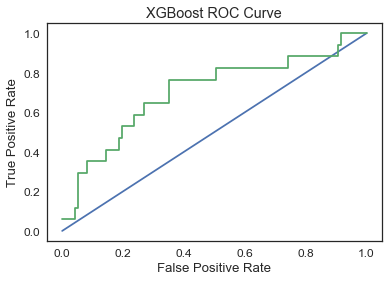

In [62]:
xgbo = XGBClassifier(max_depth=20, max_learning_rate=0.01)
#xgbo = XGBClassifier()
xgbo.fit(X_train, y_train)
xy_pred = xgbo.predict(X_test)
predictionsx = [round(value) for value in xy_pred]
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Accuracy on training data:',round(xgbo.score(X_train, y_train),3))
print('Accuracy on test data:',round(xgbo.score(X_test, y_test),3))
print(classification_report(y_test,xy_pred))
print(confusion_matrix(y_test,xy_pred))

xy_pred_prob = xgbo.predict_proba(X_test)[:,1]
print('AU-ROC score for XGBoost model:', round(roc_auc_score(y_test, xy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, xy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.show()



AU-ROC score for uncalibrated XGBoost model: 0.6713
AU-ROC score for isotonically calibrated XGBoost model: 0.7089
AU-ROC score for sigmoid calibrated XGBoost model: 0.6568

Brier scores: (the smaller the better)
No calibration: 0.352
With isotonic calibration: 0.233
With sigmoid calibration: 0.247


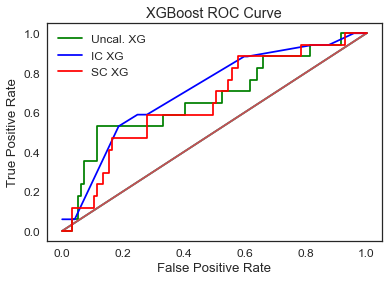

In [63]:
# XG with no calibration
#xgn = XGBClassifier(max_depth=20)
xgn = XGBClassifier() #performing better without parameters added, unlike above...or maybe just isotonic is.
xgn.fit(X1_train, y1_train)  
prob_pos_xg1 = xgn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated XGBoost model:', round(roc_auc_score(y1_test, prob_pos_xg1),4))

# XG with isotonic calibration
xg_isotonic = CalibratedClassifierCV(xgn, cv=2, method='isotonic')
xg_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicxg = xg_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated XGBoost model:', round(roc_auc_score(y1_test, prob_pos_isotonicxg),4))

# XG with sigmoid calibration
xg_sigmoid = CalibratedClassifierCV(xgn, cv=2, method='sigmoid')
xg_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidxg = xg_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated XGBoost model:', round(roc_auc_score(y1_test, prob_pos_sigmoidxg),4))

print("\nBrier scores: (the smaller the better)")

xg_score = brier_score_loss(y1_test, prob_pos_xg1, sw_test)
print("No calibration: %1.3f" % xg_score)

xg_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicxg, sw_test)
print("With isotonic calibration: %1.3f" % xg_isotonic_score)

xg_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidxg, sw_test)
print("With sigmoid calibration: %1.3f" % xg_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_xg1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. XG', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicxg)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC XG', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidxg)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC XG', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')

plt.legend()
plt.show()

#this is more stable than rf curves are. Isotonic calibration is best with XGB, though some tree ones are better.
#isotonic kept being awesome for a while, but after restarting etc. it's not and is giving this mediocre result.

In [64]:
xgn_pred = xgn.predict(X_test)
print(classification_report(y_test,xgn_pred))
print(confusion_matrix(y_test, xgn_pred))

xgiso_pred = xg_isotonic.predict(X_test)
print(classification_report(y_test,xgiso_pred))
print(confusion_matrix(y_test, xgiso_pred))

xgsig_pred = xg_sigmoid.predict(X_test)
print(classification_report(y_test,xgsig_pred))
print(confusion_matrix(y_test, xgsig_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92        97
          1       0.00      0.00      0.00        17

avg / total       0.72      0.85      0.78       114

[[97  0]
 [17  0]]
             precision    recall  f1-score   support

          0       0.91      0.73      0.81        97
          1       0.28      0.59      0.38        17

avg / total       0.82      0.71      0.75       114

[[71 26]
 [ 7 10]]
             precision    recall  f1-score   support

          0       0.87      0.89      0.88        97
          1       0.27      0.24      0.25        17

avg / total       0.78      0.79      0.78       114

[[86 11]
 [13  4]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


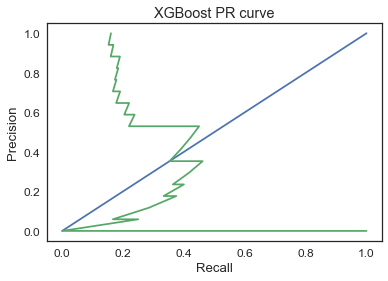

In [65]:
xgy_pred = xgn.predict_proba(X_test)[:,1]
p, r, _ = precision_recall_curve(y_test, xgy_pred)
plt.plot([0,1],[0,1])
plt.plot(p,r, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost PR curve')
plt.show()

### Gradient boosting classifier

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training data: 0.938
Accuracy on test data: 0.833
             precision    recall  f1-score   support

          0       0.85      0.97      0.91        97
          1       0.25      0.06      0.10        17

avg / total       0.76      0.83      0.79       114

[[94  3]
 [16  1]]
AU-ROC score for Gradient Boost model: 0.6938


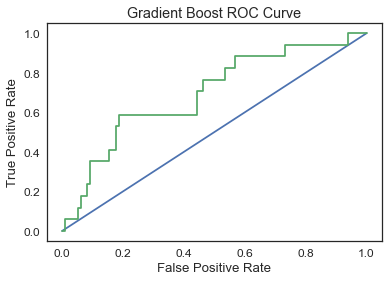

In [66]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gy_pred = gbc.predict(X_test)
print('Accuracy on training data:',round(gbc.score(X_train, y_train),3))
print('Accuracy on test data:',round(gbc.score(X_test, y_test),3))
print(classification_report(y_test,gy_pred))
print(confusion_matrix(y_test,gy_pred))

gy_pred_prob = gbc.predict_proba(X_test)[:,1]
print('AU-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve')
plt.show()

AU-ROC score for uncalibrated Gradient Boost model: 0.6901
AU-ROC score for isotonically calibrated Gradient Boost model: 0.6649
AU-ROC score for sigmoid calibrated Gradient Boost model: 0.6877

Brier scores: (the smaller the better)
No calibration: 0.351
With isotonic calibration: 0.233
With sigmoid calibration: 0.245


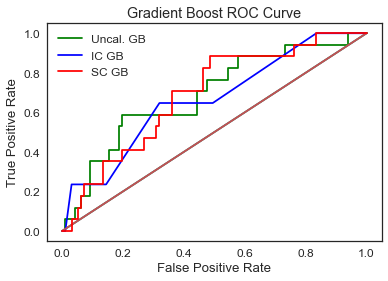

In [67]:
# GB with no calibration
gbn = GradientBoostingClassifier()
gbn.fit(X1_train, y1_train)  
prob_pos_gb1 = gbn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated Gradient Boost model:', round(roc_auc_score(y1_test, prob_pos_gb1),4))

# GB with isotonic calibration
gb_isotonic = CalibratedClassifierCV(gbn, cv=2, method='isotonic')
gb_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicgb = gb_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated Gradient Boost model:', round(roc_auc_score(y1_test, prob_pos_isotonicgb),4))

# GB with sigmoid calibration
gb_sigmoid = CalibratedClassifierCV(gbn, cv=2, method='sigmoid')
gb_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidgb = gb_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Gradient Boost model:', round(roc_auc_score(y1_test, prob_pos_sigmoidgb),4))

print("\nBrier scores: (the smaller the better)")

gb_score = brier_score_loss(y1_test, prob_pos_gb1, sw_test)
print("No calibration: %1.3f" % gb_score)

gb_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicgb, sw_test)
print("With isotonic calibration: %1.3f" % gb_isotonic_score)

gb_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidgb, sw_test)
print("With sigmoid calibration: %1.3f" % gb_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_gb1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. GB', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicgb)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC GB', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidgb)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC GB', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve')

plt.legend()
plt.show()

#isotonic calibration is best with GB though sometimes uncalib is.

In [68]:
gbn_pred = gbn.predict(X_test)
print(classification_report(y_test,gbn_pred))
print(confusion_matrix(y_test, gbn_pred))

gbiso_pred = gb_isotonic.predict(X_test)
print(classification_report(y_test,gbiso_pred))
print(confusion_matrix(y_test, gbiso_pred))

gbsig_pred = gb_sigmoid.predict(X_test)
print(classification_report(y_test,gbsig_pred))
print(confusion_matrix(y_test, gbsig_pred))

             precision    recall  f1-score   support

          0       0.85      0.97      0.91        97
          1       0.25      0.06      0.10        17

avg / total       0.76      0.83      0.79       114

[[94  3]
 [16  1]]
             precision    recall  f1-score   support

          0       0.92      0.67      0.77        97
          1       0.26      0.65      0.37        17

avg / total       0.82      0.67      0.71       114

[[65 32]
 [ 6 11]]
             precision    recall  f1-score   support

          0       0.88      0.84      0.86        97
          1       0.27      0.35      0.31        17

avg / total       0.79      0.76      0.78       114

[[81 16]
 [11  6]]


### AdaBoost classifier

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training data: 0.871
Accuracy on test data: 0.825
             precision    recall  f1-score   support

          0       0.85      0.96      0.90        97
          1       0.20      0.06      0.09        17

avg / total       0.76      0.82      0.78       114

[[93  4]
 [16  1]]
AU-ROC score for AdaBoost model: 0.691


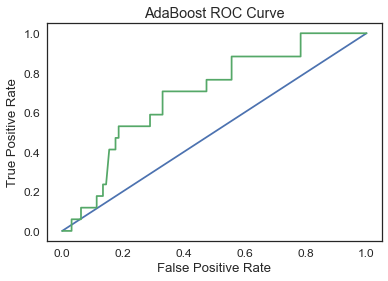

In [69]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
ay_pred = abc.predict(X_test)
print('Accuracy on training data:',round(abc.score(X_train, y_train),3))
print('Accuracy on test data:',round(abc.score(X_test, y_test),3))
print(classification_report(y_test,ay_pred))
print(confusion_matrix(y_test,ay_pred))

ay_pred_prob = abc.predict_proba(X_test)[:,1]
print('AU-ROC score for AdaBoost model:', round(roc_auc_score(y_test, ay_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ay_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')
plt.show()

AU-ROC score for uncalibrated AdaBoost model: 0.691
AU-ROC score for isotonically calibrated AdaBoost model: 0.5943
AU-ROC score for sigmoid calibrated AdaBoost model: 0.6428

Brier scores: (the smaller the better)
No calibration: 0.241
With isotonic calibration: 0.234
With sigmoid calibration: 0.236


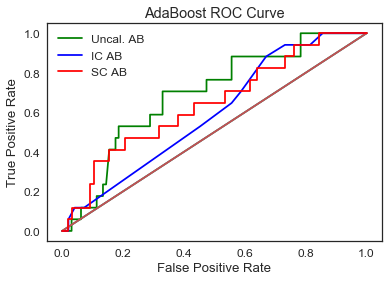

In [70]:
# AB with no calibration
abn = AdaBoostClassifier()
abn.fit(X1_train, y1_train)  
prob_pos_ab1 = abn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated AdaBoost model:', round(roc_auc_score(y1_test, prob_pos_ab1),4))

# AB with isotonic calibration
ab_isotonic = CalibratedClassifierCV(abn, cv=2, method='isotonic')
ab_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicab = ab_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated AdaBoost model:', round(roc_auc_score(y1_test, prob_pos_isotonicab),4))

# AB with sigmoid calibration
ab_sigmoid = CalibratedClassifierCV(abn, cv=2, method='sigmoid')
ab_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidab = ab_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated AdaBoost model:', round(roc_auc_score(y1_test, prob_pos_sigmoidab),4))

print("\nBrier scores: (the smaller the better)")

ab_score = brier_score_loss(y1_test, prob_pos_ab1, sw_test)
print("No calibration: %1.3f" % ab_score)

ab_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicab, sw_test)
print("With isotonic calibration: %1.3f" % ab_isotonic_score)

ab_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidab, sw_test)
print("With sigmoid calibration: %1.3f" % ab_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_ab1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. AB', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicab)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC AB', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidab)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC AB', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')

plt.legend()
plt.show()



In [71]:
abn_pred = abn.predict(X_test)
print(classification_report(y_test,abn_pred))
print(confusion_matrix(y_test, abn_pred))

abiso_pred = ab_isotonic.predict(X_test)
print(classification_report(y_test,abiso_pred))
print(confusion_matrix(y_test, abiso_pred))

absig_pred = ab_sigmoid.predict(X_test)
print(classification_report(y_test,absig_pred))
print(confusion_matrix(y_test, absig_pred))

             precision    recall  f1-score   support

          0       0.85      0.96      0.90        97
          1       0.20      0.06      0.09        17

avg / total       0.76      0.82      0.78       114

[[93  4]
 [16  1]]
             precision    recall  f1-score   support

          0       0.88      0.44      0.59        97
          1       0.17      0.65      0.27        17

avg / total       0.77      0.47      0.54       114

[[43 54]
 [ 6 11]]
             precision    recall  f1-score   support

          0       0.88      0.63      0.73        97
          1       0.20      0.53      0.29        17

avg / total       0.78      0.61      0.67       114

[[61 36]
 [ 8  9]]


### Decision tree classifier

Accuracy on training data: 1.0
Accuracy on test data: 0.807
             precision    recall  f1-score   support

          0       0.93      0.84      0.88        97
          1       0.41      0.65      0.50        17

avg / total       0.85      0.81      0.82       114

[[81 16]
 [ 6 11]]
AU-ROC score for Decision Tree model: 0.7411


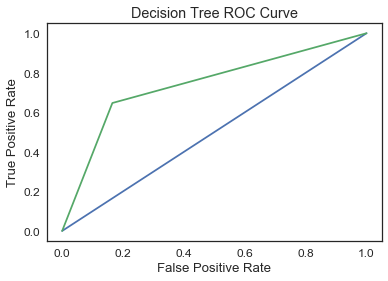

In [72]:


dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)
dy_pred = dt.predict(X_test)
print('Accuracy on training data:',round(dt.score(X_train, y_train),3))
print('Accuracy on test data:',round(dt.score(X_test, y_test),3))
print(classification_report(y_test,dy_pred))
print(confusion_matrix(y_test,dy_pred))

dy_pred_prob = dt.predict_proba(X_test)[:,1]
print('AU-ROC score for Decision Tree model:', round(roc_auc_score(y_test, dy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, dy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

AU-ROC score for uncalibrated Decision Tree model: 0.7116
AU-ROC score for isotonically calibrated Decision Tree model: 0.5124
AU-ROC score for sigmoid calibrated Decision Tree model: 0.5052

Brier scores: (the smaller the better)
No calibration: 0.287
With isotonic calibration: 0.250
With sigmoid calibration: 0.250


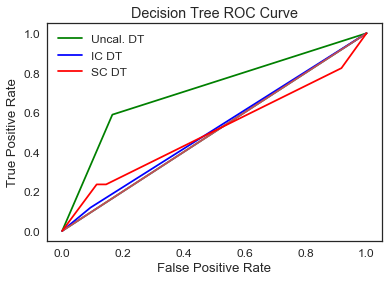

In [73]:
# DT with no calibration
dtn = DecisionTreeClassifier(class_weight='balanced')
dtn.fit(X1_train, y1_train)  
prob_pos_dt1 = dtn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated Decision Tree model:', round(roc_auc_score(y1_test, prob_pos_dt1),4))

# DT with isotonic calibration
dt_isotonic = CalibratedClassifierCV(dtn, cv=2, method='isotonic')
dt_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicdt = dt_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated Decision Tree model:', round(roc_auc_score(y1_test, prob_pos_isotonicdt),4))

# DT with sigmoid calibration
dt_sigmoid = CalibratedClassifierCV(dtn, cv=2, method='sigmoid')
dt_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoiddt = dt_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Decision Tree model:', round(roc_auc_score(y1_test, prob_pos_sigmoiddt),4))

print("\nBrier scores: (the smaller the better)")

dt_score = brier_score_loss(y1_test, prob_pos_dt1, sw_test)
print("No calibration: %1.3f" % dt_score)

dt_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicdt, sw_test)
print("With isotonic calibration: %1.3f" % dt_isotonic_score)

dt_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoiddt, sw_test)
print("With sigmoid calibration: %1.3f" % dt_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_dt1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. DT', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicdt)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC DT', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoiddt)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC DT', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')

plt.legend()
plt.show()

In [74]:
dtn_pred = dtn.predict(X_test)
print(classification_report(y_test,dtn_pred))
print(confusion_matrix(y_test, dtn_pred))

dtiso_pred = dt_isotonic.predict(X_test)
print(classification_report(y_test,dtiso_pred))
print(confusion_matrix(y_test, dtiso_pred))

dtsig_pred = dt_sigmoid.predict(X_test)
print(classification_report(y_test,dtsig_pred))
print(confusion_matrix(y_test, dtsig_pred))

             precision    recall  f1-score   support

          0       0.92      0.84      0.88        97
          1       0.38      0.59      0.47        17

avg / total       0.84      0.80      0.81       114

[[81 16]
 [ 7 10]]
             precision    recall  f1-score   support

          0       0.85      0.91      0.88        97
          1       0.18      0.12      0.14        17

avg / total       0.75      0.79      0.77       114

[[88  9]
 [15  2]]
             precision    recall  f1-score   support

          0       0.87      0.89      0.88        97
          1       0.27      0.24      0.25        17

avg / total       0.78      0.79      0.78       114

[[86 11]
 [13  4]]


In [75]:
from sklearn import tree 

dtt = tree.DecisionTreeClassifier(class_weight='balanced')
dtt.fit(X1_train, y1_train)  
dt_data = tree.export_graphviz(dtt, out_file='dtttree.dot')   

In [76]:
y_train.columns = ['Risk1Y']
y_train.columns

Index(['Risk1Y'], dtype='object')

In [77]:
import graphviz

dtt1 = tree.DecisionTreeClassifier(class_weight='balanced')
dtt1.fit(X1_train, y1_train)  
dt_data1 = tree.export_graphviz(dtt1, out_file=None, feature_names=X_train.columns, filled=True)   
graph1 = graphviz.Source(dt_data1) 
graph1.render("DT_thoracic") 

'DT_thoracic.pdf'

### Logistic Regression

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training data: 0.621
Accuracy on test data: 0.649
             precision    recall  f1-score   support

          0       0.90      0.66      0.76        97
          1       0.23      0.59      0.33        17

avg / total       0.80      0.65      0.70       114

[[64 33]
 [ 7 10]]
AU-ROC score for Logistic Regression model: 0.6598


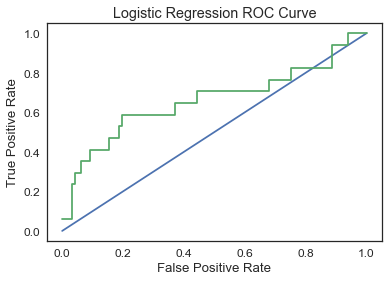

In [78]:
logr = LogisticRegression(class_weight='balanced')
logr.fit(X_train, y_train)
ly_pred = logr.predict(X_test)
print('Accuracy on training data:',round(logr.score(X_train, y_train),3))
print('Accuracy on test data:',round(logr.score(X_test, y_test),3))
print(classification_report(y_test,ly_pred))
print(confusion_matrix(y_test,ly_pred))

ly_pred_prob = logr.predict_proba(X_test)[:,1]
print('AU-ROC score for Logistic Regression model:', round(roc_auc_score(y_test, ly_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ly_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

AU-ROC score for uncalibrated Log Reg model: 0.6598
AU-ROC score for isotonically calibrated Log Reg model: 0.6389
AU-ROC score for sigmoid calibrated Log Reg model: 0.6562

Brier scores: (the smaller the better)
No calibration: 0.232
With isotonic calibration: 0.258
With sigmoid calibration: 0.237


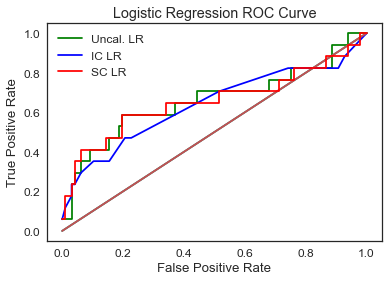

In [79]:
# LR with no calibration
logrn = LogisticRegression(class_weight='balanced')
logrn.fit(X1_train, y1_train)  
prob_pos_logrn1 = logrn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated Log Reg model:', round(roc_auc_score(y1_test, prob_pos_logrn1),4))

# LR with isotonic calibration
logr_isotonic = CalibratedClassifierCV(logrn, cv=2, method='isotonic')
logr_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotoniclogr = logr_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated Log Reg model:', round(roc_auc_score(y1_test, prob_pos_isotoniclogr),4))

# LR with sigmoid calibration
logr_sigmoid = CalibratedClassifierCV(logrn, cv=2, method='sigmoid')
logr_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidlogr = logr_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Log Reg model:', round(roc_auc_score(y1_test, prob_pos_sigmoidlogr),4))

print("\nBrier scores: (the smaller the better)")

logrn_score = brier_score_loss(y1_test, prob_pos_logrn1, sw_test)
print("No calibration: %1.3f" % logrn_score)

logr_isotonic_score = brier_score_loss(y1_test, prob_pos_isotoniclogr, sw_test)
print("With isotonic calibration: %1.3f" % logr_isotonic_score)

logr_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidlogr, sw_test)
print("With sigmoid calibration: %1.3f" % logr_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_logrn1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. LR', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotoniclogr)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC LR', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidlogr)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC LR', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

plt.legend()
plt.show()

#Log reg seems pretty stable. All about even.

In [80]:
logrn_pred = logrn.predict(X_test)
print(classification_report(y_test,logrn_pred))
print(confusion_matrix(y_test, logrn_pred))

logriso_pred = logr_isotonic.predict(X_test)
print(classification_report(y_test,logriso_pred))
print(confusion_matrix(y_test, logriso_pred))

logrsig_pred = logr_sigmoid.predict(X_test)
print(classification_report(y_test,logrsig_pred))
print(confusion_matrix(y_test, logrsig_pred))

             precision    recall  f1-score   support

          0       0.90      0.66      0.76        97
          1       0.23      0.59      0.33        17

avg / total       0.80      0.65      0.70       114

[[64 33]
 [ 7 10]]
             precision    recall  f1-score   support

          0       0.89      0.77      0.83        97
          1       0.27      0.47      0.34        17

avg / total       0.80      0.73      0.76       114

[[75 22]
 [ 9  8]]
             precision    recall  f1-score   support

          0       0.91      0.71      0.80        97
          1       0.26      0.59      0.36        17

avg / total       0.81      0.69      0.73       114

[[69 28]
 [ 7 10]]


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training data: 0.847
Accuracy on test data: 0.851
             precision    recall  f1-score   support

          0       0.85      1.00      0.92        97
          1       0.00      0.00      0.00        17

avg / total       0.72      0.85      0.78       114

[[97  0]
 [17  0]]
AU-ROC score for MLP model: 0.3808


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


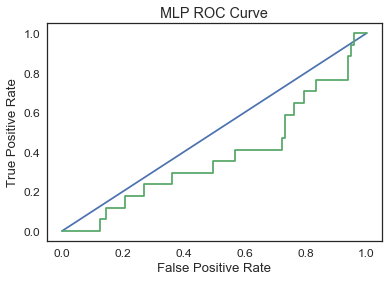

In [81]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
my_pred = mlp.predict(X_test)
print('Accuracy on training data:',round(mlp.score(X_train, y_train),3))
print('Accuracy on test data:',round(mlp.score(X_test, y_test),3))
print(classification_report(y_test,my_pred))
print(confusion_matrix(y_test,my_pred))

my_pred_prob = mlp.predict_proba(X_test)[:,1]
print('AU-ROC score for MLP model:', round(roc_auc_score(y_test, my_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, my_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.show()

AU-ROC score for uncalibrated MLP model: 0.6434
AU-ROC score for isotonically calibrated MLP model: 0.6458
AU-ROC score for sigmoid calibrated MLP model: 0.6701

Brier scores: (the smaller the better)
No calibration: 0.232
With isotonic calibration: 0.238
With sigmoid calibration: 0.235


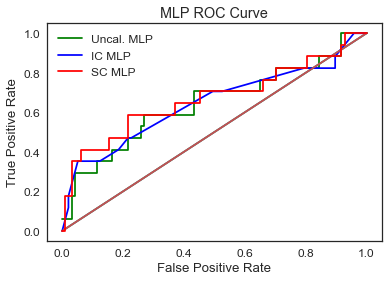

In [82]:
# MLP with no calibration
mlpn = LogisticRegression()
mlpn.fit(X1_train, y1_train)  
prob_pos_mlpn1 = mlpn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated MLP model:', round(roc_auc_score(y1_test, prob_pos_mlpn1),4))

# MLP with isotonic calibration
mlp_isotonic = CalibratedClassifierCV(mlpn, cv=2, method='isotonic')
mlp_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicmlp = mlp_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated MLP model:', round(roc_auc_score(y1_test, prob_pos_isotonicmlp),4))

# MLP with sigmoid calibration
mlp_sigmoid = CalibratedClassifierCV(mlpn, cv=2, method='sigmoid')
mlp_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidmlp = mlp_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated MLP model:', round(roc_auc_score(y1_test, prob_pos_sigmoidmlp),4))

print("\nBrier scores: (the smaller the better)")

mlpn_score = brier_score_loss(y1_test, prob_pos_mlpn1, sw_test)
print("No calibration: %1.3f" % logrn_score)

mlp_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicmlp, sw_test)
print("With isotonic calibration: %1.3f" % mlp_isotonic_score)

mlp_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidmlp, sw_test)
print("With sigmoid calibration: %1.3f" % mlp_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_mlpn1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. MLP', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicmlp)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC MLP', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidmlp)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC MLP', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')

plt.legend()
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on training data: 0.159
Accuracy on test data: 0.175
             precision    recall  f1-score   support

          0       1.00      0.03      0.06        97
          1       0.15      1.00      0.27        17

avg / total       0.87      0.18      0.09       114

[[ 3 94]
 [ 0 17]]
AU-ROC score for GNB model: 0.7144


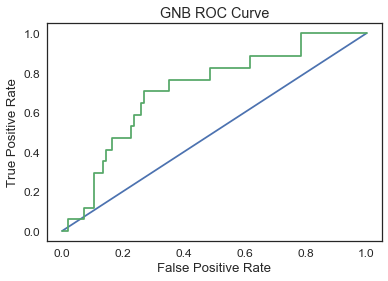

In [83]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gy_pred = gnb.predict(X_test)
print('Accuracy on training data:',round(gnb.score(X_train, y_train),3))
print('Accuracy on test data:',round(gnb.score(X_test, y_test),3))
print(classification_report(y_test,gy_pred))
print(confusion_matrix(y_test,gy_pred))

gy_pred_prob = gnb.predict_proba(X_test)[:,1]
print('AU-ROC score for GNB model:', round(roc_auc_score(y_test, gy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='GNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GNB ROC Curve')
plt.show()

AU-ROC score for uncalibrated GNB model: 0.7144
AU-ROC score for isotonically calibrated GNB model: 0.7126
AU-ROC score for sigmoid calibrated GNB model: 0.6919

Brier scores: (the smaller the better)
No calibration: 0.481
With isotonic calibration: 0.217
With sigmoid calibration: 0.236


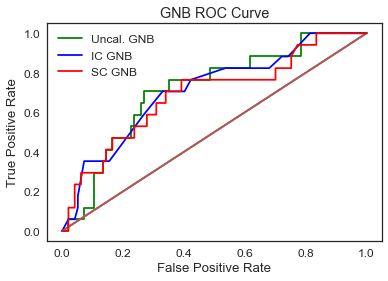

Accuracy on training data: 0.159
Accuracy on test data: 0.175
Accuracy on training data: 0.644
Accuracy on test data: 0.64
Accuracy on training data: 0.476
Accuracy on test data: 0.474


In [84]:
# GNB with no calibration
gnbn = GaussianNB()
gnbn.fit(X1_train, y1_train)  
prob_pos_gnbn1 = gnbn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated GNB model:', round(roc_auc_score(y1_test, prob_pos_gnbn1),4))

# GNB with isotonic calibration
gnb_isotonic = CalibratedClassifierCV(gnbn, cv=2, method='isotonic')
gnb_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicgnb = gnb_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated GNB model:', round(roc_auc_score(y1_test, prob_pos_isotonicgnb),4))

# GNB with sigmoid calibration
gnb_sigmoid = CalibratedClassifierCV(gnbn, cv=2, method='sigmoid')
gnb_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidgnb = gnb_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated GNB model:', round(roc_auc_score(y1_test, prob_pos_sigmoidgnb),4))

print("\nBrier scores: (the smaller the better)")

gnbn_score = brier_score_loss(y1_test, prob_pos_gnbn1, sw_test)
print("No calibration: %1.3f" % gnbn_score)

gnb_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicgnb, sw_test)
print("With isotonic calibration: %1.3f" % gnb_isotonic_score)

gnb_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidgnb, sw_test)
print("With sigmoid calibration: %1.3f" % gnb_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_gnbn1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. GNB', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicgnb)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC GNB', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidgnb)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC GNB', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GNB ROC Curve')

plt.legend()
plt.show()

print('Accuracy on training data:',round(gnbn.score(X_train, y_train),3))
print('Accuracy on test data:',round(gnbn.score(X_test, y_test),3))
print('Accuracy on training data:',round(gnb_isotonic.score(X_train, y_train),3))
print('Accuracy on test data:',round(gnb_isotonic.score(X_test, y_test),3))
print('Accuracy on training data:',round(gnb_sigmoid.score(X_train, y_train),3))
print('Accuracy on test data:',round(gnb_sigmoid.score(X_test, y_test),3))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy on training data: 0.847
Accuracy on test data: 0.851
             precision    recall  f1-score   support

          0       0.85      1.00      0.92        97
          1       0.00      0.00      0.00        17

avg / total       0.72      0.85      0.78       114

[[97  0]
 [17  0]]
AU-ROC score for MNB model: 0.6889


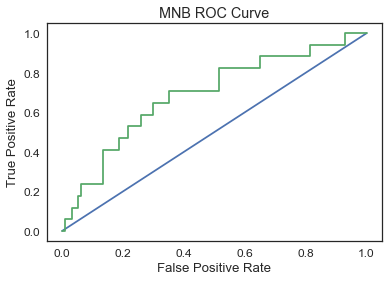

In [85]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mny_pred = mnb.predict(X_test)
print('Accuracy on training data:',round(mnb.score(X_train, y_train),3))
print('Accuracy on test data:',round(mnb.score(X_test, y_test),3))
print(classification_report(y_test,mny_pred))
print(confusion_matrix(y_test,mny_pred))

mny_pred_prob = mnb.predict_proba(X_test)[:,1]
print('AU-ROC score for MNB model:', round(roc_auc_score(y_test, mny_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, mny_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='MNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MNB ROC Curve')
plt.show()

AU-ROC score for uncalibrated MNB model: 0.6889
AU-ROC score for isotonically calibrated MNB model: 0.7068
AU-ROC score for sigmoid calibrated MNB model: 0.718

Brier scores: (the smaller the better)
No calibration: 0.338
With isotonic calibration: 0.234
With sigmoid calibration: 0.234


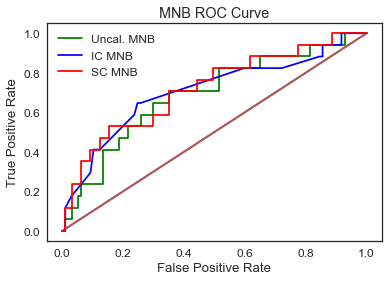

Accuracy on training data: 0.847
Accuracy on test data: 0.851
Accuracy on training data: 0.45
Accuracy on test data: 0.465
Accuracy on training data: 0.671
Accuracy on test data: 0.675


In [86]:
# MNB with no calibration
mnbn = MultinomialNB()
mnbn.fit(X1_train, y1_train)  
prob_pos_mnbn1 = mnbn.predict_proba(X1_test)[:, 1]
print('AU-ROC score for uncalibrated MNB model:', round(roc_auc_score(y1_test, prob_pos_mnbn1),4))

# MNB with isotonic calibration
mnb_isotonic = CalibratedClassifierCV(mnbn, cv=2, method='isotonic')
mnb_isotonic.fit(X1_train, y1_train, sw_train)
prob_pos_isotonicmnb = mnb_isotonic.predict_proba(X1_test)[:, 1]
print('AU-ROC score for isotonically calibrated MNB model:', round(roc_auc_score(y1_test, prob_pos_isotonicmnb),4))

# MNB with sigmoid calibration
mnb_sigmoid = CalibratedClassifierCV(mnbn, cv=2, method='sigmoid')
mnb_sigmoid.fit(X1_train, y1_train, sw_train)
prob_pos_sigmoidmnb = mnb_sigmoid.predict_proba(X1_test)[:, 1]
print('AU-ROC score for sigmoid calibrated MNB model:', round(roc_auc_score(y1_test, prob_pos_sigmoidmnb),4))

print("\nBrier scores: (the smaller the better)")

mnbn_score = brier_score_loss(y1_test, prob_pos_mnbn1, sw_test)
print("No calibration: %1.3f" % mnbn_score)

mnb_isotonic_score = brier_score_loss(y1_test, prob_pos_isotonicmnb, sw_test)
print("With isotonic calibration: %1.3f" % mnb_isotonic_score)

mnb_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoidmnb, sw_test)
print("With sigmoid calibration: %1.3f" % mnb_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(y_test, prob_pos_mnbn1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. MNB', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(y_test, prob_pos_isotonicmnb)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC MNB', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(y_test, prob_pos_sigmoidmnb)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC MNB', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MNB ROC Curve')

plt.legend()
plt.show()

print('Accuracy on training data:',round(mnbn.score(X_train, y_train),3))
print('Accuracy on test data:',round(mnbn.score(X_test, y_test),3))
print('Accuracy on training data:',round(mnb_isotonic.score(X_train, y_train),3))
print('Accuracy on test data:',round(mnb_isotonic.score(X_test, y_test),3))
print('Accuracy on training data:',round(mnb_sigmoid.score(X_train, y_train),3))
print('Accuracy on test data:',round(mnb_sigmoid.score(X_test, y_test),3))

## Feature importance

### PCA of how features and sample variance

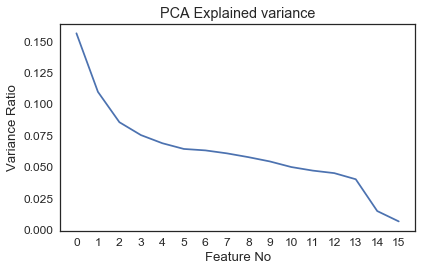

In [87]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea', 'Cough', 
            'Weakness', 'Tumor_size', 'T2DM', 'MI', 'PAD', 'Smoking', 'Asthma', 'Age']

xpca = X.loc[:, features].values
xpcas = StandardScaler().fit_transform(xpca)

pca = PCA()
pca.fit(xpcas, y)
plt.plot(pca.explained_variance_ratio_)
plt.xticks(np.arange(16))
plt.xlabel('Feature No')
plt.ylabel('Variance Ratio')
plt.title('PCA Explained variance')
plt.tight_layout()
plt.show()

In [88]:
print(pca.explained_variance_ratio_)
print(pca.components_.shape) #components, features
print(pca.components_)


[ 0.15649648  0.10983173  0.08561147  0.07536487  0.06885687  0.06430407
  0.06316034  0.06080219  0.05777881  0.05435432  0.04988273  0.04703848
  0.04503022  0.04015073  0.01478803  0.00654866]
(16, 16)
[[ 0.10111737  0.43269553  0.46094852 -0.41788346 -0.04250725 -0.18148276
  -0.02261264 -0.36483261 -0.30424207 -0.06909171 -0.11392388 -0.03229108
  -0.06834659 -0.15097319 -0.00194555 -0.32903875]
 [ 0.04129878 -0.47645684 -0.43458068 -0.43737364 -0.04231249 -0.0119751
  -0.16392449 -0.43025235 -0.19042274 -0.20584515  0.11177459 -0.03581349
  -0.01123806 -0.2186187   0.1506647   0.11906156]
 [-0.12362546  0.01053826 -0.00210914 -0.02261709  0.55422987  0.49694096
   0.39127904 -0.0951689  -0.24980188  0.29370565  0.04312432 -0.17140531
   0.12412885 -0.2680915  -0.02485647  0.00314533]
 [ 0.65481518  0.13687573  0.15071349  0.12443335  0.22548383  0.04756799
  -0.07197011 -0.06079478  0.24868712 -0.2954566   0.27249829 -0.09247555
  -0.03661601 -0.28978673 -0.14053925  0.33953975]


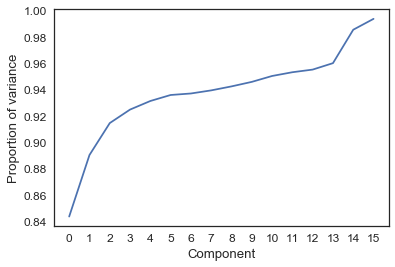

In [89]:

ev_df = pd.DataFrame(pca.explained_variance_ratio_) #this set of values does not easily move around, so doing like this
ev_df['Ratio'] = pca.explained_variance_ratio_
ev_df['Feature'] = X.columns.values


plt.plot(1-(ev_df['Ratio']))
plt.xticks(np.arange(16))
plt.xlabel('Component')
plt.ylabel('Proportion of variance')
plt.show()


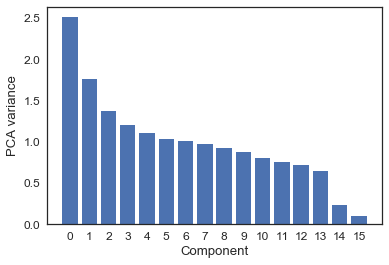

In [90]:
components = range(pca.n_components_)
plt.bar(components, pca.explained_variance_)
plt.xticks(components)
plt.ylabel('PCA variance')
plt.xlabel('Component')
plt.show()

(454, 14)


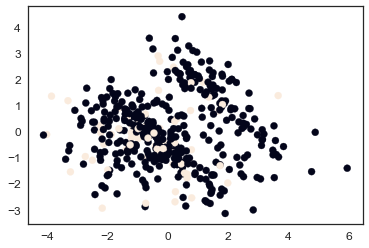

In [91]:
pcadr = PCA(n_components=14)
pcadr.fit(xpcas)
pcatransformed = pcadr.transform(xpcas)
print(pcatransformed.shape)

xs = pcatransformed[:,0]
ys = pcatransformed[:,1]
#zs = pcatransformed[:,2]


plt.scatter(xs,ys, c=y)
plt.show()

### Decision tree features

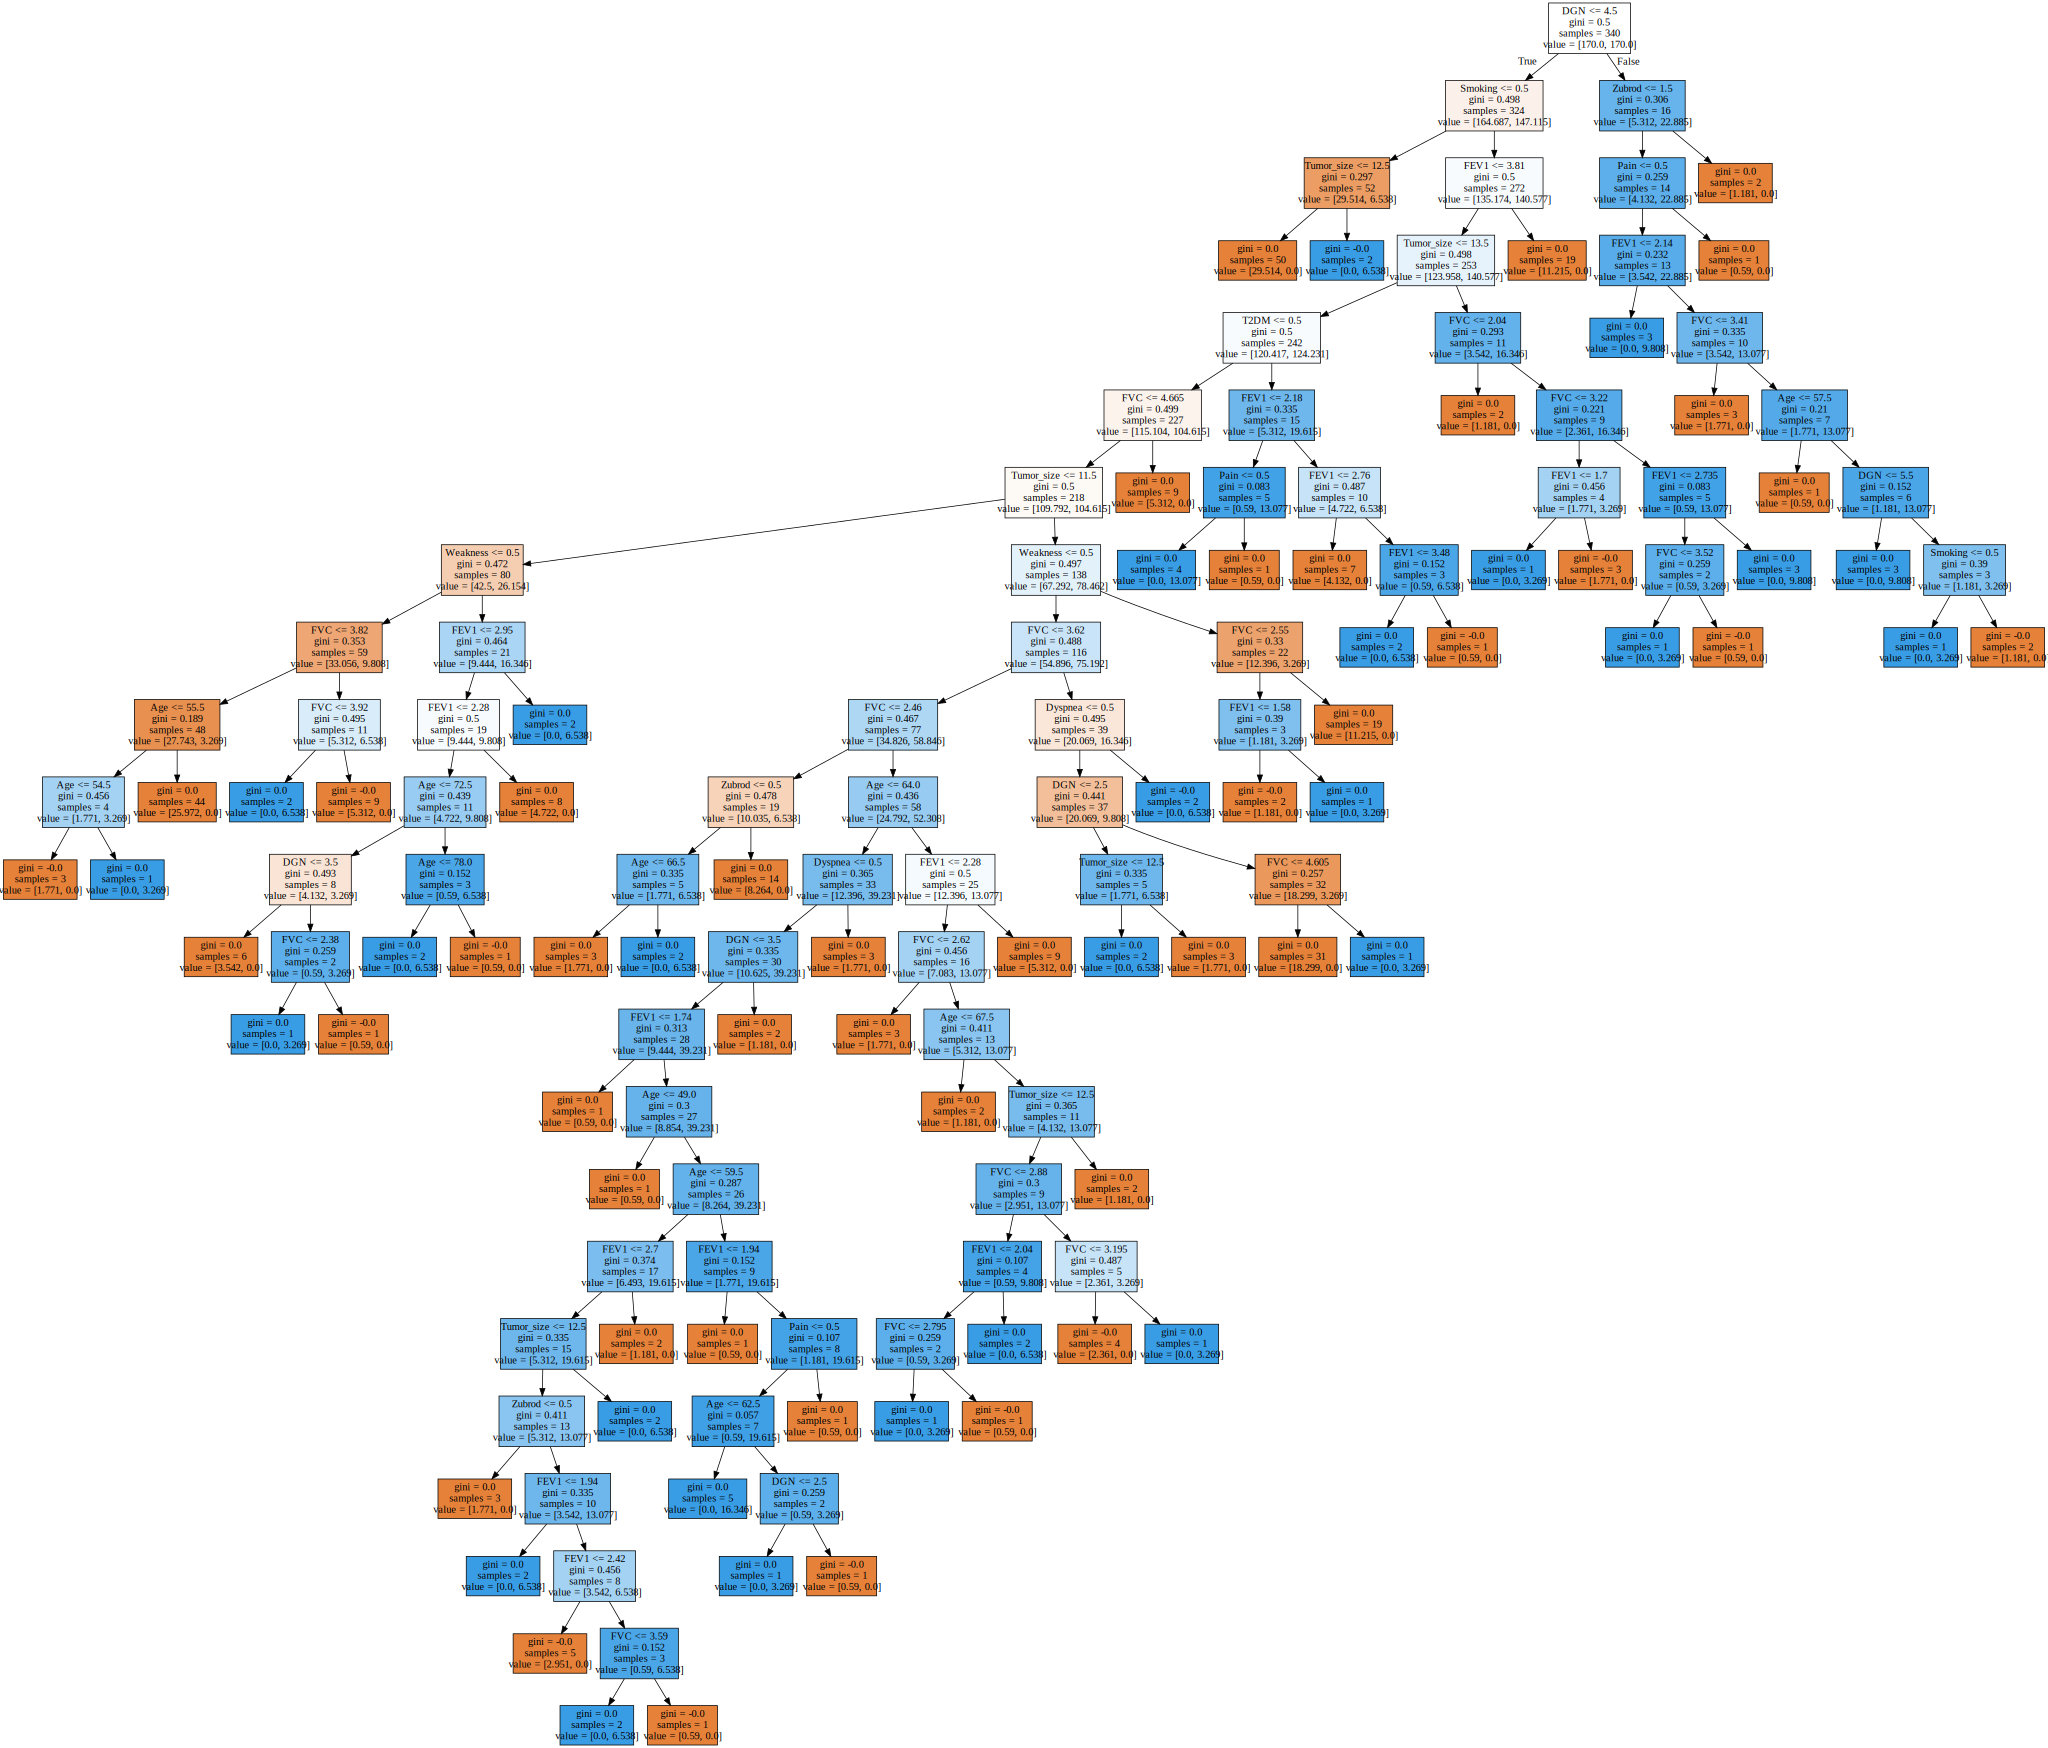

In [92]:
graph_inline = graphviz.Source(dt_data1)  
graph_inline 

### XGBoost feature importance

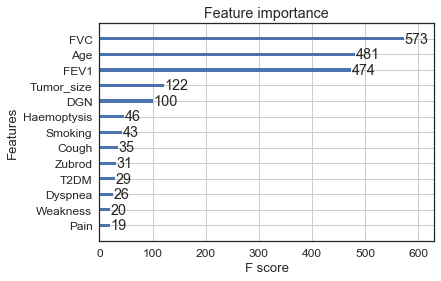

             precision    recall  f1-score   support

          0       0.85      0.97      0.91        97
          1       0.25      0.06      0.10        17

avg / total       0.76      0.83      0.79       114



In [93]:
#based on test data because connected to model above
plot_importance(xgbo)
plt.show()
print(classification_report(y_test,predictionsx))

### Logistic regression training set feature evaluation

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 0.4487456  -0.09744402 -0.13967109 -0.07246023  0.31792025  0.46884443
   1.03684181  0.39694592  0.34394688  0.41818144  1.21370288 -1.52492462
  -1.02983718  1.2945946  -0.61509545 -0.01726476]]


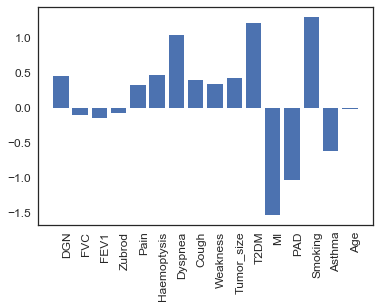

In [94]:
x = np.arange(16)
mco = LogisticRegression(class_weight='balanced', C=10)
mco.fit(X_train, y_train)
#mco.fit(X / np.std(X, 0), y)

print(mco.coef_[0:1])

#coef seems unreshapable or unflattenable
#y_bars = np.asmatrix(mco.coef_[0:1])

y_bars = [0.4487456,  -0.09744402, -0.13967109, -0.07246023,  0.31792025,  0.46884443, 1.03684181,  0.39694592,
          0.34394688,  0.41818144,  1.21370288, -1.52492462, -1.02983718,  1.2945946,  -0.61509545, -0.01726476]

plt.bar(x, y_bars)
plt.xticks(np.arange(16)+0.3,X[1:],rotation="vertical")
plt.show()

[[ 0.28353949 -0.84631368 -0.17639994 -0.49565107  1.97944965  0.16912114
   2.6024765   0.99167997  0.86102227  0.68317789  0.20808802 -0.70701556
   2.33194111 -0.09544998 -1.14440839 -0.04523057]]


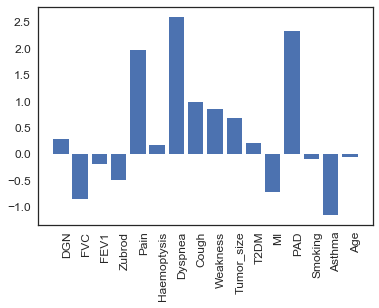

In [95]:
x = np.arange(16)
mcot = LogisticRegression(class_weight='balanced', C=10)
mcot.fit(X_test, y_test)
#mco.fit(X / np.std(X, 0), y)

print(mcot.coef_[0:1])

#coef seems unreshapable or unflattenable
#y_bars = np.asmatrix(mco.coef_[0:1])

y_bars = [0.28353949,  -0.84631368, -0.17639994, -0.49565107,  1.97944965,  0.16912114, 2.6024765,  0.99167997,
          0.86102227,  0.68317789,  0.20808802, -0.70701556, 2.33194111,  -0.09544998,  -1.14440839, -0.04523057]

plt.bar(x, y_bars)
plt.xticks(np.arange(16)+0.3,X[1:],rotation="vertical")
plt.show()

### Feature importance by several classifiers

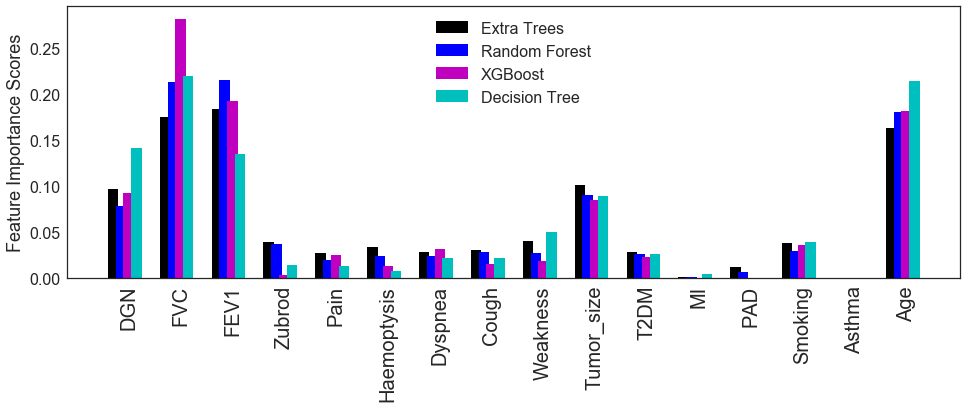

In [96]:
# from https://bibinmjose.github.io/Enron_find_fraud/ 

classifiers = [("Extra Trees",ExtraTreesClassifier(class_weight='balanced', n_estimators=300)),
               ("Random Forest",RandomForestClassifier(class_weight='balanced', n_estimators=300)),
               ("XGBoost",XGBClassifier()),
               ("Decision Tree",DecisionTreeClassifier(class_weight='balanced'))] 
COLORS = 'kbmc'

width_bar =0.2
fig=plt.figure(figsize=(16,5))
for i, (name, clf) in enumerate(classifiers):
    clf.fit(X,y)
    imp = clf.feature_importances_
    plt.bar(np.arange(16)+(0.75*width_bar)*(i),imp, \
            width=width_bar, color=COLORS[i], label = name)
plt.xticks(np.arange(16)+0.3,X[1:],rotation="vertical", fontsize=20)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylabel("Feature Importance Scores", fontsize=18)
plt.show()

## Model interpretability based on SHAP values

### XGBoost

#### XGBoost "Pred_contribs" on test data

In [97]:
from xgboost import XGBClassifier, DMatrix

#test_size = 0.2
#Xnp = np.asarray(X)
#ynp = np.asarray(y)
#ynp = np.asarray(thoracic_df.Risk1Y)
X_test.columns = ['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea', 'Cough', 
                       'Weakness', 'Tumor_size', 'T2DM', 'MI', 'PAD', 'Smoking', 'Asthma', 'Age']
Xnp = np.asarray(X_test)
ynp = np.asarray(y_test)
print(Xnp.shape)
#xgbpred = XGBClassifier()
#X51_train, X51_test, y51_train, y51_test = train_test_split(Xnp, ynp, test_size=test_size, random_state=29)
xgbpredtest = XGBClassifier()
xgbpredtest.fit(Xnp, ynp)
boostertest = xgbpredtest.get_booster()
# Using only a single sample for predict, you can use multiple
test_X = [Xnp[0]]
#print(ynp)
# Wrapping the test X into a DMatrix, need by Booster
predictionstest = boostertest.predict(DMatrix(test_X), pred_contribs=True)

print(predictionstest.shape)
print(predictionstest)
print(predictionstest.sum())

predictionsdf = pd.DataFrame(predictionstest)
sumpred = predictionstest.sum()
predictionsdf['sum'] = pd.Series(sumpred, index=predictionsdf.index)
predictionsdf.columns=['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea', 'Cough', 
                       'Weakness', 'Tumor_size', 'T2DM', 'MI', 'PAD', 'Smoking', 'Asthma', 'Age', 'bias', 'SUM']
display(HTML(predictionsdf.to_html(index=False)))

predictionssidedf = predictionsdf.T
#sample == 0
predictionssidedf.columns = ['prediction contributions']
display(HTML(predictionssidedf.to_html(index=True)))


(114, 16)
(1, 17)
[[-0.04883727 -0.02367285 -0.12147561 -0.1299631   0.         -0.00990301
  -0.0776338  -0.13940886 -0.15102896 -0.83278203  0.          0.          0.
  -0.0026633   0.         -0.80803013 -1.90080559]]
-4.2462


#### SHAP package with XGBoost on test data

In [98]:
#X.columns = ['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea', 'Cough', 'Weakness', 'Tumor_size', 'T2DM', 'MI', 'PAD', 'Smoking', 'Asthma', 'Age']

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
#X50_train, X50_test, y50_train, y50_test = train_test_split(Xu, yu, test_size=0.2, random_state=7)
xgb50_train = xgboost.DMatrix(X_train, label=y_train)
xgb50_test = xgboost.DMatrix(X_test, label=y_test)
# use validation set to choose # of trees
#params = {"eta": 0.002,"max_depth": 3,"objective": "survival:cox","subsample": 0.5}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
#model_train = xgboost.train(xgb50_train, 500, evals = [(xgb50_test, "test")])
#model = xgboost.train(params, xgb_full, 100, evals = [(xgb_full, "test")])

# train XGBoost model; integer in xgboost.train is number of iterations; 500 and 800 gave same answer. 400, 100 didn't.
#X,y = shap.datasets.boston()
#model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 500)

In [99]:
# load JS visualization code to notebook
shap.initjs() 

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(model).shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(shap_values[0,:], X_test.iloc[0,:])

In [94]:
print(X_test.iloc[0])
print(y_test.iloc[0])
print(X_test.iloc[4])
print(y_test.iloc[4]) 
print(X_test.iloc[1]) 
print(y_test.iloc[1])

DGN             3.00
FVC             2.92
FEV1            2.32
Zubrod          0.00
Pain            0.00
Haemoptysis     0.00
Dyspnea         0.00
Cough           0.00
Weakness        0.00
Tumor_size     11.00
T2DM            0.00
MI              0.00
PAD             0.00
Smoking         1.00
Asthma          0.00
Age            54.00
Name: 257, dtype: float64
0
DGN             3.00
FVC             3.24
FEV1            2.64
Zubrod          0.00
Pain            0.00
Haemoptysis     0.00
Dyspnea         0.00
Cough           1.00
Weakness        0.00
Tumor_size     11.00
T2DM            0.00
MI              0.00
PAD             0.00
Smoking         1.00
Asthma          0.00
Age            69.00
Name: 237, dtype: float64
0
DGN             3.00
FVC             2.68
FEV1            2.40
Zubrod          0.00
Pain            0.00
Haemoptysis     0.00
Dyspnea         0.00
Cough           0.00
Weakness        0.00
Tumor_size     11.00
T2DM            0.00
MI              0.00
PAD             0.00

In [100]:
#shap.force_plot(shap_values, X)
shap.force_plot(shap_values, X_test)

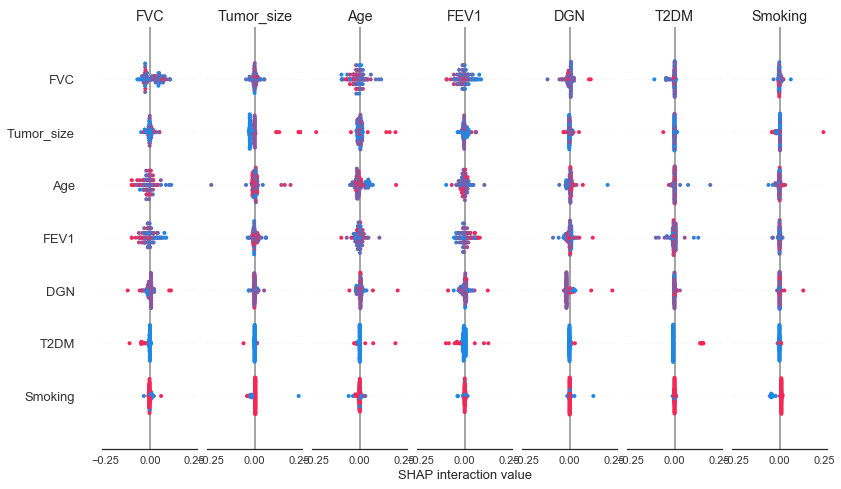

In [101]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)

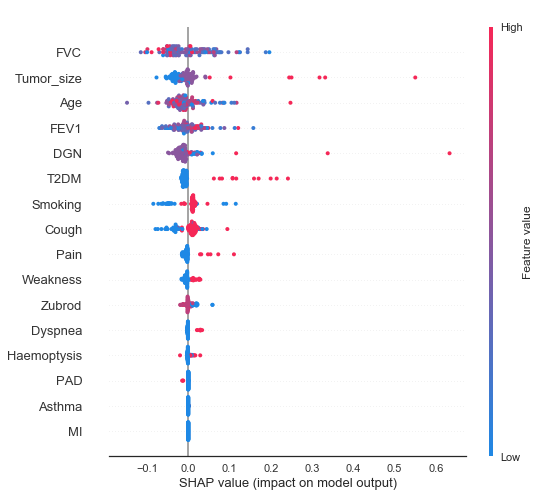

In [102]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

#### SHAP package with Random Forest on test data

In [104]:
rfs = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfs.fit(X_train, y_train)

shap_values = shap.KernelExplainer(rfs.predict_proba, X_train).shap_values(X_test.iloc[0,:])
shap.force_plot(shap_values[0], X_test.iloc[0,:])

#looks a lot more accurate than with xgboost potentially; left is 1 and right is 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [105]:
rsy_pred_prob = rfs.predict_proba(X_test)[:,1]
print('AU-ROC score:', round(roc_auc_score(y_test, rsy_pred_prob),4))


#print(X_test.iloc[0])
#print(y_test.iloc[0])
#print(X_test.iloc[4])
#print(y_test.iloc[4]) 
#print(X_test.iloc[20]) 
#print(y_test.iloc[20])

AU-ROC score: 0.7535


In [115]:
#shap.force_plot(shap_values, X)
shap_values = shap.KernelExplainer(rfs.predict_proba, X_train).shap_values(X_test)
shap.force_plot(shap_values[0], X_test)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 114/114 [1:36:59<00:00, 51.05s/it]


In [106]:
shap_values = shap.KernelExplainer(rfs.predict_proba, X_train).shap_values(X_test.iloc[0:1000,:],nsamples=1000)
shap.force_plot(shap_values[0], X_test.iloc[0:1000,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 114/114 [37:43<00:00, 19.86s/it]


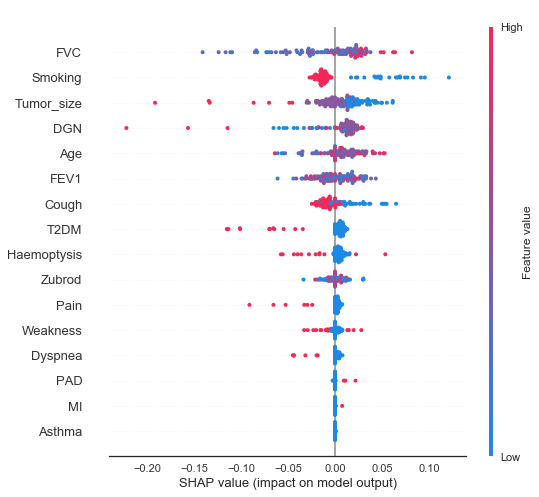

In [107]:
shap.summary_plot(shap_values[0], X_test)

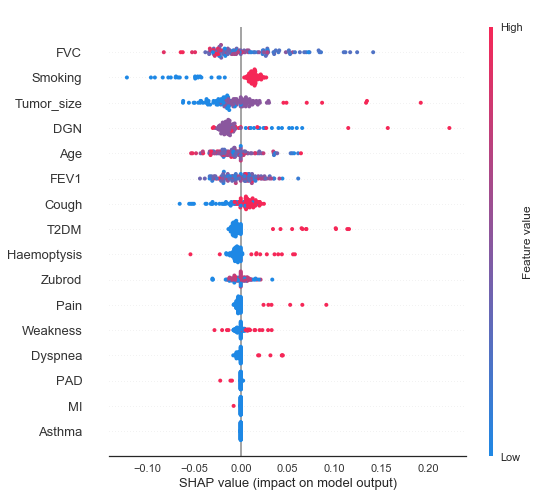

In [108]:
shap.summary_plot(shap_values[1], X_test)

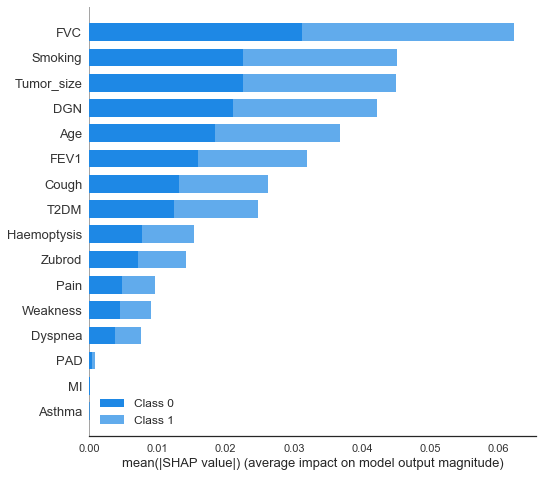

In [109]:
shap.summary_plot(shap_values, X_test)

#### SHAP package with Decision Tree on test data

In [110]:
dts = DecisionTreeClassifier(class_weight='balanced')
dts.fit(X_train, y_train)

shap_values = shap.KernelExplainer(dts.predict_proba, X_train).shap_values(X_test.iloc[7,:])
shap.force_plot(shap_values[0], X_test.iloc[7,:])

#looks a lot more accurate than with both rf and xgboost potentially; left is 1 and right is 0
#dt gives prediction of 1.00 for survival for survivor and 0.00 for non-survivor - more decisive than the others.
#tumor size of 11 is still complex - in a survivor it's part of survival prediction and in non-survivor it's
#part of non-survival prediction. 

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [111]:
dsy_pred_prob = dts.predict_proba(X_test)[:,1]
print('AU-ROC score:', round(roc_auc_score(y_test, dsy_pred_prob), 4))

AU-ROC score: 0.7565


In [598]:
dtsIndiv_pred = dts.predict(X_test)
print(list(zip(y_test,dtsIndiv_pred)))
print(confusion_matrix(y_test, dtsIndiv_pred))

[(0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 1), (0, 1), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (0, 0), (1, 0), (0, 0), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0)]
[[80 17]
 [ 7 10]]


In [150]:
#shap.force_plot(shap_values, X)
shap_values = shap.KernelExplainer(dts.predict_proba, X_train).shap_values(X_test)
shap.force_plot(shap_values[0], X_test)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 114/114 [40:06<00:00, 21.11s/it]


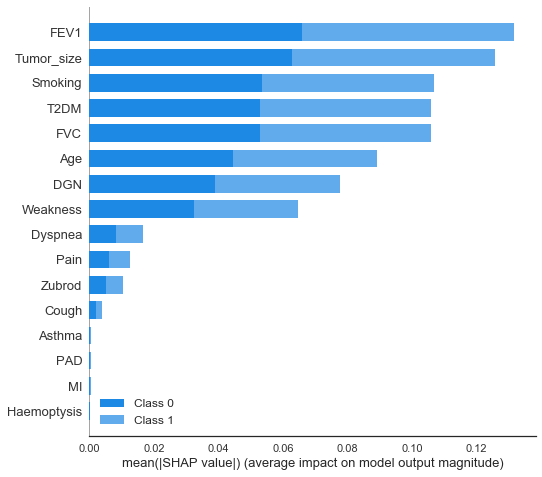

In [151]:
shap.summary_plot(shap_values, X_test)

In [112]:
#X_train_df = pd.DataFrame(X_train)
#X_test_df = pd.DataFrame(X_test)
shap_values_single = shap.KernelExplainer(dts.predict_proba, X_train).shap_values(X_test.iloc[0,:],nsamples=500)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [193]:
shap.force_plot(shap_values[0], X_test)

In [195]:
shap_values = shap.KernelExplainer(dts.predict_proba, X_train).shap_values(X_test.iloc[0:1000,:],nsamples=1000)
shap.force_plot(shap_values[0], X_test.iloc[0:1000,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 114/114 [19:24<00:00, 10.22s/it]


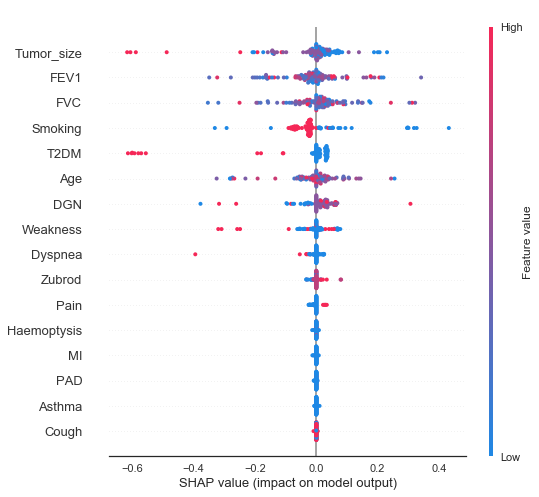

In [201]:
shap.summary_plot(shap_values[0], X_test)

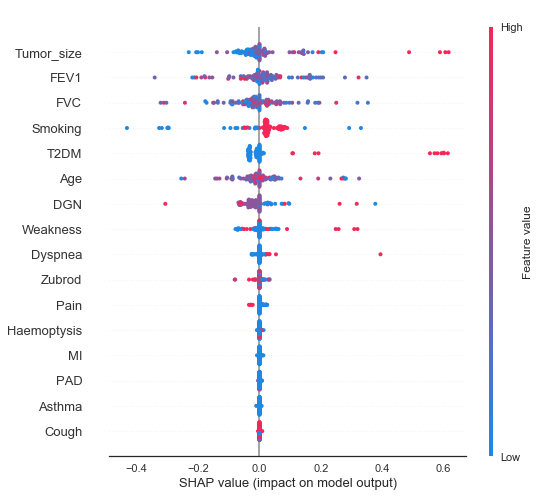

In [202]:
shap.summary_plot(shap_values[1], X_test)

### Removal of key features

#### No Age

In [113]:
X_noAge = X.drop('Age', axis = 1)


X2_train_noAge, X2_test_noAge, y2_train, y2_test, sw2_train, sw2_test = \
    train_test_split(X_noAge, y, sw, random_state=100, stratify=y)


##### Extra trees

In [114]:
# ET with no calibration
etnA = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnA.fit(X2_train_noAge, y2_train)  
prob_pos_et2 = etnA.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y2_test, prob_pos_et2),4))

# ET with isotonic calibration
et_isotonic2 = CalibratedClassifierCV(etnA, cv=2, method='isotonic')
et_isotonic2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_isotonic2et = et_isotonic2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y2_test, prob_pos_isotonic2et),4))

# ET with sigmoid calibration
et_sigmoid2 = CalibratedClassifierCV(etnA, cv=2, method='sigmoid')
et_sigmoid2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_sigmoid2et = et_sigmoid2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y2_test, prob_pos_sigmoid2et),4))

print('Accuracy on training data:',round(etnA.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(etnA.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(et_isotonic2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(et_isotonic2.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(et_sigmoid2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(et_sigmoid2.score(X2_test_noAge, y2_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7095
AU-ROC score for isotonically calibrated Extra Trees model: 0.755
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7016
Accuracy on training data: 1.0
Accuracy on test data: 0.825
Accuracy on training data: 0.991
Accuracy on test data: 0.658
Accuracy on training data: 0.909
Accuracy on test data: 0.711


##### Random forest

In [115]:
# RF with no calibration
rfnA = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnA.fit(X2_train_noAge, y2_train)  
prob_pos_rf2 = rfnA.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y2_test, prob_pos_rf2),4))

# RF with isotonic calibration
rf_isotonic2 = CalibratedClassifierCV(rfnA, cv=2, method='isotonic')
rf_isotonic2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_isotonic2rf = rf_isotonic2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y2_test, prob_pos_isotonic2rf),4))

# RF with sigmoid calibration
rf_sigmoid2 = CalibratedClassifierCV(rfnA, cv=2, method='sigmoid')
rf_sigmoid2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_sigmoid2rf = rf_sigmoid2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y2_test, prob_pos_sigmoid2rf),4))

print('Accuracy on training data:',round(rfnA.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(rfnA.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(rf_isotonic2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(rf_isotonic2.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(rf_sigmoid2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(rf_sigmoid2.score(X2_test_noAge, y2_test),3))

AU-ROC score for uncalibrated RF model: 0.7514
AU-ROC score for isotonically calibrated RF model: 0.7529
AU-ROC score for sigmoid calibrated RF model: 0.7256
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.856
Accuracy on test data: 0.711
Accuracy on training data: 0.879
Accuracy on test data: 0.711


##### XGBoost

In [116]:
# XG with no calibration
xgnA = XGBClassifier()
xgnA.fit(X2_train_noAge, y2_train)  
prob_pos_xg2 = xgnA.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y2_test, prob_pos_xg2),4))

# XG with isotonic calibration
xg_isotonic2 = CalibratedClassifierCV(xgnA, cv=2, method='isotonic')
xg_isotonic2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_isotonic2xg = xg_isotonic2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y2_test, prob_pos_isotonic2xg),4))

# XG with sigmoid calibration
xg_sigmoid2 = CalibratedClassifierCV(xgnA, cv=2, method='sigmoid')
xg_sigmoid2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_sigmoid2xg = xg_sigmoid2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y2_test, prob_pos_sigmoid2xg),4))

print('Accuracy on training data:',round(xgnA.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(xgnA.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(xg_isotonic2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(xg_isotonic2.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(xg_sigmoid2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(xg_sigmoid2.score(X2_test_noAge, y2_test),3))

AU-ROC score for uncalibrated XGB model: 0.614
AU-ROC score for isotonically calibrated XGB model: 0.6222
AU-ROC score for sigmoid calibrated XGB model: 0.6683
Accuracy on training data: 0.894
Accuracy on test data: 0.842
Accuracy on training data: 0.568
Accuracy on test data: 0.57
Accuracy on training data: 0.862
Accuracy on test data: 0.807


##### Decision tree

In [117]:
# DT with no calibration
dtnA = DecisionTreeClassifier(class_weight='balanced')
dtnA.fit(X2_train_noAge, y2_train)  
prob_pos_dt2 = dtnA.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y2_test, prob_pos_dt2),4))

# DT with isotonic calibration
dt_isotonic2 = CalibratedClassifierCV(dtnA, cv=2, method='isotonic')
dt_isotonic2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_isotonic2dt = dt_isotonic2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y2_test, prob_pos_isotonic2dt),4))

# DT with sigmoid calibration
dt_sigmoid2 = CalibratedClassifierCV(dtnA, cv=2, method='sigmoid')
dt_sigmoid2.fit(X2_train_noAge, y2_train, sw2_train)
prob_pos_sigmoid2dt = dt_sigmoid2.predict_proba(X2_test_noAge)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y2_test, prob_pos_sigmoid2dt),4))

print('Accuracy on training data:',round(dtnA.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(dtnA.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(dt_isotonic2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(dt_isotonic2.score(X2_test_noAge, y2_test),3))
print('Accuracy on training data:',round(dt_sigmoid2.score(X2_train_noAge, y2_train),3))
print('Accuracy on test data:',round(dt_sigmoid2.score(X2_test_noAge, y2_test),3))

AU-ROC score for uncalibrated DT model: 0.7859
AU-ROC score for isotonically calibrated DT model: 0.6413
AU-ROC score for sigmoid calibrated DT model: 0.6231
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.9
Accuracy on test data: 0.833
Accuracy on training data: 0.903
Accuracy on test data: 0.746


#### No tumor size

In [118]:
X_noTS = X.drop('Tumor_size', axis = 1)


X3_train_noTS, X3_test_noTS, y3_train, y3_test, sw3_train, sw3_test = \
    train_test_split(X_noTS, y, sw, random_state=100, stratify=y)

##### Extra trees

In [119]:
# ET with no calibration
etnTS = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnTS.fit(X3_train_noTS, y3_train)  
prob_pos_et3 = etnTS.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y3_test, prob_pos_et3),4))

# ET with isotonic calibration
et_isotonic3 = CalibratedClassifierCV(etnTS, cv=2, method='isotonic')
et_isotonic3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_isotonic3et = et_isotonic3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y3_test, prob_pos_isotonic3et),4))

# ET with sigmoid calibration
et_sigmoid3 = CalibratedClassifierCV(etnTS, cv=2, method='sigmoid')
et_sigmoid3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_sigmoid3et = et_sigmoid3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y3_test, prob_pos_sigmoid3et),4))

print('Accuracy on training data:',round(etnTS.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(etnTS.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(et_isotonic3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(et_isotonic3.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(et_sigmoid3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(et_sigmoid3.score(X3_test_noTS, y3_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.5952
AU-ROC score for isotonically calibrated Extra Trees model: 0.6334
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6176
Accuracy on training data: 1.0
Accuracy on test data: 0.825
Accuracy on training data: 0.994
Accuracy on test data: 0.632
Accuracy on training data: 0.941
Accuracy on test data: 0.772


##### Random forest

In [120]:
# RF with no calibration
rfnTS = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnTS.fit(X3_train_noTS, y3_train)  
prob_pos_rf3 = rfnTS.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y3_test, prob_pos_rf3),4))

# RF with isotonic calibration
rf_isotonic3 = CalibratedClassifierCV(rfnTS, cv=2, method='isotonic')
rf_isotonic3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_isotonic3rf = rf_isotonic3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y3_test, prob_pos_isotonic3rf),4))

# RF with sigmoid calibration
rf_sigmoid3 = CalibratedClassifierCV(rfnTS, cv=2, method='sigmoid')
rf_sigmoid3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_sigmoid3rf = rf_sigmoid3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y3_test, prob_pos_sigmoid3rf),4))

print('Accuracy on training data:',round(rfnTS.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(rfnTS.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(rf_isotonic3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(rf_isotonic3.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(rf_sigmoid3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(rf_sigmoid3.score(X3_test_noTS, y3_test),3))

AU-ROC score for uncalibrated RF model: 0.6283
AU-ROC score for isotonically calibrated RF model: 0.6683
AU-ROC score for sigmoid calibrated RF model: 0.6519
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.912
Accuracy on test data: 0.816
Accuracy on training data: 0.929
Accuracy on test data: 0.737


##### XGBoost

In [121]:
# XG with no calibration
xgnTS = XGBClassifier()
xgnTS.fit(X3_train_noTS, y3_train)  
prob_pos_xg3 = xgnTS.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y3_test, prob_pos_xg3),4))

# XG with isotonic calibration
xg_isotonic3 = CalibratedClassifierCV(xgnTS, cv=2, method='isotonic')
xg_isotonic3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_isotonic3xg = xg_isotonic3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y3_test, prob_pos_isotonic3xg),4))

# XG with sigmoid calibration
xg_sigmoid3 = CalibratedClassifierCV(xgnTS, cv=2, method='sigmoid')
xg_sigmoid3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_sigmoid3xg = xg_sigmoid3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y3_test, prob_pos_sigmoid3xg),4))

print('Accuracy on training data:',round(xgnTS.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(xgnTS.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(xg_isotonic3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(xg_isotonic3.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(xg_sigmoid3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(xg_sigmoid3.score(X3_test_noTS, y3_test),3))

AU-ROC score for uncalibrated XGB model: 0.6331
AU-ROC score for isotonically calibrated XGB model: 0.5479
AU-ROC score for sigmoid calibrated XGB model: 0.3851
Accuracy on training data: 0.885
Accuracy on test data: 0.851
Accuracy on training data: 0.394
Accuracy on test data: 0.368
Accuracy on training data: 0.647
Accuracy on test data: 0.632


##### Decision tree

In [122]:
# DT with no calibration
dtnTS = DecisionTreeClassifier(class_weight='balanced')
dtnTS.fit(X3_train_noTS, y3_train)  
prob_pos_dt3 = dtnTS.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y3_test, prob_pos_dt3),4))

# DT with isotonic calibration
dt_isotonic3 = CalibratedClassifierCV(dtnTS, cv=2, method='isotonic')
dt_isotonic3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_isotonic3dt = dt_isotonic3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y3_test, prob_pos_isotonic3dt),4))

# DT with sigmoid calibration
dt_sigmoid3 = CalibratedClassifierCV(dtnTS, cv=2, method='sigmoid')
dt_sigmoid3.fit(X3_train_noTS, y3_train, sw3_train)
prob_pos_sigmoid3dt = dt_sigmoid3.predict_proba(X3_test_noTS)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y3_test, prob_pos_sigmoid3dt),4))

print('Accuracy on training data:',round(dtnTS.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(dtnTS.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(dt_isotonic3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(dt_isotonic3.score(X3_test_noTS, y3_test),3))
print('Accuracy on training data:',round(dt_sigmoid3.score(X3_train_noTS, y3_train),3))
print('Accuracy on test data:',round(dt_sigmoid3.score(X3_test_noTS, y3_test),3))

AU-ROC score for uncalibrated DT model: 0.6146
AU-ROC score for isotonically calibrated DT model: 0.5646
AU-ROC score for sigmoid calibrated DT model: 0.456
Accuracy on training data: 1.0
Accuracy on test data: 0.798
Accuracy on training data: 0.847
Accuracy on test data: 0.851
Accuracy on training data: 0.874
Accuracy on test data: 0.772


#### No diagnosis code

In [123]:
X_noDGN = X.drop('DGN', axis = 1)


X4_train_noDGN, X4_test_noDGN, y4_train, y4_test, sw4_train, sw4_test = \
    train_test_split(X_noDGN, y, sw, random_state=100, stratify=y)

##### Extra trees

In [124]:
# ET with no calibration
etnDGN = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnDGN.fit(X4_train_noDGN, y4_train)  
prob_pos_et4 = etnDGN.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y4_test, prob_pos_et4),4))

# ET with isotonic calibration
et_isotonic4 = CalibratedClassifierCV(etnDGN, cv=2, method='isotonic')
et_isotonic4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_isotonic4et = et_isotonic4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y4_test, prob_pos_isotonic4et),4))

# ET with sigmoid calibration
et_sigmoid4 = CalibratedClassifierCV(etnDGN, cv=2, method='sigmoid')
et_sigmoid4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_sigmoid4et = et_sigmoid4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y4_test, prob_pos_sigmoid4et),4))

print('Accuracy on training data:',round(etnDGN.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(etnDGN.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(et_isotonic4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(et_isotonic4.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(et_sigmoid4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(et_sigmoid4.score(X4_test_noDGN, y4_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7126
AU-ROC score for isotonically calibrated Extra Trees model: 0.6653
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6719
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.988
Accuracy on test data: 0.509
Accuracy on training data: 0.856
Accuracy on test data: 0.728


##### Random forest

In [125]:
# RF with no calibration
rfnDGN = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnDGN.fit(X4_train_noDGN, y4_train)  
prob_pos_rf4 = rfnDGN.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y4_test, prob_pos_rf4),4))

# RF with isotonic calibration
rf_isotonic4 = CalibratedClassifierCV(rfnDGN, cv=2, method='isotonic')
rf_isotonic4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_isotonic4rf = rf_isotonic4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y4_test, prob_pos_isotonic4rf),4))

# RF with sigmoid calibration
rf_sigmoid4 = CalibratedClassifierCV(rfnDGN, cv=2, method='sigmoid')
rf_sigmoid4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_sigmoid4rf = rf_sigmoid4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y4_test, prob_pos_sigmoid4rf),4))

print('Accuracy on training data:',round(rfnDGN.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(rfnDGN.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(rf_isotonic4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(rf_isotonic4.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(rf_sigmoid4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(rf_sigmoid4.score(X4_test_noDGN, y4_test),3))

AU-ROC score for uncalibrated RF model: 0.7244
AU-ROC score for isotonically calibrated RF model: 0.6995
AU-ROC score for sigmoid calibrated RF model: 0.6367
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.818
Accuracy on test data: 0.675
Accuracy on training data: 0.962
Accuracy on test data: 0.833


##### XGBoost

In [126]:
# XG with no calibration
xgnDGN = XGBClassifier()
xgnDGN.fit(X4_train_noDGN, y4_train)  
prob_pos_xg4 = xgnDGN.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y4_test, prob_pos_xg4),4))

# XG with isotonic calibration
xg_isotonic4 = CalibratedClassifierCV(xgnDGN, cv=2, method='isotonic')
xg_isotonic4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_isotonic4xg = xg_isotonic4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y4_test, prob_pos_isotonic4xg),4))

# XG with sigmoid calibration
xg_sigmoid4 = CalibratedClassifierCV(xgnDGN, cv=2, method='sigmoid')
xg_sigmoid4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_sigmoid4xg = xg_sigmoid4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y4_test, prob_pos_sigmoid4xg),4))

print('Accuracy on training data:',round(xgnDGN.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(xgnDGN.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(xg_isotonic4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(xg_isotonic4.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(xg_sigmoid4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(xg_sigmoid4.score(X4_test_noDGN, y4_test),3))

AU-ROC score for uncalibrated XGB model: 0.6295
AU-ROC score for isotonically calibrated XGB model: 0.6771
AU-ROC score for sigmoid calibrated XGB model: 0.2547
Accuracy on training data: 0.891
Accuracy on test data: 0.851
Accuracy on training data: 0.3
Accuracy on test data: 0.333
Accuracy on training data: 0.585
Accuracy on test data: 0.535


##### Decision tree

In [127]:
# DT with no calibration
dtnDGN = DecisionTreeClassifier(class_weight='balanced')
dtnDGN.fit(X4_train_noDGN, y4_train)  
prob_pos_dt4 = dtnDGN.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y4_test, prob_pos_dt4),4))

# DT with isotonic calibration
dt_isotonic4 = CalibratedClassifierCV(dtnDGN, cv=2, method='isotonic')
dt_isotonic4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_isotonic4dt = dt_isotonic4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y4_test, prob_pos_isotonic4dt),4))

# DT with sigmoid calibration
dt_sigmoid4 = CalibratedClassifierCV(dtnDGN, cv=2, method='sigmoid')
dt_sigmoid4.fit(X4_train_noDGN, y4_train, sw4_train)
prob_pos_sigmoid4dt = dt_sigmoid4.predict_proba(X4_test_noDGN)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y4_test, prob_pos_sigmoid4dt),4))

print('Accuracy on training data:',round(dtnDGN.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(dtnDGN.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(dt_isotonic4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(dt_isotonic4.score(X4_test_noDGN, y4_test),3))
print('Accuracy on training data:',round(dt_sigmoid4.score(X4_train_noDGN, y4_train),3))
print('Accuracy on test data:',round(dt_sigmoid4.score(X4_test_noDGN, y4_test),3))

AU-ROC score for uncalibrated DT model: 0.4903
AU-ROC score for isotonically calibrated DT model: 0.5558
AU-ROC score for sigmoid calibrated DT model: 0.4864
Accuracy on training data: 1.0
Accuracy on test data: 0.711
Accuracy on training data: 0.847
Accuracy on test data: 0.851
Accuracy on training data: 0.874
Accuracy on test data: 0.772


#### No FVC

In [128]:
X_noFVC = X.drop('FVC', axis = 1)


X5_train_noFVC, X5_test_noFVC, y5_train, y5_test, sw5_train, sw5_test = \
    train_test_split(X_noFVC, y, sw, random_state=100, stratify=y)

##### Extra trees

In [129]:
# ET with no calibration
etnFVC = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnFVC.fit(X5_train_noFVC, y5_train)  
prob_pos_et5 = etnFVC.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y5_test, prob_pos_et5),4))

# ET with isotonic calibration
et_isotonic5 = CalibratedClassifierCV(etnFVC, cv=2, method='isotonic')
et_isotonic5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_isotonic5et = et_isotonic5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y5_test, prob_pos_isotonic5et),4))

# ET with sigmoid calibration
et_sigmoid5 = CalibratedClassifierCV(etnFVC, cv=2, method='sigmoid')
et_sigmoid5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_sigmoid5et = et_sigmoid5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y5_test, prob_pos_sigmoid5et),4))

print('Accuracy on training data:',round(etnFVC.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(etnFVC.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(et_isotonic5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(et_isotonic5.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(et_sigmoid5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(et_sigmoid5.score(X5_test_noFVC, y5_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6962
AU-ROC score for isotonically calibrated Extra Trees model: 0.7053
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6634
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 0.947
Accuracy on test data: 0.561
Accuracy on training data: 0.921
Accuracy on test data: 0.702


##### Random forest

In [130]:
# RF with no calibration
rfnFVC = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnFVC.fit(X5_train_noFVC, y5_train)  
prob_pos_rf5 = rfnFVC.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y5_test, prob_pos_rf5),4))

# RF with isotonic calibration
rf_isotonic5 = CalibratedClassifierCV(rfnFVC, cv=2, method='isotonic')
rf_isotonic5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_isotonic5rf = rf_isotonic5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y5_test, prob_pos_isotonic5rf),4))

# RF with sigmoid calibration
rf_sigmoid5 = CalibratedClassifierCV(rfnFVC, cv=2, method='sigmoid')
rf_sigmoid5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_sigmoid5rf = rf_sigmoid5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y5_test, prob_pos_sigmoid5rf),4))

print('Accuracy on training data:',round(rfnFVC.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(rfnFVC.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(rf_isotonic5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(rf_isotonic5.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(rf_sigmoid5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(rf_sigmoid5.score(X5_test_noFVC, y5_test),3))

AU-ROC score for uncalibrated RF model: 0.6756
AU-ROC score for isotonically calibrated RF model: 0.7395
AU-ROC score for sigmoid calibrated RF model: 0.6768
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.712
Accuracy on test data: 0.561
Accuracy on training data: 0.906
Accuracy on test data: 0.728


##### XGBoost

In [131]:
# XG with no calibration
xgnFVC = XGBClassifier()
xgnFVC.fit(X5_train_noFVC, y5_train)  
prob_pos_xg5 = xgnFVC.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y5_test, prob_pos_xg5),4))

# XG with isotonic calibration
xg_isotonic5 = CalibratedClassifierCV(xgnFVC, cv=2, method='isotonic')
xg_isotonic5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_isotonic5xg = xg_isotonic5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y5_test, prob_pos_isotonic5xg),4))

# XG with sigmoid calibration
xg_sigmoid5 = CalibratedClassifierCV(xgnFVC, cv=2, method='sigmoid')
xg_sigmoid5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_sigmoid5xg = xg_sigmoid5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y5_test, prob_pos_sigmoid5xg),4))

print('Accuracy on training data:',round(xgnFVC.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(xgnFVC.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(xg_isotonic5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(xg_isotonic5.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(xg_sigmoid5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(xg_sigmoid5.score(X5_test_noFVC, y5_test),3))

AU-ROC score for uncalibrated XGB model: 0.6643
AU-ROC score for isotonically calibrated XGB model: 0.6862
AU-ROC score for sigmoid calibrated XGB model: 0.7283
Accuracy on training data: 0.894
Accuracy on test data: 0.86
Accuracy on training data: 0.438
Accuracy on test data: 0.447
Accuracy on training data: 0.806
Accuracy on test data: 0.746


##### Decision tree

In [132]:
# DT with no calibration
dtnFVC = DecisionTreeClassifier(class_weight='balanced')
dtnFVC.fit(X5_train_noFVC, y5_train)  
prob_pos_dt5 = dtnFVC.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y5_test, prob_pos_dt5),4))

# DT with isotonic calibration
dt_isotonic5 = CalibratedClassifierCV(dtnFVC, cv=2, method='isotonic')
dt_isotonic5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_isotonic5dt = dt_isotonic5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y5_test, prob_pos_isotonic5dt),4))

# DT with sigmoid calibration
dt_sigmoid5 = CalibratedClassifierCV(dtnFVC, cv=2, method='sigmoid')
dt_sigmoid5.fit(X5_train_noFVC, y5_train, sw5_train)
prob_pos_sigmoid5dt = dt_sigmoid5.predict_proba(X5_test_noFVC)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y5_test, prob_pos_sigmoid5dt),4))

print('Accuracy on training data:',round(dtnFVC.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(dtnFVC.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(dt_isotonic5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(dt_isotonic5.score(X5_test_noFVC, y5_test),3))
print('Accuracy on training data:',round(dt_sigmoid5.score(X5_train_noFVC, y5_train),3))
print('Accuracy on test data:',round(dt_sigmoid5.score(X5_test_noFVC, y5_test),3))

AU-ROC score for uncalibrated XGB model: 0.594
AU-ROC score for isotonically calibrated XGB model: 0.5
AU-ROC score for sigmoid calibrated XGB model: 0.4688
Accuracy on training data: 1.0
Accuracy on test data: 0.763
Accuracy on training data: 0.847
Accuracy on test data: 0.851
Accuracy on training data: 0.129
Accuracy on test data: 0.272


#### No FEV1

In [133]:
X_noFEV1 = X.drop('FEV1', axis = 1)


X6_train_noFEV1, X6_test_noFEV1, y6_train, y6_test, sw6_train, sw6_test = \
    train_test_split(X_noFEV1, y, sw, random_state=100, stratify=y)

##### Extra trees

In [134]:
# ET with no calibration
etnFEV1 = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnFEV1.fit(X6_train_noFEV1, y6_train)  
prob_pos_et6 = etnFEV1.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y6_test, prob_pos_et6),4))

# ET with isotonic calibration
et_isotonic6 = CalibratedClassifierCV(etnFEV1, cv=2, method='isotonic')
et_isotonic6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_isotonic6et = et_isotonic6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y6_test, prob_pos_isotonic6et),4))

# ET with sigmoid calibration
et_sigmoid6 = CalibratedClassifierCV(etnFEV1, cv=2, method='sigmoid')
et_sigmoid6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_sigmoid6et = et_sigmoid6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y6_test, prob_pos_sigmoid6et),4))

print('Accuracy on training data:',round(etnFEV1.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(etnFEV1.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(et_isotonic6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(et_isotonic6.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(et_sigmoid6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(et_sigmoid6.score(X6_test_noFEV1, y6_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6386
AU-ROC score for isotonically calibrated Extra Trees model: 0.6962
AU-ROC score for sigmoid calibrated Extra Trees model: 0.611
Accuracy on training data: 0.997
Accuracy on test data: 0.825
Accuracy on training data: 0.985
Accuracy on test data: 0.684
Accuracy on training data: 0.9
Accuracy on test data: 0.64


##### Random forest

In [135]:
# RF with no calibration
rfnFEV1 = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnFEV1.fit(X6_train_noFEV1, y6_train)  
prob_pos_rf6 = rfnFEV1.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y6_test, prob_pos_rf6),4))

# RF with isotonic calibration
rf_isotonic6 = CalibratedClassifierCV(rfnFEV1, cv=2, method='isotonic')
rf_isotonic6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_isotonic6rf = rf_isotonic6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y6_test, prob_pos_isotonic6rf),4))

# RF with sigmoid calibration
rf_sigmoid6 = CalibratedClassifierCV(rfnFEV1, cv=2, method='sigmoid')
rf_sigmoid6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_sigmoid6rf = rf_sigmoid6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y6_test, prob_pos_sigmoid6rf),4))

print('Accuracy on training data:',round(rfnFEV1.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(rfnFEV1.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(rf_isotonic6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(rf_isotonic6.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(rf_sigmoid6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(rf_sigmoid6.score(X6_test_noFEV1, y6_test),3))

AU-ROC score for uncalibrated RF model: 0.675
AU-ROC score for isotonically calibrated RF model: 0.7035
AU-ROC score for sigmoid calibrated RF model: 0.661
Accuracy on training data: 0.997
Accuracy on test data: 0.842
Accuracy on training data: 0.809
Accuracy on test data: 0.649
Accuracy on training data: 0.915
Accuracy on test data: 0.737


##### XGBoost

In [136]:
# XG with no calibration
xgnFEV1 = XGBClassifier()
xgnFEV1.fit(X6_train_noFEV1, y6_train)  
prob_pos_xg6 = xgnFEV1.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y6_test, prob_pos_xg6),4))

# XG with isotonic calibration
xg_isotonic6 = CalibratedClassifierCV(xgnFEV1, cv=2, method='isotonic')
xg_isotonic6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_isotonic6xg = xg_isotonic6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y6_test, prob_pos_isotonic6xg),4))

# XG with sigmoid calibration
xg_sigmoid6 = CalibratedClassifierCV(xgnFEV1, cv=2, method='sigmoid')
xg_sigmoid6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_sigmoid6xg = xg_sigmoid6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y6_test, prob_pos_sigmoid6xg),4))

print('Accuracy on training data:',round(xgnFEV1.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(xgnFEV1.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(xg_isotonic6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(xg_isotonic6.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(xg_sigmoid6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(xg_sigmoid6.score(X6_test_noFEV1, y6_test),3))

AU-ROC score for uncalibrated XGB model: 0.6134
AU-ROC score for isotonically calibrated XGB model: 0.6413
AU-ROC score for sigmoid calibrated XGB model: 0.621
Accuracy on training data: 0.891
Accuracy on test data: 0.851
Accuracy on training data: 0.55
Accuracy on test data: 0.561
Accuracy on training data: 0.859
Accuracy on test data: 0.807


##### Decision tree

In [137]:
# DT with no calibration
dtnFEV1 = DecisionTreeClassifier(class_weight='balanced')
dtnFEV1.fit(X6_train_noFEV1, y6_train)  
prob_pos_dt6 = dtnFEV1.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y6_test, prob_pos_dt6),4))

# DT with isotonic calibration
dt_isotonic6 = CalibratedClassifierCV(dtnFEV1, cv=2, method='isotonic')
dt_isotonic6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_isotonic6dt = dt_isotonic6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y6_test, prob_pos_isotonic6dt),4))

# DT with sigmoid calibration
dt_sigmoid6 = CalibratedClassifierCV(dtnFEV1, cv=2, method='sigmoid')
dt_sigmoid6.fit(X6_train_noFEV1, y6_train, sw6_train)
prob_pos_sigmoid6dt = dt_sigmoid6.predict_proba(X6_test_noFEV1)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y6_test, prob_pos_sigmoid6dt),4))

print('Accuracy on training data:',round(dtnFEV1.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(dtnFEV1.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(dt_isotonic6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(dt_isotonic6.score(X6_test_noFEV1, y6_test),3))
print('Accuracy on training data:',round(dt_sigmoid6.score(X6_train_noFEV1, y6_train),3))
print('Accuracy on test data:',round(dt_sigmoid6.score(X6_test_noFEV1, y6_test),3))

AU-ROC score for uncalibrated DT model: 0.6874
AU-ROC score for isotonically calibrated DT model: 0.5764
AU-ROC score for sigmoid calibrated DT model: 0.4542
Accuracy on training data: 0.997
Accuracy on test data: 0.798
Accuracy on training data: 0.891
Accuracy on test data: 0.816
Accuracy on training data: 0.853
Accuracy on test data: 0.719


#### No smoking

In [138]:
X_noSm = X.drop('Smoking', axis = 1)


X7_train_noSm, X7_test_noSm, y7_train, y7_test, sw7_train, sw7_test = \
    train_test_split(X_noSm, y, sw, random_state=100, stratify=y)

##### Extra trees

In [139]:
# ET with no calibration
etnSm = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnSm.fit(X7_train_noSm, y7_train)  
prob_pos_et7 = etnSm.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y7_test, prob_pos_et7),4))

# ET with isotonic calibration
et_isotonic7 = CalibratedClassifierCV(etnSm, cv=2, method='isotonic')
et_isotonic7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_isotonic7et = et_isotonic7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y7_test, prob_pos_isotonic7et),4))

# ET with sigmoid calibration
et_sigmoid7 = CalibratedClassifierCV(etnSm, cv=2, method='sigmoid')
et_sigmoid7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_sigmoid7et = et_sigmoid7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y7_test, prob_pos_sigmoid7et),4))

print('Accuracy on training data:',round(etnSm.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(etnSm.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(et_isotonic7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(et_isotonic7.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(et_sigmoid7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(et_sigmoid7.score(X7_test_noSm, y7_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7107
AU-ROC score for isotonically calibrated Extra Trees model: 0.7041
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7156
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.962
Accuracy on test data: 0.57
Accuracy on training data: 0.929
Accuracy on test data: 0.772


##### Random forest

In [140]:
# RF with no calibration
rfnSm = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnSm.fit(X7_train_noSm, y7_train)  
prob_pos_rf7 = rfnSm.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y7_test, prob_pos_rf7),4))

# RF with isotonic calibration
rf_isotonic7 = CalibratedClassifierCV(rfnSm, cv=2, method='isotonic')
rf_isotonic7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_isotonic7rf = rf_isotonic7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y7_test, prob_pos_isotonic7rf),4))

# RF with sigmoid calibration
rf_sigmoid7 = CalibratedClassifierCV(rfnSm, cv=2, method='sigmoid')
rf_sigmoid7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_sigmoid7rf = rf_sigmoid7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y7_test, prob_pos_sigmoid7rf),4))

print('Accuracy on training data:',round(rfnSm.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(rfnSm.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(rf_isotonic7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(rf_isotonic7.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(rf_sigmoid7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(rf_sigmoid7.score(X7_test_noSm, y7_test),3))

AU-ROC score for uncalibrated RF model: 0.7292
AU-ROC score for isotonically calibrated RF model: 0.7862
AU-ROC score for sigmoid calibrated RF model: 0.7611
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.726
Accuracy on test data: 0.632
Accuracy on training data: 0.909
Accuracy on test data: 0.789


##### XGBoost

In [141]:
# XG with no calibration
xgnSm = XGBClassifier()
xgnSm.fit(X7_train_noSm, y7_train)  
prob_pos_xg7 = xgnSm.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y7_test, prob_pos_xg7),4))

# XG with isotonic calibration
xg_isotonic7 = CalibratedClassifierCV(xgnSm, cv=2, method='isotonic')
xg_isotonic7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_isotonic7xg = xg_isotonic7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y7_test, prob_pos_isotonic7xg),4))

# XG with sigmoid calibration
xg_sigmoid7 = CalibratedClassifierCV(xgnSm, cv=2, method='sigmoid')
xg_sigmoid7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_sigmoid7xg = xg_sigmoid7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y7_test, prob_pos_sigmoid7xg),4))

print('Accuracy on training data:',round(xgnSm.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(xgnSm.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(xg_isotonic7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(xg_isotonic7.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(xg_sigmoid7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(xg_sigmoid7.score(X7_test_noSm, y7_test),3))

AU-ROC score for uncalibrated XGB model: 0.7107
AU-ROC score for isotonically calibrated XGB model: 0.7429
AU-ROC score for sigmoid calibrated XGB model: 0.7338
Accuracy on training data: 0.891
Accuracy on test data: 0.842
Accuracy on training data: 0.671
Accuracy on test data: 0.693
Accuracy on training data: 0.882
Accuracy on test data: 0.798


##### Decision tree

In [142]:
# DT with no calibration
dtnSm = DecisionTreeClassifier(class_weight='balanced')
dtnSm.fit(X7_train_noSm, y7_train)  
prob_pos_dt7 = dtnSm.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y7_test, prob_pos_dt7),4))

# DT with isotonic calibration
dt_isotonic7 = CalibratedClassifierCV(dtnSm, cv=2, method='isotonic')
dt_isotonic7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_isotonic7dt = dt_isotonic7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y7_test, prob_pos_isotonic7dt),4))

# DT with sigmoid calibration
dt_sigmoid7 = CalibratedClassifierCV(dtnSm, cv=2, method='sigmoid')
dt_sigmoid7.fit(X7_train_noSm, y7_train, sw7_train)
prob_pos_sigmoid7dt = dt_sigmoid7.predict_proba(X7_test_noSm)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y7_test, prob_pos_sigmoid7dt),4))

print('Accuracy on training data:',round(dtnSm.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(dtnSm.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(dt_isotonic7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(dt_isotonic7.score(X7_test_noSm, y7_test),3))
print('Accuracy on training data:',round(dt_sigmoid7.score(X7_train_noSm, y7_train),3))
print('Accuracy on test data:',round(dt_sigmoid7.score(X7_test_noSm, y7_test),3))

AU-ROC score for uncalibrated DT model: 0.5867
AU-ROC score for isotonically calibrated DT model: 0.5315
AU-ROC score for sigmoid calibrated DT model: 0.466
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 0.885
Accuracy on test data: 0.781
Accuracy on training data: 0.888
Accuracy on test data: 0.789


#### No cough

In [143]:
X_noCf = X.drop('Cough', axis = 1)


X8_train_noCf, X8_test_noCf, y8_train, y8_test, sw8_train, sw8_test = \
    train_test_split(X_noCf, y, sw, random_state=100, stratify=y)

##### Extra tree

In [144]:
# ET with no calibration
etnCf = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnCf.fit(X8_train_noCf, y8_train)  
prob_pos_et8 = etnCf.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y8_test, prob_pos_et8),4))

# ET with isotonic calibration
et_isotonic8 = CalibratedClassifierCV(etnCf, cv=2, method='isotonic')
et_isotonic8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_isotonic8et = et_isotonic8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y8_test, prob_pos_isotonic8et),4))

# ET with sigmoid calibration
et_sigmoid8 = CalibratedClassifierCV(etnCf, cv=2, method='sigmoid')
et_sigmoid8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_sigmoid8et = et_sigmoid8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y8_test, prob_pos_sigmoid8et),4))

print('Accuracy on training data:',round(etnCf.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(etnCf.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(et_isotonic8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(et_isotonic8.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(et_sigmoid8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(et_sigmoid8.score(X8_test_noCf, y8_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6837
AU-ROC score for isotonically calibrated Extra Trees model: 0.7277
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6713
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.991
Accuracy on test data: 0.623
Accuracy on training data: 0.924
Accuracy on test data: 0.693


##### Random forest

In [145]:
# RF with no calibration
rfnCf = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnCf.fit(X8_train_noCf, y8_train)  
prob_pos_rf8 = rfnCf.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y8_test, prob_pos_rf8),4))

# RF with isotonic calibration
rf_isotonic8 = CalibratedClassifierCV(rfnCf, cv=2, method='isotonic')
rf_isotonic8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_isotonic8rf = rf_isotonic8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y8_test, prob_pos_isotonic8rf),4))

# RF with sigmoid calibration
rf_sigmoid8 = CalibratedClassifierCV(rfnCf, cv=2, method='sigmoid')
rf_sigmoid8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_sigmoid8rf = rf_sigmoid8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y8_test, prob_pos_sigmoid8rf),4))

print('Accuracy on training data:',round(rfnCf.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(rfnCf.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(rf_isotonic8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(rf_isotonic8.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(rf_sigmoid8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(rf_sigmoid8.score(X8_test_noCf, y8_test),3))

AU-ROC score for uncalibrated RF model: 0.7207
AU-ROC score for isotonically calibrated RF model: 0.6722
AU-ROC score for sigmoid calibrated RF model: 0.6734
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.915
Accuracy on test data: 0.675
Accuracy on training data: 0.894
Accuracy on test data: 0.711


##### XGBoost

In [146]:
# XG with no calibration
xgnCf = XGBClassifier()
xgnCf.fit(X8_train_noCf, y8_train)  
prob_pos_xg8 = xgnCf.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y8_test, prob_pos_xg8),4))

# XG with isotonic calibration
xg_isotonic8 = CalibratedClassifierCV(xgnCf, cv=2, method='isotonic')
xg_isotonic8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_isotonic8xg = xg_isotonic8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y8_test, prob_pos_isotonic8xg),4))

# XG with sigmoid calibration
xg_sigmoid8 = CalibratedClassifierCV(xgnCf, cv=2, method='sigmoid')
xg_sigmoid8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_sigmoid8xg = xg_sigmoid8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y8_test, prob_pos_sigmoid8xg),4))

print('Accuracy on training data:',round(xgnCf.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(xgnCf.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(xg_isotonic8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(xg_isotonic8.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(xg_sigmoid8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(xg_sigmoid8.score(X8_test_noCf, y8_test),3))

AU-ROC score for uncalibrated XGB model: 0.6689
AU-ROC score for isotonically calibrated XGB model: 0.6534
AU-ROC score for sigmoid calibrated XGB model: 0.6422
Accuracy on training data: 0.897
Accuracy on test data: 0.851
Accuracy on training data: 0.524
Accuracy on test data: 0.518
Accuracy on training data: 0.868
Accuracy on test data: 0.754


##### Decision tree

In [147]:
# DT with no calibration
dtnCf = DecisionTreeClassifier(class_weight='balanced')
dtnCf.fit(X8_train_noCf, y8_train)  
prob_pos_dt8 = dtnCf.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y8_test, prob_pos_dt8),4))

# DT with isotonic calibration
dt_isotonic8 = CalibratedClassifierCV(dtnCf, cv=2, method='isotonic')
dt_isotonic8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_isotonic8dt = dt_isotonic8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y8_test, prob_pos_isotonic8dt),4))

# DT with sigmoid calibration
dt_sigmoid8 = CalibratedClassifierCV(dtnSm, cv=2, method='sigmoid')
dt_sigmoid8.fit(X8_train_noCf, y8_train, sw8_train)
prob_pos_sigmoid8dt = dt_sigmoid8.predict_proba(X8_test_noCf)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y8_test, prob_pos_sigmoid8dt),4))

print('Accuracy on training data:',round(dtnCf.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(dtnCf.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(dt_isotonic8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(dt_isotonic8.score(X8_test_noCf, y8_test),3))
print('Accuracy on training data:',round(dt_sigmoid8.score(X8_train_noCf, y8_train),3))
print('Accuracy on test data:',round(dt_sigmoid8.score(X8_test_noCf, y8_test),3))

AU-ROC score for uncalibrated DT model: 0.7514
AU-ROC score for isotonically calibrated DT model: 0.4418
AU-ROC score for sigmoid calibrated DT model: 0.6082
Accuracy on training data: 1.0
Accuracy on test data: 0.825
Accuracy on training data: 0.888
Accuracy on test data: 0.711
Accuracy on training data: 0.868
Accuracy on test data: 0.842


#### No haemoptysis

In [148]:
X_noH = X.drop('Haemoptysis', axis = 1)


X9_train_noH, X9_test_noH, y9_train, y9_test, sw9_train, sw9_test = \
    train_test_split(X_noH, y, sw, random_state=100, stratify=y)

##### Extra trees

In [149]:
# ET with no calibration
etnH = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnH.fit(X9_train_noH, y9_train)  
prob_pos_et9 = etnH.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y9_test, prob_pos_et9),4))

# ET with isotonic calibration
et_isotonic9 = CalibratedClassifierCV(etnH, cv=2, method='isotonic')
et_isotonic9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_isotonic9et = et_isotonic9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y9_test, prob_pos_isotonic9et),4))

# ET with sigmoid calibration
et_sigmoid9 = CalibratedClassifierCV(etnH, cv=2, method='sigmoid')
et_sigmoid9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_sigmoid9et = et_sigmoid9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y9_test, prob_pos_sigmoid9et),4))

print('Accuracy on training data:',round(etnH.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(etnH.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(et_isotonic9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(et_isotonic9.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(et_sigmoid9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(et_sigmoid9.score(X9_test_noH, y9_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7135
AU-ROC score for isotonically calibrated Extra Trees model: 0.789
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7307
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 1.0
Accuracy on test data: 0.711
Accuracy on training data: 0.921
Accuracy on test data: 0.684


##### Random forest

In [150]:
# RF with no calibration
rfnH = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnH.fit(X9_train_noH, y9_train)  
prob_pos_rf9 = rfnH.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y9_test, prob_pos_rf9),4))

# RF with isotonic calibration
rf_isotonic9 = CalibratedClassifierCV(rfnH, cv=2, method='isotonic')
rf_isotonic9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_isotonic9rf = rf_isotonic9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y9_test, prob_pos_isotonic9rf),4))

# RF with sigmoid calibration
rf_sigmoid9 = CalibratedClassifierCV(rfnH, cv=2, method='sigmoid')
rf_sigmoid9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_sigmoid9rf = rf_sigmoid9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y9_test, prob_pos_sigmoid9rf),4))

print('Accuracy on training data:',round(rfnH.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(rfnH.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(rf_isotonic9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(rf_isotonic9.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(rf_sigmoid9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(rf_sigmoid9.score(X9_test_noH, y9_test),3))

AU-ROC score for uncalibrated RF model: 0.7383
AU-ROC score for isotonically calibrated RF model: 0.6765
AU-ROC score for sigmoid calibrated RF model: 0.7132
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.791
Accuracy on test data: 0.605
Accuracy on training data: 0.891
Accuracy on test data: 0.772


##### XGBoost

In [151]:
# XG with no calibration
xgnH = XGBClassifier()
xgnH.fit(X9_train_noH, y9_train)  
prob_pos_xg9 = xgnH.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y9_test, prob_pos_xg9),4))

# XG with isotonic calibration
xg_isotonic9 = CalibratedClassifierCV(xgnH, cv=2, method='isotonic')
xg_isotonic9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_isotonic9xg = xg_isotonic9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y9_test, prob_pos_isotonic9xg),4))

# XG with sigmoid calibration
xg_sigmoid9 = CalibratedClassifierCV(xgnH, cv=2, method='sigmoid')
xg_sigmoid9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_sigmoid9xg = xg_sigmoid9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y9_test, prob_pos_sigmoid9xg),4))

print('Accuracy on training data:',round(xgnH.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(xgnH.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(xg_isotonic9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(xg_isotonic9.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(xg_sigmoid9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(xg_sigmoid9.score(X9_test_noH, y9_test),3))

AU-ROC score for uncalibrated XGB model: 0.6671
AU-ROC score for isotonically calibrated XGB model: 0.6743
AU-ROC score for sigmoid calibrated XGB model: 0.6064
Accuracy on training data: 0.903
Accuracy on test data: 0.851
Accuracy on training data: 0.756
Accuracy on test data: 0.719
Accuracy on training data: 0.885
Accuracy on test data: 0.789


##### Decision tree

In [152]:
# DT with no calibration
dtnH = DecisionTreeClassifier(class_weight='balanced')
dtnH.fit(X9_train_noH, y9_train)  
prob_pos_dt9 = dtnH.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y9_test, prob_pos_dt9),4))

# DT with isotonic calibration
dt_isotonic9 = CalibratedClassifierCV(dtnH, cv=2, method='isotonic')
dt_isotonic9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_isotonic9dt = dt_isotonic9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y9_test, prob_pos_isotonic9dt),4))

# DT with sigmoid calibration
dt_sigmoid9 = CalibratedClassifierCV(dtnH, cv=2, method='sigmoid')
dt_sigmoid9.fit(X9_train_noH, y9_train, sw9_train)
prob_pos_sigmoid9dt = dt_sigmoid9.predict_proba(X9_test_noH)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y9_test, prob_pos_sigmoid9dt),4))

print('Accuracy on training data:',round(dtnH.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(dtnH.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(dt_isotonic9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(dt_isotonic9.score(X9_test_noH, y9_test),3))
print('Accuracy on training data:',round(dt_sigmoid9.score(X9_train_noH, y9_train),3))
print('Accuracy on test data:',round(dt_sigmoid9.score(X9_test_noH, y9_test),3))

AU-ROC score for uncalibrated DT model: 0.7065
AU-ROC score for isotonically calibrated DT model: 0.5522
AU-ROC score for sigmoid calibrated DT model: 0.4924
Accuracy on training data: 1.0
Accuracy on test data: 0.789
Accuracy on training data: 0.897
Accuracy on test data: 0.816
Accuracy on training data: 0.865
Accuracy on test data: 0.807


#### No age AND no haemoptysis

##### Extra trees

In [153]:
X_noAH = X_noAge.drop('Haemoptysis', axis = 1)


X10_train_noAH, X10_test_noAH, y10_train, y10_test, sw10_train, sw10_test = \
    train_test_split(X_noAH, y, sw, random_state=100, stratify=y)

In [154]:
# ET with no calibration
etnAH = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAH.fit(X10_train_noAH, y10_train)  
prob_pos_et10 = etnAH.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y10_test, prob_pos_et10),4))

# ET with isotonic calibration
et_isotonic10 = CalibratedClassifierCV(etnAH, cv=2, method='isotonic')
et_isotonic10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_isotonic10et = et_isotonic10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y10_test, prob_pos_isotonic10et),4))

# ET with sigmoid calibration
et_sigmoid10 = CalibratedClassifierCV(etnAH, cv=2, method='sigmoid')
et_sigmoid10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_sigmoid10et = et_sigmoid10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y10_test, prob_pos_sigmoid10et),4))

print('Accuracy on training data:',round(etnAH.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(etnAH.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(et_isotonic10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(et_isotonic10.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(et_sigmoid10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(et_sigmoid10.score(X10_test_noAH, y10_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7459
AU-ROC score for isotonically calibrated Extra Trees model: 0.7583
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7235
Accuracy on training data: 1.0
Accuracy on test data: 0.807
Accuracy on training data: 0.974
Accuracy on test data: 0.614
Accuracy on training data: 0.906
Accuracy on test data: 0.719


##### Random forest

In [155]:
# RF with no calibration
rfnAH = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAH.fit(X10_train_noAH, y10_train)  
prob_pos_rf10 = rfnAH.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y10_test, prob_pos_rf10),4))

# RF with isotonic calibration
rf_isotonic10 = CalibratedClassifierCV(rfnAH, cv=2, method='isotonic')
rf_isotonic10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_isotonic10rf = rf_isotonic10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y10_test, prob_pos_isotonic10rf),4))

# RF with sigmoid calibration
rf_sigmoid10 = CalibratedClassifierCV(rfnAH, cv=2, method='sigmoid')
rf_sigmoid10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_sigmoid10rf = rf_sigmoid10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y10_test, prob_pos_sigmoid10rf),4))

print('Accuracy on training data:',round(rfnAH.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(rfnAH.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(rf_isotonic10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(rf_isotonic10.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(rf_sigmoid10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(rf_sigmoid10.score(X10_test_noAH, y10_test),3))

AU-ROC score for uncalibrated RF model: 0.7629
AU-ROC score for isotonically calibrated RF model: 0.768
AU-ROC score for sigmoid calibrated RF model: 0.7599
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.956
Accuracy on test data: 0.807
Accuracy on training data: 0.879
Accuracy on test data: 0.737


##### XGBoost

In [156]:
# XG with no calibration
xgnAH = XGBClassifier()
xgnAH.fit(X10_train_noAH, y10_train)  
prob_pos_xg10 = xgnAH.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y10_test, prob_pos_xg10),4))

# XG with isotonic calibration
xg_isotonic10 = CalibratedClassifierCV(xgnAH, cv=2, method='isotonic')
xg_isotonic10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_isotonic10xg = xg_isotonic10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y10_test, prob_pos_isotonic10xg),4))

# XG with sigmoid calibration
xg_sigmoid10 = CalibratedClassifierCV(xgnAH, cv=2, method='sigmoid')
xg_sigmoid10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_sigmoid10xg = xg_sigmoid10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y10_test, prob_pos_sigmoid10xg),4))

print('Accuracy on training data:',round(xgnAH.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(xgnAH.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(xg_isotonic10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(xg_isotonic10.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(xg_sigmoid10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(xg_sigmoid10.score(X10_test_noAH, y10_test),3))

AU-ROC score for uncalibrated XGB model: 0.6501
AU-ROC score for isotonically calibrated XGB model: 0.6659
AU-ROC score for sigmoid calibrated XGB model: 0.6692
Accuracy on training data: 0.888
Accuracy on test data: 0.833
Accuracy on training data: 0.424
Accuracy on test data: 0.447
Accuracy on training data: 0.838
Accuracy on test data: 0.789


##### Decision tree

In [157]:
# DT with no calibration
dtnAH = DecisionTreeClassifier(class_weight='balanced')
dtnAH.fit(X10_train_noAH, y10_train)  
prob_pos_dt10 = dtnAH.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y10_test, prob_pos_dt10),4))

# DT with isotonic calibration
dt_isotonic10 = CalibratedClassifierCV(dtnAH, cv=2, method='isotonic')
dt_isotonic10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_isotonic10dt = dt_isotonic10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y10_test, prob_pos_isotonic10dt),4))

# DT with sigmoid calibration
dt_sigmoid10 = CalibratedClassifierCV(dtnAH, cv=2, method='sigmoid')
dt_sigmoid10.fit(X10_train_noAH, y10_train, sw10_train)
prob_pos_sigmoid10dt = dt_sigmoid10.predict_proba(X10_test_noAH)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y10_test, prob_pos_sigmoid10dt),4))

print('Accuracy on training data:',round(dtnAH.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(dtnAH.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(dt_isotonic10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(dt_isotonic10.score(X10_test_noAH, y10_test),3))
print('Accuracy on training data:',round(dt_sigmoid10.score(X10_train_noAH, y10_train),3))
print('Accuracy on test data:',round(dt_sigmoid10.score(X10_test_noAH, y10_test),3))

AU-ROC score for uncalibrated DT model: 0.7962
AU-ROC score for isotonically calibrated DT model: 0.6264
AU-ROC score for sigmoid calibrated DT model: 0.6756
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.891
Accuracy on test data: 0.702
Accuracy on training data: 0.912
Accuracy on test data: 0.754


#### Other feature removals

##### No T2DM

In [161]:
X_noT2 = X.drop('T2DM', axis = 1)


X11_train_noT2, X11_test_noT2, y11_train, y11_test, sw11_train, sw11_test = \
    train_test_split(X_noT2, y, sw, random_state=100, stratify=y)

In [162]:
# ET with no calibration
etnT2 = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnT2.fit(X11_train_noT2, y11_train)  
prob_pos_et11 = etnT2.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y11_test, prob_pos_et11),4))

# ET with isotonic calibration
et_isotonic11 = CalibratedClassifierCV(etnT2, cv=2, method='isotonic')
et_isotonic11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_isotonic11et = et_isotonic11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y11_test, prob_pos_isotonic11et),4))

# ET with sigmoid calibration
et_sigmoid11 = CalibratedClassifierCV(etnT2, cv=2, method='sigmoid')
et_sigmoid11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_sigmoid11et = et_sigmoid11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y11_test, prob_pos_sigmoid11et),4))

print('Accuracy on training data:',round(etnT2.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(etnT2.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(et_isotonic11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(et_isotonic11.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(et_sigmoid11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(et_sigmoid11.score(X11_test_noT2, y11_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6904
AU-ROC score for isotonically calibrated Extra Trees model: 0.7107
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6883
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 1.0
Accuracy on test data: 0.561
Accuracy on training data: 0.926
Accuracy on test data: 0.693


In [163]:
# RF with no calibration
rfnT2 = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnT2.fit(X11_train_noT2, y11_train)  
prob_pos_rf11 = rfnT2.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y11_test, prob_pos_rf11),4))

# RF with isotonic calibration
rf_isotonic11 = CalibratedClassifierCV(rfnT2, cv=2, method='isotonic')
rf_isotonic11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_isotonic11rf = rf_isotonic11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y11_test, prob_pos_isotonic11rf),4))

# RF with sigmoid calibration
rf_sigmoid11 = CalibratedClassifierCV(rfnT2, cv=2, method='sigmoid')
rf_sigmoid11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_sigmoid11rf = rf_sigmoid11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y11_test, prob_pos_sigmoid11rf),4))

print('Accuracy on training data:',round(rfnT2.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(rfnT2.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(rf_isotonic11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(rf_isotonic11.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(rf_sigmoid11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(rf_sigmoid11.score(X11_test_noT2, y11_test),3))

AU-ROC score for uncalibrated RF model: 0.7398
AU-ROC score for isotonically calibrated RF model: 0.6986
AU-ROC score for sigmoid calibrated RF model: 0.6944
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.794
Accuracy on test data: 0.596
Accuracy on training data: 0.897
Accuracy on test data: 0.711


In [164]:
# XG with no calibration
xgnT2 = XGBClassifier()
xgnT2.fit(X11_train_noT2, y11_train)  
prob_pos_xg11 = xgnT2.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y11_test, prob_pos_xg11),4))

# XG with isotonic calibration
xg_isotonic11 = CalibratedClassifierCV(xgnT2, cv=2, method='isotonic')
xg_isotonic11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_isotonic11xg = xg_isotonic11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y11_test, prob_pos_isotonic11xg),4))

# XG with sigmoid calibration
xg_sigmoid11 = CalibratedClassifierCV(xgnT2, cv=2, method='sigmoid')
xg_sigmoid11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_sigmoid11xg = xg_sigmoid11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y11_test, prob_pos_sigmoid11xg),4))

print('Accuracy on training data:',round(xgnT2.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(xgnT2.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(xg_isotonic11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(xg_isotonic11.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(xg_sigmoid11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(xg_sigmoid11.score(X11_test_noT2, y11_test),3))

AU-ROC score for uncalibrated XGB model: 0.6546
AU-ROC score for isotonically calibrated XGB model: 0.6416
AU-ROC score for sigmoid calibrated XGB model: 0.5937
Accuracy on training data: 0.897
Accuracy on test data: 0.851
Accuracy on training data: 0.565
Accuracy on test data: 0.526
Accuracy on training data: 0.768
Accuracy on test data: 0.693


In [165]:
# DT with no calibration
dtnT2 = DecisionTreeClassifier(class_weight='balanced')
dtnT2.fit(X11_train_noT2, y11_train)  
prob_pos_dt11 = dtnT2.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y11_test, prob_pos_dt11),4))

# DT with isotonic calibration
dt_isotonic11 = CalibratedClassifierCV(dtnT2, cv=2, method='isotonic')
dt_isotonic11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_isotonic11dt = xg_isotonic11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y11_test, prob_pos_isotonic11dt),4))

# DT with sigmoid calibration
dt_sigmoid11 = CalibratedClassifierCV(dtnT2, cv=2, method='sigmoid')
dt_sigmoid11.fit(X11_train_noT2, y11_train, sw11_train)
prob_pos_sigmoid11dt = dt_sigmoid11.predict_proba(X11_test_noT2)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y11_test, prob_pos_sigmoid11dt),4))

print('Accuracy on training data:',round(dtnT2.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(dtnT2.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(dt_isotonic11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(dt_isotonic11.score(X11_test_noT2, y11_test),3))
print('Accuracy on training data:',round(dt_sigmoid11.score(X11_train_noT2, y11_train),3))
print('Accuracy on test data:',round(dt_sigmoid11.score(X11_test_noT2, y11_test),3))

AU-ROC score for uncalibrated DT model: 0.6595
AU-ROC score for isotonically calibrated DT model: 0.6416
AU-ROC score for sigmoid calibrated DT model: 0.5482
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 0.153
Accuracy on test data: 0.149
Accuracy on training data: 0.897
Accuracy on test data: 0.702


##### No Zubrod

In [166]:
X_noZ = X.drop('Zubrod', axis = 1)


X12_train_noZ, X12_test_noZ, y12_train, y12_test, sw12_train, sw12_test = \
    train_test_split(X_noZ, y, sw, random_state=100, stratify=y)

In [167]:
# ET with no calibration
etnZ = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnZ.fit(X12_train_noZ, y12_train)  
prob_pos_et12 = etnZ.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y12_test, prob_pos_et12),4))

# ET with isotonic calibration
et_isotonic12 = CalibratedClassifierCV(etnZ, cv=2, method='isotonic')
et_isotonic12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_isotonic12et = et_isotonic12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y12_test, prob_pos_isotonic12et),4))

# ET with sigmoid calibration
et_sigmoid12 = CalibratedClassifierCV(etnZ, cv=2, method='sigmoid')
et_sigmoid12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_sigmoid12et = et_sigmoid12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y12_test, prob_pos_sigmoid12et),4))

print('Accuracy on training data:',round(etnZ.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(etnZ.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(et_isotonic12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(et_isotonic12.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(et_sigmoid12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(et_sigmoid12.score(X12_test_noZ, y12_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7289
AU-ROC score for isotonically calibrated Extra Trees model: 0.7614
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7059
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.994
Accuracy on test data: 0.579
Accuracy on training data: 0.921
Accuracy on test data: 0.728


In [168]:
# RF with no calibration
rfnZ = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnZ.fit(X12_train_noZ, y12_train)  
prob_pos_rf12 = rfnZ.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y12_test, prob_pos_rf12),4))

# RF with isotonic calibration
rf_isotonic12 = CalibratedClassifierCV(rfnZ, cv=2, method='isotonic')
rf_isotonic12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_isotonic12rf = rf_isotonic12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y12_test, prob_pos_isotonic12rf),4))

# RF with sigmoid calibration
rf_sigmoid12 = CalibratedClassifierCV(rfnZ, cv=2, method='sigmoid')
rf_sigmoid12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_sigmoid12rf = rf_sigmoid12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y12_test, prob_pos_sigmoid12rf),4))

print('Accuracy on training data:',round(rfnZ.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(rfnZ.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(rf_isotonic12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(rf_isotonic12.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(rf_sigmoid12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(rf_sigmoid12.score(X12_test_noZ, y12_test),3))

AU-ROC score for uncalibrated RF model: 0.7459
AU-ROC score for isotonically calibrated RF model: 0.7329
AU-ROC score for sigmoid calibrated RF model: 0.7138
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.647
Accuracy on test data: 0.439
Accuracy on training data: 0.888
Accuracy on test data: 0.711


In [169]:
# XG with no calibration
xgnZ = XGBClassifier()
xgnZ.fit(X12_train_noZ, y12_train)  
prob_pos_xg12 = xgnZ.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y12_test, prob_pos_xg12),4))

# XG with isotonic calibration
xg_isotonic12 = CalibratedClassifierCV(xgnZ, cv=2, method='isotonic')
xg_isotonic12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_isotonic12xg = xg_isotonic12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y12_test, prob_pos_isotonic12xg),4))

# XG with sigmoid calibration
xg_sigmoid12 = CalibratedClassifierCV(xgnZ, cv=2, method='sigmoid')
xg_sigmoid12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_sigmoid12xg = xg_sigmoid12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y12_test, prob_pos_sigmoid12xg),4))

print('Accuracy on training data:',round(xgnZ.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(xgnZ.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(xg_isotonic12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(xg_isotonic12.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(xg_sigmoid12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(xg_sigmoid12.score(X12_test_noZ, y12_test),3))

AU-ROC score for uncalibrated XGB model: 0.6713
AU-ROC score for isotonically calibrated XGB model: 0.6998
AU-ROC score for sigmoid calibrated XGB model: 0.5421
Accuracy on training data: 0.894
Accuracy on test data: 0.851
Accuracy on training data: 0.635
Accuracy on test data: 0.596
Accuracy on training data: 0.865
Accuracy on test data: 0.719


In [170]:
# DT with no calibration
dtnZ = DecisionTreeClassifier(class_weight='balanced')
dtnZ.fit(X12_train_noZ, y12_train)  
prob_pos_dt12 = dtnZ.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y12_test, prob_pos_dt12),4))

# DT with isotonic calibration
dt_isotonic12 = CalibratedClassifierCV(dtnZ, cv=2, method='isotonic')
dt_isotonic12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_isotonic12dt = xg_isotonic12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y12_test, prob_pos_isotonic12dt),4))

# DT with sigmoid calibration
dt_sigmoid12 = CalibratedClassifierCV(dtnZ, cv=2, method='sigmoid')
dt_sigmoid12.fit(X12_train_noZ, y12_train, sw12_train)
prob_pos_sigmoid12dt = dt_sigmoid12.predict_proba(X12_test_noZ)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y12_test, prob_pos_sigmoid12dt),4))

print('Accuracy on training data:',round(dtnZ.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(dtnZ.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(dt_isotonic12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(dt_isotonic12.score(X12_test_noZ, y12_test),3))
print('Accuracy on training data:',round(dt_sigmoid12.score(X12_train_noZ, y12_train),3))
print('Accuracy on test data:',round(dt_sigmoid12.score(X12_test_noZ, y12_test),3))

AU-ROC score for uncalibrated DT model: 0.7462
AU-ROC score for isotonically calibrated DT model: 0.6998
AU-ROC score for sigmoid calibrated DT model: 0.4679
Accuracy on training data: 1.0
Accuracy on test data: 0.816
Accuracy on training data: 0.906
Accuracy on test data: 0.737
Accuracy on training data: 0.888
Accuracy on test data: 0.763


##### No Pain

In [171]:
X_noP = X.drop('Pain', axis = 1)


X13_train_noP, X13_test_noP, y13_train, y13_test, sw13_train, sw13_test = \
    train_test_split(X_noP, y, sw, random_state=100, stratify=y)

In [172]:
# ET with no calibration
etnP = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnP.fit(X13_train_noP, y13_train)  
prob_pos_et13 = etnP.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y13_test, prob_pos_et13),4))

# ET with isotonic calibration
et_isotonic13 = CalibratedClassifierCV(etnP, cv=2, method='isotonic')
et_isotonic13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_isotonic13et = et_isotonic13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y13_test, prob_pos_isotonic13et),4))

# ET with sigmoid calibration
et_sigmoid13 = CalibratedClassifierCV(etnP, cv=2, method='sigmoid')
et_sigmoid13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_sigmoid13et = et_sigmoid13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y13_test, prob_pos_sigmoid13et),4))

print('Accuracy on training data:',round(etnP.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(etnP.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(et_isotonic13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(et_isotonic13.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(et_sigmoid13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(et_sigmoid13.score(X13_test_noP, y13_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6965
AU-ROC score for isotonically calibrated Extra Trees model: 0.7592
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7035
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.994
Accuracy on test data: 0.632
Accuracy on training data: 0.929
Accuracy on test data: 0.711


In [173]:
# RF with no calibration
rfnP = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnP.fit(X13_train_noP, y13_train)  
prob_pos_rf13 = rfnP.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y13_test, prob_pos_rf13),4))

# RF with isotonic calibration
rf_isotonic13 = CalibratedClassifierCV(rfnP, cv=2, method='isotonic')
rf_isotonic13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_isotonic13rf = rf_isotonic13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y13_test, prob_pos_isotonic13rf),4))

# RF with sigmoid calibration
rf_sigmoid13 = CalibratedClassifierCV(rfnP, cv=2, method='sigmoid')
rf_sigmoid13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_sigmoid13rf = rf_sigmoid13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y13_test, prob_pos_sigmoid13rf),4))

print('Accuracy on training data:',round(rfnP.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(rfnP.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(rf_isotonic13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(rf_isotonic13.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(rf_sigmoid13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(rf_sigmoid13.score(X13_test_noP, y13_test),3))

AU-ROC score for uncalibrated RF model: 0.7489
AU-ROC score for isotonically calibrated RF model: 0.6474
AU-ROC score for sigmoid calibrated RF model: 0.6695
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.897
Accuracy on test data: 0.728
Accuracy on training data: 0.921
Accuracy on test data: 0.737


In [174]:
# XG with no calibration
xgnP = XGBClassifier()
xgnP.fit(X13_train_noP, y13_train)  
prob_pos_xg13 = xgnP.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y13_test, prob_pos_xg13),4))

# XG with isotonic calibration
xg_isotonic13 = CalibratedClassifierCV(xgnP, cv=2, method='isotonic')
xg_isotonic13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_isotonic13xg = xg_isotonic13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y13_test, prob_pos_isotonic13xg),4))

# XG with sigmoid calibration
xg_sigmoid13 = CalibratedClassifierCV(xgnP, cv=2, method='sigmoid')
xg_sigmoid13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_sigmoid13xg = xg_sigmoid13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y13_test, prob_pos_sigmoid13xg),4))

print('Accuracy on training data:',round(xgnP.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(xgnP.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(xg_isotonic13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(xg_isotonic13.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(xg_sigmoid13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(xg_sigmoid13.score(X13_test_noP, y13_test),3))

AU-ROC score for uncalibrated XGB model: 0.6534
AU-ROC score for isotonically calibrated XGB model: 0.6856
AU-ROC score for sigmoid calibrated XGB model: 0.7029
Accuracy on training data: 0.897
Accuracy on test data: 0.842
Accuracy on training data: 0.774
Accuracy on test data: 0.737
Accuracy on training data: 0.862
Accuracy on test data: 0.825


In [175]:
# DT with no calibration
dtnP = DecisionTreeClassifier(class_weight='balanced')
dtnP.fit(X13_train_noP, y13_train)  
prob_pos_dt13 = dtnP.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y13_test, prob_pos_dt13),4))

# DT with isotonic calibration
dt_isotonic13 = CalibratedClassifierCV(dtnP, cv=2, method='isotonic')
dt_isotonic13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_isotonic13dt = xg_isotonic13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y13_test, prob_pos_isotonic13dt),4))

# DT with sigmoid calibration
dt_sigmoid13 = CalibratedClassifierCV(dtnP, cv=2, method='sigmoid')
dt_sigmoid13.fit(X13_train_noP, y13_train, sw13_train)
prob_pos_sigmoid13dt = dt_sigmoid13.predict_proba(X13_test_noP)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y13_test, prob_pos_sigmoid13dt),4))

print('Accuracy on training data:',round(dtnP.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(dtnP.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(dt_isotonic13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(dt_isotonic13.score(X13_test_noP, y13_test),3))
print('Accuracy on training data:',round(dt_sigmoid13.score(X13_train_noP, y13_train),3))
print('Accuracy on test data:',round(dt_sigmoid13.score(X13_test_noP, y13_test),3))

AU-ROC score for uncalibrated DT model: 0.6477
AU-ROC score for isotonically calibrated DT model: 0.6856
AU-ROC score for sigmoid calibrated DT model: 0.4445
Accuracy on training data: 1.0
Accuracy on test data: 0.772
Accuracy on training data: 0.891
Accuracy on test data: 0.763
Accuracy on training data: 0.891
Accuracy on test data: 0.737


##### No dyspnea

In [176]:
X_noDy = X.drop('Dyspnea', axis = 1)


X14_train_noDy, X14_test_noDy, y14_train, y14_test, sw14_train, sw14_test = \
    train_test_split(X_noDy, y, sw, random_state=100, stratify=y)

In [177]:
# ET with no calibration
etnDy = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnDy.fit(X14_train_noDy, y14_train)  
prob_pos_et14 = etnDy.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y14_test, prob_pos_et14),4))

# ET with isotonic calibration
et_isotonic14 = CalibratedClassifierCV(etnDy, cv=2, method='isotonic')
et_isotonic14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_isotonic14et = et_isotonic14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y14_test, prob_pos_isotonic14et),4))

# ET with sigmoid calibration
et_sigmoid14 = CalibratedClassifierCV(etnDy, cv=2, method='sigmoid')
et_sigmoid14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_sigmoid14et = et_sigmoid14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y14_test, prob_pos_sigmoid14et),4))

print('Accuracy on training data:',round(etnDy.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(etnDy.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(et_isotonic14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(et_isotonic14.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(et_sigmoid14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(et_sigmoid14.score(X14_test_noDy, y14_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6931
AU-ROC score for isotonically calibrated Extra Trees model: 0.7022
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6913
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.971
Accuracy on test data: 0.623
Accuracy on training data: 0.929
Accuracy on test data: 0.693


In [178]:
# RF with no calibration
rfnDy = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnDy.fit(X14_train_noDy, y14_train)  
prob_pos_rf14 = rfnDy.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y14_test, prob_pos_rf14),4))

# RF with isotonic calibration
rf_isotonic14 = CalibratedClassifierCV(rfnDy, cv=2, method='isotonic')
rf_isotonic14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_isotonic14rf = rf_isotonic14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y14_test, prob_pos_isotonic14rf),4))

# RF with sigmoid calibration
rf_sigmoid14 = CalibratedClassifierCV(rfnDy, cv=2, method='sigmoid')
rf_sigmoid14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_sigmoid14rf = rf_sigmoid14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y14_test, prob_pos_sigmoid14rf),4))

print('Accuracy on training data:',round(rfnDy.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(rfnDy.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(rf_isotonic14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(rf_isotonic14.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(rf_sigmoid14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(rf_sigmoid14.score(X14_test_noDy, y14_test),3))

AU-ROC score for uncalibrated RF model: 0.7292
AU-ROC score for isotonically calibrated RF model: 0.6619
AU-ROC score for sigmoid calibrated RF model: 0.7047
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.729
Accuracy on test data: 0.535
Accuracy on training data: 0.897
Accuracy on test data: 0.754


In [179]:
# XG with no calibration
xgnDy = XGBClassifier()
xgnDy.fit(X14_train_noDy, y14_train)  
prob_pos_xg14 = xgnDy.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y14_test, prob_pos_xg14),4))

# XG with isotonic calibration
xg_isotonic14 = CalibratedClassifierCV(xgnDy, cv=2, method='isotonic')
xg_isotonic14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_isotonic14xg = xg_isotonic14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y14_test, prob_pos_isotonic14xg),4))

# XG with sigmoid calibration
xg_sigmoid14 = CalibratedClassifierCV(xgnDy, cv=2, method='sigmoid')
xg_sigmoid14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_sigmoid14xg = xg_sigmoid14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y14_test, prob_pos_sigmoid14xg),4))

print('Accuracy on training data:',round(xgnDy.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(xgnDy.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(xg_isotonic14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(xg_isotonic14.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(xg_sigmoid14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(xg_sigmoid14.score(X14_test_noDy, y14_test),3))

AU-ROC score for uncalibrated XGB model: 0.6134
AU-ROC score for isotonically calibrated XGB model: 0.6998
AU-ROC score for sigmoid calibrated XGB model: 0.6695
Accuracy on training data: 0.891
Accuracy on test data: 0.842
Accuracy on training data: 0.738
Accuracy on test data: 0.702
Accuracy on training data: 0.876
Accuracy on test data: 0.789


In [180]:
# DT with no calibration
dtnDy = DecisionTreeClassifier(class_weight='balanced')
dtnDy.fit(X14_train_noDy, y14_train)  
prob_pos_dt14 = dtnDy.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y14_test, prob_pos_dt14),4))

# DT with isotonic calibration
dt_isotonic14 = CalibratedClassifierCV(dtnDy, cv=2, method='isotonic')
dt_isotonic14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_isotonic14dt = xg_isotonic14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y14_test, prob_pos_isotonic14dt),4))

# DT with sigmoid calibration
dt_sigmoid14 = CalibratedClassifierCV(dtnDy, cv=2, method='sigmoid')
dt_sigmoid14.fit(X14_train_noDy, y14_train, sw14_train)
prob_pos_sigmoid14dt = dt_sigmoid14.predict_proba(X14_test_noDy)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y14_test, prob_pos_sigmoid14dt),4))

print('Accuracy on training data:',round(dtnDy.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(dtnDy.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(dt_isotonic14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(dt_isotonic14.score(X14_test_noDy, y14_test),3))
print('Accuracy on training data:',round(dt_sigmoid14.score(X14_train_noDy, y14_train),3))
print('Accuracy on test data:',round(dt_sigmoid14.score(X14_test_noDy, y14_test),3))

AU-ROC score for uncalibrated DT model: 0.7359
AU-ROC score for isotonically calibrated DT model: 0.6998
AU-ROC score for sigmoid calibrated DT model: 0.624
Accuracy on training data: 1.0
Accuracy on test data: 0.798
Accuracy on training data: 0.879
Accuracy on test data: 0.825
Accuracy on training data: 0.874
Accuracy on test data: 0.825


##### No weakness

In [181]:
X_noW = X.drop('Weakness', axis = 1)


X15_train_noW, X15_test_noW, y15_train, y15_test, sw15_train, sw15_test = \
    train_test_split(X_noW, y, sw, random_state=100, stratify=y)

In [182]:
# ET with no calibration
etnW = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnW.fit(X15_train_noW, y15_train)  
prob_pos_et15 = etnW.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y15_test, prob_pos_et15),4))

# ET with isotonic calibration
et_isotonic15 = CalibratedClassifierCV(etnW, cv=2, method='isotonic')
et_isotonic15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_isotonic15et = et_isotonic15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y15_test, prob_pos_isotonic15et),4))

# ET with sigmoid calibration
et_sigmoid15 = CalibratedClassifierCV(etnW, cv=2, method='sigmoid')
et_sigmoid15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_sigmoid15et = et_sigmoid15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y15_test, prob_pos_sigmoid15et),4))

print('Accuracy on training data:',round(etnW.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(etnW.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(et_isotonic15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(et_isotonic15.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(et_sigmoid15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(et_sigmoid15.score(X15_test_noW, y15_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.6947
AU-ROC score for isotonically calibrated Extra Trees model: 0.7016
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6804
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.994
Accuracy on test data: 0.57
Accuracy on training data: 0.938
Accuracy on test data: 0.728


In [183]:
# RF with no calibration
rfnW = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnW.fit(X15_train_noW, y15_train)  
prob_pos_rf15 = rfnW.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y15_test, prob_pos_rf15),4))

# RF with isotonic calibration
rf_isotonic15 = CalibratedClassifierCV(rfnW, cv=2, method='isotonic')
rf_isotonic15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_isotonic15rf = rf_isotonic15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y15_test, prob_pos_isotonic15rf),4))

# RF with sigmoid calibration
rf_sigmoid15 = CalibratedClassifierCV(rfnW, cv=2, method='sigmoid')
rf_sigmoid15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_sigmoid15rf = rf_sigmoid15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y15_test, prob_pos_sigmoid15rf),4))

print('Accuracy on training data:',round(rfnW.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(rfnW.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(rf_isotonic15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(rf_isotonic15.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(rf_sigmoid15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(rf_sigmoid15.score(X15_test_noW, y15_test),3))

AU-ROC score for uncalibrated RF model: 0.7004
AU-ROC score for isotonically calibrated RF model: 0.7417
AU-ROC score for sigmoid calibrated RF model: 0.6938
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.882
Accuracy on test data: 0.702
Accuracy on training data: 0.9
Accuracy on test data: 0.754


In [184]:
# XG with no calibration
xgnW = XGBClassifier()
xgnW.fit(X15_train_noW, y15_train)  
prob_pos_xg15 = xgnW.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y15_test, prob_pos_xg15),4))

# XG with isotonic calibration
xg_isotonic15 = CalibratedClassifierCV(xgnW, cv=2, method='isotonic')
xg_isotonic15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_isotonic15xg = xg_isotonic15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y15_test, prob_pos_isotonic15xg),4))

# XG with sigmoid calibration
xg_sigmoid15 = CalibratedClassifierCV(xgnW, cv=2, method='sigmoid')
xg_sigmoid15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_sigmoid15xg = xg_sigmoid15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y15_test, prob_pos_sigmoid15xg),4))

print('Accuracy on training data:',round(xgnW.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(xgnW.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(xg_isotonic15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(xg_isotonic15.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(xg_sigmoid15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(xg_sigmoid15.score(X15_test_noW, y15_test),3))

AU-ROC score for uncalibrated XGB model: 0.6713
AU-ROC score for isotonically calibrated XGB model: 0.6886
AU-ROC score for sigmoid calibrated XGB model: 0.6707
Accuracy on training data: 0.894
Accuracy on test data: 0.851
Accuracy on training data: 0.821
Accuracy on test data: 0.754
Accuracy on training data: 0.882
Accuracy on test data: 0.807


In [185]:
# DT with no calibration
dtnW = DecisionTreeClassifier(class_weight='balanced')
dtnW.fit(X15_train_noW, y15_train)  
prob_pos_dt15 = dtnW.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y15_test, prob_pos_dt15),4))

# DT with isotonic calibration
dt_isotonic15 = CalibratedClassifierCV(dtnW, cv=2, method='isotonic')
dt_isotonic15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_isotonic15dt = xg_isotonic15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y15_test, prob_pos_isotonic15dt),4))

# DT with sigmoid calibration
dt_sigmoid15 = CalibratedClassifierCV(dtnW, cv=2, method='sigmoid')
dt_sigmoid15.fit(X15_train_noW, y15_train, sw15_train)
prob_pos_sigmoid15dt = dt_sigmoid15.predict_proba(X15_test_noW)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y15_test, prob_pos_sigmoid15dt),4))

print('Accuracy on training data:',round(dtnW.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(dtnW.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(dt_isotonic15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(dt_isotonic15.score(X15_test_noW, y15_test),3))
print('Accuracy on training data:',round(dt_sigmoid15.score(X15_train_noW, y15_train),3))
print('Accuracy on test data:',round(dt_sigmoid15.score(X15_test_noW, y15_test),3))

AU-ROC score for uncalibrated DT model: 0.7029
AU-ROC score for isotonically calibrated DT model: 0.6886
AU-ROC score for sigmoid calibrated DT model: 0.5403
Accuracy on training data: 1.0
Accuracy on test data: 0.825
Accuracy on training data: 0.909
Accuracy on test data: 0.693
Accuracy on training data: 0.894
Accuracy on test data: 0.754


##### No MI

In [186]:
X_noMI = X.drop('MI', axis = 1)


X16_train_noMI, X16_test_noMI, y16_train, y16_test, sw16_train, sw16_test = \
    train_test_split(X_noMI, y, sw, random_state=100, stratify=y)

In [187]:
# ET with no calibration
etnMI = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnMI.fit(X16_train_noMI, y16_train)  
prob_pos_et16 = etnMI.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y16_test, prob_pos_et16),4))

# ET with isotonic calibration
et_isotonic16 = CalibratedClassifierCV(etnMI, cv=2, method='isotonic')
et_isotonic16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_isotonic16et = et_isotonic16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y16_test, prob_pos_isotonic16et),4))

# ET with sigmoid calibration
et_sigmoid16 = CalibratedClassifierCV(etnMI, cv=2, method='sigmoid')
et_sigmoid16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_sigmoid16et = et_sigmoid16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y16_test, prob_pos_sigmoid16et),4))

print('Accuracy on training data:',round(etnMI.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(etnMI.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(et_isotonic16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(et_isotonic16.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(et_sigmoid16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(et_sigmoid16.score(X16_test_noMI, y16_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.695
AU-ROC score for isotonically calibrated Extra Trees model: 0.7408
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6804
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 1.0
Accuracy on test data: 0.632
Accuracy on training data: 0.921
Accuracy on test data: 0.711


In [188]:
# RF with no calibration
rfnMI = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnMI.fit(X16_train_noMI, y16_train)  
prob_pos_rf16 = rfnMI.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y16_test, prob_pos_rf16),4))

# RF with isotonic calibration
rf_isotonic16 = CalibratedClassifierCV(rfnMI, cv=2, method='isotonic')
rf_isotonic16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_isotonic16rf = rf_isotonic16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y16_test, prob_pos_isotonic16rf),4))

# RF with sigmoid calibration
rf_sigmoid16 = CalibratedClassifierCV(rfnMI, cv=2, method='sigmoid')
rf_sigmoid16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_sigmoid16rf = rf_sigmoid16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y16_test, prob_pos_sigmoid16rf),4))

print('Accuracy on training data:',round(rfnMI.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(rfnMI.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(rf_isotonic16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(rf_isotonic16.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(rf_sigmoid16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(rf_sigmoid16.score(X16_test_noMI, y16_test),3))

AU-ROC score for uncalibrated RF model: 0.7414
AU-ROC score for isotonically calibrated RF model: 0.7368
AU-ROC score for sigmoid calibrated RF model: 0.7022
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.8
Accuracy on test data: 0.623
Accuracy on training data: 0.906
Accuracy on test data: 0.754


In [189]:
# XG with no calibration
xgnMI = XGBClassifier()
xgnMI.fit(X16_train_noMI, y16_train)  
prob_pos_xg16 = xgnMI.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y16_test, prob_pos_xg16),4))

# XG with isotonic calibration
xg_isotonic16 = CalibratedClassifierCV(xgnMI, cv=2, method='isotonic')
xg_isotonic16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_isotonic16xg = xg_isotonic16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y16_test, prob_pos_isotonic16xg),4))

# XG with sigmoid calibration
xg_sigmoid16 = CalibratedClassifierCV(xgnMI, cv=2, method='sigmoid')
xg_sigmoid16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_sigmoid16xg = xg_sigmoid16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y16_test, prob_pos_sigmoid16xg),4))

print('Accuracy on training data:',round(xgnMI.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(xgnMI.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(xg_isotonic16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(xg_isotonic16.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(xg_sigmoid16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(xg_sigmoid16.score(X16_test_noMI, y16_test),3))

AU-ROC score for uncalibrated XGB model: 0.6713
AU-ROC score for isotonically calibrated XGB model: 0.7089
AU-ROC score for sigmoid calibrated XGB model: 0.6568
Accuracy on training data: 0.894
Accuracy on test data: 0.851
Accuracy on training data: 0.741
Accuracy on test data: 0.711
Accuracy on training data: 0.859
Accuracy on test data: 0.789


In [190]:
# DT with no calibration
dtnMI = DecisionTreeClassifier(class_weight='balanced')
dtnMI.fit(X16_train_noMI, y16_train)  
prob_pos_dt16 = dtnMI.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y16_test, prob_pos_dt16),4))

# DT with isotonic calibration
dt_isotonic16 = CalibratedClassifierCV(dtnMI, cv=2, method='isotonic')
dt_isotonic16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_isotonic16dt = xg_isotonic16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y16_test, prob_pos_isotonic16dt),4))

# DT with sigmoid calibration
dt_sigmoid16 = CalibratedClassifierCV(dtnMI, cv=2, method='sigmoid')
dt_sigmoid16.fit(X16_train_noMI, y16_train, sw16_train)
prob_pos_sigmoid16dt = dt_sigmoid16.predict_proba(X16_test_noMI)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y16_test, prob_pos_sigmoid16dt),4))

print('Accuracy on training data:',round(dtnMI.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(dtnMI.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(dt_isotonic16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(dt_isotonic16.score(X16_test_noMI, y16_test),3))
print('Accuracy on training data:',round(dt_sigmoid16.score(X16_train_noMI, y16_train),3))
print('Accuracy on test data:',round(dt_sigmoid16.score(X16_test_noMI, y16_test),3))

AU-ROC score for uncalibrated DT model: 0.7411
AU-ROC score for isotonically calibrated DT model: 0.7089
AU-ROC score for sigmoid calibrated DT model: 0.5591
Accuracy on training data: 1.0
Accuracy on test data: 0.807
Accuracy on training data: 0.888
Accuracy on test data: 0.728
Accuracy on training data: 0.888
Accuracy on test data: 0.746


##### No PAD

In [191]:
X_noPAD = X.drop('PAD', axis = 1)


X17_train_noPAD, X17_test_noPAD, y17_train, y17_test, sw17_train, sw17_test = \
    train_test_split(X_noPAD, y, sw, random_state=100, stratify=y)

In [192]:
# ET with no calibration
etnPAD = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnPAD.fit(X17_train_noPAD, y17_train)  
prob_pos_et17 = etnPAD.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y17_test, prob_pos_et17),4))

# ET with isotonic calibration
et_isotonic17 = CalibratedClassifierCV(etnPAD, cv=2, method='isotonic')
et_isotonic17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_isotonic17et = et_isotonic17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y17_test, prob_pos_isotonic17et),4))

# ET with sigmoid calibration
et_sigmoid17 = CalibratedClassifierCV(etnPAD, cv=2, method='sigmoid')
et_sigmoid17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_sigmoid17et = et_sigmoid17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y17_test, prob_pos_sigmoid17et),4))

print('Accuracy on training data:',round(etnPAD.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(etnPAD.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(et_isotonic16.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(et_isotonic16.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(et_sigmoid16.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(et_sigmoid16.score(X17_test_noPAD, y17_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7016
AU-ROC score for isotonically calibrated Extra Trees model: 0.7456
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7138
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.991
Accuracy on test data: 0.632
Accuracy on training data: 0.921
Accuracy on test data: 0.711


In [193]:
# RF with no calibration
rfnPAD = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnPAD.fit(X17_train_noPAD, y17_train)  
prob_pos_rf17 = rfnPAD.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y17_test, prob_pos_rf17),4))

# RF with isotonic calibration
rf_isotonic17 = CalibratedClassifierCV(rfnPAD, cv=2, method='isotonic')
rf_isotonic17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_isotonic17rf = rf_isotonic17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y17_test, prob_pos_isotonic17rf),4))

# RF with sigmoid calibration
rf_sigmoid17 = CalibratedClassifierCV(rfnPAD, cv=2, method='sigmoid')
rf_sigmoid17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_sigmoid17rf = rf_sigmoid17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y17_test, prob_pos_sigmoid17rf),4))

print('Accuracy on training data:',round(rfnPAD.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(rfnPAD.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(rf_isotonic17.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(rf_isotonic17.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(rf_sigmoid17.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(rf_sigmoid17.score(X17_test_noPAD, y17_test),3))

AU-ROC score for uncalibrated RF model: 0.748
AU-ROC score for isotonically calibrated RF model: 0.7947
AU-ROC score for sigmoid calibrated RF model: 0.6868
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.753
Accuracy on test data: 0.623
Accuracy on training data: 0.906
Accuracy on test data: 0.737


In [194]:
# XG with no calibration
xgnPAD = XGBClassifier()
xgnPAD.fit(X17_train_noPAD, y17_train)  
prob_pos_xg17 = xgnPAD.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y17_test, prob_pos_xg17),4))

# XG with isotonic calibration
xg_isotonic17 = CalibratedClassifierCV(xgnPAD, cv=2, method='isotonic')
xg_isotonic17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_isotonic17xg = xg_isotonic17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y17_test, prob_pos_isotonic17xg),4))

# XG with sigmoid calibration
xg_sigmoid17 = CalibratedClassifierCV(xgnPAD, cv=2, method='sigmoid')
xg_sigmoid17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_sigmoid17xg = xg_sigmoid17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y17_test, prob_pos_sigmoid17xg),4))

print('Accuracy on training data:',round(xgnPAD.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(xgnPAD.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(xg_isotonic17.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(xg_isotonic17.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(xg_sigmoid17.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(xg_sigmoid17.score(X17_test_noPAD, y17_test),3))

AU-ROC score for uncalibrated XGB model: 0.6713
AU-ROC score for isotonically calibrated XGB model: 0.7089
AU-ROC score for sigmoid calibrated XGB model: 0.6568
Accuracy on training data: 0.894
Accuracy on test data: 0.851
Accuracy on training data: 0.741
Accuracy on test data: 0.711
Accuracy on training data: 0.859
Accuracy on test data: 0.789


In [195]:
# DT with no calibration
dtnPAD = DecisionTreeClassifier(class_weight='balanced')
dtnPAD.fit(X17_train_noPAD, y17_train)  
prob_pos_dt17 = dtnPAD.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y17_test, prob_pos_dt17),4))

# DT with isotonic calibration
dt_isotonic17 = CalibratedClassifierCV(dtnPAD, cv=2, method='isotonic')
dt_isotonic17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_isotonic17dt = xg_isotonic17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y17_test, prob_pos_isotonic17dt),4))

# DT with sigmoid calibration
dt_sigmoid17 = CalibratedClassifierCV(dtnPAD, cv=2, method='sigmoid')
dt_sigmoid17.fit(X17_train_noPAD, y17_train, sw17_train)
prob_pos_sigmoid17dt = dt_sigmoid17.predict_proba(X17_test_noPAD)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y17_test, prob_pos_sigmoid17dt),4))

print('Accuracy on training data:',round(dtnPAD.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(dtnPAD.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(dt_isotonic17.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(dt_isotonic17.score(X17_test_noPAD, y17_test),3))
print('Accuracy on training data:',round(dt_sigmoid17.score(X17_train_noPAD, y17_train),3))
print('Accuracy on test data:',round(dt_sigmoid17.score(X17_test_noPAD, y17_test),3))

AU-ROC score for uncalibrated DT model: 0.722
AU-ROC score for isotonically calibrated DT model: 0.7089
AU-ROC score for sigmoid calibrated DT model: 0.4645
Accuracy on training data: 1.0
Accuracy on test data: 0.816
Accuracy on training data: 0.894
Accuracy on test data: 0.737
Accuracy on training data: 0.891
Accuracy on test data: 0.746


##### No asthma

In [196]:
X_noAs = X.drop('Asthma', axis = 1)


X18_train_noAs, X18_test_noAs, y18_train, y18_test, sw18_train, sw18_test = \
    train_test_split(X_noAs, y, sw, random_state=100, stratify=y)

In [197]:
# ET with no calibration
etnAs = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAs.fit(X18_train_noAs, y18_train)  
prob_pos_et18 = etnAs.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y18_test, prob_pos_et18),4))

# ET with isotonic calibration
et_isotonic18 = CalibratedClassifierCV(etnAs, cv=2, method='isotonic')
et_isotonic18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_isotonic18et = et_isotonic18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y18_test, prob_pos_isotonic18et),4))

# ET with sigmoid calibration
et_sigmoid18 = CalibratedClassifierCV(etnAs, cv=2, method='sigmoid')
et_sigmoid18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_sigmoid18et = et_sigmoid18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y18_test, prob_pos_sigmoid18et),4))

print('Accuracy on training data:',round(etnAs.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(etnAs.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(et_isotonic16.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(et_isotonic16.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(et_sigmoid16.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(et_sigmoid16.score(X18_test_noAs, y18_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7141
AU-ROC score for isotonically calibrated Extra Trees model: 0.7514
AU-ROC score for sigmoid calibrated Extra Trees model: 0.678
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.871
Accuracy on test data: 0.807
Accuracy on training data: 0.906
Accuracy on test data: 0.816


In [198]:
# RF with no calibration
rfnAs = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAs.fit(X18_train_noAs, y18_train)  
prob_pos_rf18 = rfnAs.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y18_test, prob_pos_rf18),4))

# RF with isotonic calibration
rf_isotonic18 = CalibratedClassifierCV(rfnAs, cv=2, method='isotonic')
rf_isotonic18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_isotonic18rf = rf_isotonic18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y18_test, prob_pos_isotonic18rf),4))

# RF with sigmoid calibration
rf_sigmoid18 = CalibratedClassifierCV(rfnAs, cv=2, method='sigmoid')
rf_sigmoid18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_sigmoid18rf = rf_sigmoid18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y18_test, prob_pos_sigmoid18rf),4))

print('Accuracy on training data:',round(rfnAs.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(rfnAs.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(rf_isotonic18.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(rf_isotonic18.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(rf_sigmoid18.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(rf_sigmoid18.score(X18_test_noAs, y18_test),3))

AU-ROC score for uncalibrated RF model: 0.7462
AU-ROC score for isotonically calibrated RF model: 0.7417
AU-ROC score for sigmoid calibrated RF model: 0.7053
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.882
Accuracy on test data: 0.746
Accuracy on training data: 0.888
Accuracy on test data: 0.737


In [199]:
# XG with no calibration
xgnAs = XGBClassifier()
xgnAs.fit(X18_train_noAs, y18_train)  
prob_pos_xg18 = xgnAs.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y18_test, prob_pos_xg18),4))

# XG with isotonic calibration
xg_isotonic18 = CalibratedClassifierCV(xgnAs, cv=2, method='isotonic')
xg_isotonic18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_isotonic18xg = xg_isotonic18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y18_test, prob_pos_isotonic18xg),4))

# XG with sigmoid calibration
xg_sigmoid18 = CalibratedClassifierCV(xgnAs, cv=2, method='sigmoid')
xg_sigmoid18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_sigmoid18xg = xg_sigmoid18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y18_test, prob_pos_sigmoid18xg),4))

print('Accuracy on training data:',round(xgnAs.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(xgnAs.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(xg_isotonic18.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(xg_isotonic18.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(xg_sigmoid18.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(xg_sigmoid18.score(X18_test_noAs, y18_test),3))

AU-ROC score for uncalibrated XGB model: 0.6713
AU-ROC score for isotonically calibrated XGB model: 0.7089
AU-ROC score for sigmoid calibrated XGB model: 0.6568
Accuracy on training data: 0.894
Accuracy on test data: 0.851
Accuracy on training data: 0.741
Accuracy on test data: 0.711
Accuracy on training data: 0.859
Accuracy on test data: 0.789


In [200]:
# DT with no calibration
dtnAs = DecisionTreeClassifier(class_weight='balanced')
dtnAs.fit(X18_train_noAs, y18_train)  
prob_pos_dt18 = dtnAs.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y18_test, prob_pos_dt18),4))

# DT with isotonic calibration
dt_isotonic18 = CalibratedClassifierCV(dtnAs, cv=2, method='isotonic')
dt_isotonic18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_isotonic18dt = xg_isotonic18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y18_test, prob_pos_isotonic18dt),4))

# DT with sigmoid calibration
dt_sigmoid18 = CalibratedClassifierCV(dtnAs, cv=2, method='sigmoid')
dt_sigmoid18.fit(X18_train_noAs, y18_train, sw18_train)
prob_pos_sigmoid18dt = dt_sigmoid18.predict_proba(X18_test_noAs)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y18_test, prob_pos_sigmoid18dt),4))

print('Accuracy on training data:',round(dtnAs.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(dtnAs.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(dt_isotonic18.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(dt_isotonic18.score(X18_test_noAs, y18_test),3))
print('Accuracy on training data:',round(dt_sigmoid18.score(X18_train_noAs, y18_train),3))
print('Accuracy on test data:',round(dt_sigmoid18.score(X18_test_noAs, y18_test),3))

AU-ROC score for uncalibrated DT model: 0.7462
AU-ROC score for isotonically calibrated DT model: 0.7089
AU-ROC score for sigmoid calibrated DT model: 0.5773
Accuracy on training data: 1.0
Accuracy on test data: 0.816
Accuracy on training data: 0.894
Accuracy on test data: 0.693
Accuracy on training data: 0.847
Accuracy on test data: 0.851


##### No age AND no MI

In [201]:
X_noAM = X_noAge.drop('MI', axis = 1)


X19_train_noAM, X19_test_noAM, y19_train, y19_test, sw19_train, sw19_test = \
    train_test_split(X_noAM, y, sw, random_state=100, stratify=y)

In [202]:
# ET with no calibration
etnAM = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAM.fit(X19_train_noAM, y19_train)  
prob_pos_et19 = etnAM.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y19_test, prob_pos_et19),4))

# ET with isotonic calibration
et_isotonic19 = CalibratedClassifierCV(etnAM, cv=2, method='isotonic')
et_isotonic19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_isotonic19et = et_isotonic19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y19_test, prob_pos_isotonic19et),4))

# ET with sigmoid calibration
et_sigmoid19 = CalibratedClassifierCV(etnAM, cv=2, method='sigmoid')
et_sigmoid19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_sigmoid19et = et_sigmoid19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y19_test, prob_pos_sigmoid19et),4))

print('Accuracy on training data:',round(etnAM.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(etnAM.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(et_isotonic19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(et_isotonic19.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(et_sigmoid19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(et_sigmoid19.score(X19_test_noAM, y19_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7022
AU-ROC score for isotonically calibrated Extra Trees model: 0.7862
AU-ROC score for sigmoid calibrated Extra Trees model: 0.6801
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 0.968
Accuracy on test data: 0.684
Accuracy on training data: 0.9
Accuracy on test data: 0.684


In [203]:
# RF with no calibration
rfnAM = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAM.fit(X19_train_noAM, y19_train)  
prob_pos_rf19 = rfnAM.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y19_test, prob_pos_rf19),4))

# RF with isotonic calibration
rf_isotonic19 = CalibratedClassifierCV(rfnAM, cv=2, method='isotonic')
rf_isotonic19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_isotonic19rf = rf_isotonic19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y19_test, prob_pos_isotonic19rf),4))

# RF with sigmoid calibration
rf_sigmoid19 = CalibratedClassifierCV(rfnAM, cv=2, method='sigmoid')
rf_sigmoid19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_sigmoid19rf = rf_sigmoid19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y19_test, prob_pos_sigmoid19rf),4))

print('Accuracy on training data:',round(rfnAM.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(rfnAM.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(rf_isotonic19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(rf_isotonic19.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(rf_sigmoid19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(rf_sigmoid19.score(X19_test_noAM, y19_test),3))

AU-ROC score for uncalibrated RF model: 0.7577
AU-ROC score for isotonically calibrated RF model: 0.7298
AU-ROC score for sigmoid calibrated RF model: 0.7326
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.865
Accuracy on test data: 0.711
Accuracy on training data: 0.879
Accuracy on test data: 0.728


In [204]:
# XG with no calibration
xgnAM = XGBClassifier()
xgnAM.fit(X19_train_noAM, y19_train)  
prob_pos_xg19 = xgnAM.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y19_test, prob_pos_xg19),4))

# XG with isotonic calibration
xg_isotonic19 = CalibratedClassifierCV(xgnAM, cv=2, method='isotonic')
xg_isotonic19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_isotonic19xg = xg_isotonic19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y19_test, prob_pos_isotonic19xg),4))

# XG with sigmoid calibration
xg_sigmoid19 = CalibratedClassifierCV(xgnAM, cv=2, method='sigmoid')
xg_sigmoid19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_sigmoid19xg = xg_sigmoid19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y19_test, prob_pos_sigmoid19xg),4))

print('Accuracy on training data:',round(xgnAM.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(xgnAM.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(xg_isotonic19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(xg_isotonic19.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(xg_sigmoid19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(xg_sigmoid19.score(X19_test_noAM, y19_test),3))

AU-ROC score for uncalibrated XGB model: 0.614
AU-ROC score for isotonically calibrated XGB model: 0.6222
AU-ROC score for sigmoid calibrated XGB model: 0.6683
Accuracy on training data: 0.894
Accuracy on test data: 0.842
Accuracy on training data: 0.568
Accuracy on test data: 0.57
Accuracy on training data: 0.862
Accuracy on test data: 0.807


In [205]:
# DT with no calibration
dtnAM = DecisionTreeClassifier(class_weight='balanced')
dtnAM.fit(X19_train_noAM, y19_train)  
prob_pos_dt19 = dtnAM.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y19_test, prob_pos_dt19),4))

# DT with isotonic calibration
dt_isotonic19 = CalibratedClassifierCV(dtnAM, cv=2, method='isotonic')
dt_isotonic19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_isotonic19dt = xg_isotonic19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y19_test, prob_pos_isotonic19dt),4))

# DT with sigmoid calibration
dt_sigmoid19 = CalibratedClassifierCV(dtnAM, cv=2, method='sigmoid')
dt_sigmoid19.fit(X19_train_noAM, y19_train, sw19_train)
prob_pos_sigmoid19dt = dt_sigmoid19.predict_proba(X19_test_noAM)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y19_test, prob_pos_sigmoid19dt),4))

print('Accuracy on training data:',round(dtnAM.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(dtnAM.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(dt_isotonic19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(dt_isotonic19.score(X19_test_noAM, y19_test),3))
print('Accuracy on training data:',round(dt_sigmoid19.score(X19_train_noAM, y19_train),3))
print('Accuracy on test data:',round(dt_sigmoid19.score(X19_test_noAM, y19_test),3))

AU-ROC score for uncalibrated DT model: 0.7859
AU-ROC score for isotonically calibrated DT model: 0.6222
AU-ROC score for sigmoid calibrated DT model: 0.618
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.897
Accuracy on test data: 0.693
Accuracy on training data: 0.897
Accuracy on test data: 0.833


##### No age AND no PAD

In [206]:
X_noAPD = X_noAge.drop('PAD', axis = 1)


X20_train_noAPD, X20_test_noAPD, y20_train, y20_test, sw20_train, sw20_test = \
    train_test_split(X_noAPD, y, sw, random_state=100, stratify=y)

In [210]:
# ET with no calibration
etnAPD = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAPD.fit(X20_train_noAPD, y20_train)  
prob_pos_et20 = etnAPD.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y20_test, prob_pos_et20),4))

# ET with isotonic calibration
et_isotonic20 = CalibratedClassifierCV(etnAPD, cv=2, method='isotonic')
et_isotonic20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_isotonic20et = et_isotonic20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y20_test, prob_pos_isotonic20et),4))

# ET with sigmoid calibration
et_sigmoid20 = CalibratedClassifierCV(etnAPD, cv=2, method='sigmoid')
et_sigmoid20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_sigmoid20et = et_sigmoid20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y20_test, prob_pos_sigmoid20et),4))

print('Accuracy on training data:',round(etnAPD.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(etnAPD.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(et_isotonic20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(et_isotonic20.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(et_sigmoid20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(et_sigmoid20.score(X20_test_noAPD, y20_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7177
AU-ROC score for isotonically calibrated Extra Trees model: 0.7814
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7126
Accuracy on training data: 1.0
Accuracy on test data: 0.816
Accuracy on training data: 0.985
Accuracy on test data: 0.64
Accuracy on training data: 0.906
Accuracy on test data: 0.702


In [211]:
# RF with no calibration
rfnAPD = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAPD.fit(X20_train_noAPD, y20_train)  
prob_pos_rf20 = rfnAPD.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y20_test, prob_pos_rf20),4))

# RF with isotonic calibration
rf_isotonic20 = CalibratedClassifierCV(rfnAPD, cv=2, method='isotonic')
rf_isotonic20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_isotonic20rf = rf_isotonic20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y20_test, prob_pos_isotonic20rf),4))

# RF with sigmoid calibration
rf_sigmoid20 = CalibratedClassifierCV(rfnAPD, cv=2, method='sigmoid')
rf_sigmoid20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_sigmoid20rf = rf_sigmoid20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y20_test, prob_pos_sigmoid20rf),4))

print('Accuracy on training data:',round(rfnAPD.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(rfnAPD.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(rf_isotonic20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(rf_isotonic20.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(rf_sigmoid20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(rf_sigmoid20.score(X20_test_noAPD, y20_test),3))

AU-ROC score for uncalibrated RF model: 0.7438
AU-ROC score for isotonically calibrated RF model: 0.7644
AU-ROC score for sigmoid calibrated RF model: 0.769
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.832
Accuracy on test data: 0.675
Accuracy on training data: 0.876
Accuracy on test data: 0.737


In [212]:
# XG with no calibration
xgnAPD = XGBClassifier()
xgnAPD.fit(X20_train_noAPD, y20_train)  
prob_pos_xg20 = xgnAPD.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y20_test, prob_pos_xg20),4))

# XG with isotonic calibration
xg_isotonic20 = CalibratedClassifierCV(xgnAPD, cv=2, method='isotonic')
xg_isotonic20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_isotonic20xg = xg_isotonic20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y20_test, prob_pos_isotonic20xg),4))

# XG with sigmoid calibration
xg_sigmoid20 = CalibratedClassifierCV(xgnAPD, cv=2, method='sigmoid')
xg_sigmoid20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_sigmoid20xg = xg_sigmoid20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y20_test, prob_pos_sigmoid20xg),4))

print('Accuracy on training data:',round(xgnAPD.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(xgnAPD.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(xg_isotonic20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(xg_isotonic20.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(xg_sigmoid20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(xg_sigmoid20.score(X20_test_noAPD, y20_test),3))

AU-ROC score for uncalibrated XGB model: 0.614
AU-ROC score for isotonically calibrated XGB model: 0.6222
AU-ROC score for sigmoid calibrated XGB model: 0.6683
Accuracy on training data: 0.894
Accuracy on test data: 0.842
Accuracy on training data: 0.568
Accuracy on test data: 0.57
Accuracy on training data: 0.862
Accuracy on test data: 0.807


In [213]:
# DT with no calibration
dtnAPD = DecisionTreeClassifier(class_weight='balanced')
dtnAPD.fit(X20_train_noAPD, y20_train)  
prob_pos_dt20 = dtnAPD.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y20_test, prob_pos_dt20),4))

# DT with isotonic calibration
dt_isotonic20 = CalibratedClassifierCV(dtnAPD, cv=2, method='isotonic')
dt_isotonic20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_isotonic20dt = xg_isotonic20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y20_test, prob_pos_isotonic20dt),4))

# DT with sigmoid calibration
dt_sigmoid20 = CalibratedClassifierCV(dtnAPD, cv=2, method='sigmoid')
dt_sigmoid20.fit(X20_train_noAPD, y20_train, sw20_train)
prob_pos_sigmoid20dt = dt_sigmoid20.predict_proba(X20_test_noAPD)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y20_test, prob_pos_sigmoid20dt),4))

print('Accuracy on training data:',round(dtnAPD.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(dtnAPD.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(dt_isotonic20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(dt_isotonic20.score(X20_test_noAPD, y20_test),3))
print('Accuracy on training data:',round(dt_sigmoid20.score(X20_train_noAPD, y20_train),3))
print('Accuracy on test data:',round(dt_sigmoid20.score(X20_test_noAPD, y20_test),3))

AU-ROC score for uncalibrated DT model: 0.7808
AU-ROC score for isotonically calibrated DT model: 0.6222
AU-ROC score for sigmoid calibrated DT model: 0.57
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 0.891
Accuracy on test data: 0.798
Accuracy on training data: 0.888
Accuracy on test data: 0.789


##### No age AND no asthma

In [214]:
X_noAA = X_noAge.drop('Asthma', axis = 1)


X21_train_noAA, X21_test_noAA, y21_train, y21_test, sw21_train, sw21_test = \
    train_test_split(X_noAA, y, sw, random_state=100, stratify=y)

In [215]:
# ET with no calibration
etnAA = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAA.fit(X21_train_noAA, y21_train)  
prob_pos_et21 = etnAA.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y21_test, prob_pos_et21),4))

# ET with isotonic calibration
et_isotonic21 = CalibratedClassifierCV(etnAA, cv=2, method='isotonic')
et_isotonic21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_isotonic21et = et_isotonic21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y21_test, prob_pos_isotonic21et),4))

# ET with sigmoid calibration
et_sigmoid21 = CalibratedClassifierCV(etnAA, cv=2, method='sigmoid')
et_sigmoid21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_sigmoid21et = et_sigmoid21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y21_test, prob_pos_sigmoid21et),4))

print('Accuracy on training data:',round(etnAA.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(etnAA.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(et_isotonic21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(et_isotonic21.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(et_sigmoid21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(et_sigmoid21.score(X21_test_noAA, y21_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7074
AU-ROC score for isotonically calibrated Extra Trees model: 0.7314
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7016
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 0.885
Accuracy on test data: 0.535
Accuracy on training data: 0.912
Accuracy on test data: 0.702


In [216]:
# RF with no calibration
rfnAA = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAA.fit(X21_train_noAA, y21_train)  
prob_pos_rf21 = rfnAA.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y21_test, prob_pos_rf21),4))

# RF with isotonic calibration
rf_isotonic21 = CalibratedClassifierCV(rfnAA, cv=2, method='isotonic')
rf_isotonic21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_isotonic21rf = rf_isotonic21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y21_test, prob_pos_isotonic21rf),4))

# RF with sigmoid calibration
rf_sigmoid21 = CalibratedClassifierCV(rfnAA, cv=2, method='sigmoid')
rf_sigmoid21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_sigmoid21rf = rf_sigmoid21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y21_test, prob_pos_sigmoid21rf),4))

print('Accuracy on training data:',round(rfnAA.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(rfnAA.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(rf_isotonic21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(rf_isotonic21.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(rf_sigmoid21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(rf_sigmoid21.score(X21_test_noAA, y21_test),3))

AU-ROC score for uncalibrated RF model: 0.738
AU-ROC score for isotonically calibrated RF model: 0.7326
AU-ROC score for sigmoid calibrated RF model: 0.7265
Accuracy on training data: 1.0
Accuracy on test data: 0.868
Accuracy on training data: 0.838
Accuracy on test data: 0.667
Accuracy on training data: 0.871
Accuracy on test data: 0.737


In [217]:
# XG with no calibration
xgnAA = XGBClassifier()
xgnAA.fit(X21_train_noAA, y21_train)  
prob_pos_xg21 = xgnAA.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y21_test, prob_pos_xg21),4))

# XG with isotonic calibration
xg_isotonic21 = CalibratedClassifierCV(xgnAA, cv=2, method='isotonic')
xg_isotonic21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_isotonic21xg = xg_isotonic21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y21_test, prob_pos_isotonic21xg),4))

# XG with sigmoid calibration
xg_sigmoid21 = CalibratedClassifierCV(xgnAA, cv=2, method='sigmoid')
xg_sigmoid21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_sigmoid21xg = xg_sigmoid21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y21_test, prob_pos_sigmoid21xg),4))

print('Accuracy on training data:',round(xgnAA.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(xgnAA.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(xg_isotonic21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(xg_isotonic21.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(xg_sigmoid21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(xg_sigmoid21.score(X21_test_noAA, y21_test),3))

AU-ROC score for uncalibrated XGB model: 0.614
AU-ROC score for isotonically calibrated XGB model: 0.6222
AU-ROC score for sigmoid calibrated XGB model: 0.6683
Accuracy on training data: 0.894
Accuracy on test data: 0.842
Accuracy on training data: 0.568
Accuracy on test data: 0.57
Accuracy on training data: 0.862
Accuracy on test data: 0.807


In [218]:
# DT with no calibration
dtnAA = DecisionTreeClassifier(class_weight='balanced')
dtnAA.fit(X21_train_noAA, y21_train)  
prob_pos_dt21 = dtnAA.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y21_test, prob_pos_dt21),4))

# DT with isotonic calibration
dt_isotonic21 = CalibratedClassifierCV(dtnAA, cv=2, method='isotonic')
dt_isotonic21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_isotonic21dt = xg_isotonic21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y21_test, prob_pos_isotonic21dt),4))

# DT with sigmoid calibration
dt_sigmoid21 = CalibratedClassifierCV(dtnAA, cv=2, method='sigmoid')
dt_sigmoid21.fit(X21_train_noAA, y21_train, sw21_train)
prob_pos_sigmoid21dt = dt_sigmoid21.predict_proba(X21_test_noAA)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y21_test, prob_pos_sigmoid21dt),4))

print('Accuracy on training data:',round(dtnAA.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(dtnAA.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(dt_isotonic21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(dt_isotonic21.score(X21_test_noAA, y21_test),3))
print('Accuracy on training data:',round(dt_sigmoid21.score(X21_train_noAA, y21_train),3))
print('Accuracy on test data:',round(dt_sigmoid21.score(X21_test_noAA, y21_test),3))

AU-ROC score for uncalibrated DT model: 0.7756
AU-ROC score for isotonically calibrated DT model: 0.6222
AU-ROC score for sigmoid calibrated DT model: 0.6189
Accuracy on training data: 1.0
Accuracy on test data: 0.825
Accuracy on training data: 0.9
Accuracy on test data: 0.825
Accuracy on training data: 0.894
Accuracy on test data: 0.737


##### NO age, NO haemoptysis, NO MI

In [219]:
X_noAHM = X_noAH.drop('MI', axis = 1)


X22_train_noAHM, X22_test_noAHM, y22_train, y22_test, sw22_train, sw22_test = \
    train_test_split(X_noAHM, y, sw, random_state=100, stratify=y)

In [220]:
# ET with no calibration
etnAHM = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAHM.fit(X22_train_noAHM, y22_train)  
prob_pos_et22 = etnAHM.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y22_test, prob_pos_et22),4))

# ET with isotonic calibration
et_isotonic22 = CalibratedClassifierCV(etnAHM, cv=2, method='isotonic')
et_isotonic22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_isotonic22et = et_isotonic22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y22_test, prob_pos_isotonic22et),4))

# ET with sigmoid calibration
et_sigmoid22 = CalibratedClassifierCV(etnAHM, cv=2, method='sigmoid')
et_sigmoid22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_sigmoid22et = et_sigmoid22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y22_test, prob_pos_sigmoid22et),4))

print('Accuracy on training data:',round(etnAHM.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(etnAHM.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(et_isotonic22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(et_isotonic22.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(et_sigmoid22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(et_sigmoid22.score(X22_test_noAHM, y22_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7029
AU-ROC score for isotonically calibrated Extra Trees model: 0.7729
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7156
Accuracy on training data: 1.0
Accuracy on test data: 0.807
Accuracy on training data: 0.985
Accuracy on test data: 0.728
Accuracy on training data: 0.903
Accuracy on test data: 0.702


In [221]:
# RF with no calibration
rfnAHM = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAHM.fit(X22_train_noAHM, y22_train)  
prob_pos_rf22 = rfnAHM.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y22_test, prob_pos_rf22),4))

# RF with isotonic calibration
rf_isotonic22 = CalibratedClassifierCV(rfnAHM, cv=2, method='isotonic')
rf_isotonic22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_isotonic22rf = rf_isotonic22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y22_test, prob_pos_isotonic22rf),4))

# RF with sigmoid calibration
rf_sigmoid22 = CalibratedClassifierCV(rfnAHM, cv=2, method='sigmoid')
rf_sigmoid22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_sigmoid22rf = rf_sigmoid22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y22_test, prob_pos_sigmoid22rf),4))

print('Accuracy on training data:',round(rfnAHM.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(rfnAHM.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(rf_isotonic22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(rf_isotonic22.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(rf_sigmoid22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(rf_sigmoid22.score(X22_test_noAHM, y22_test),3))

AU-ROC score for uncalibrated RF model: 0.7235
AU-ROC score for isotonically calibrated RF model: 0.7777
AU-ROC score for sigmoid calibrated RF model: 0.7198
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.815
Accuracy on test data: 0.684
Accuracy on training data: 0.879
Accuracy on test data: 0.737


In [222]:
# XG with no calibration
xgnAHM = XGBClassifier()
xgnAHM.fit(X22_train_noAHM, y22_train)  
prob_pos_xg22 = xgnAHM.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y22_test, prob_pos_xg22),4))

# XG with isotonic calibration
xg_isotonic22 = CalibratedClassifierCV(xgnAHM, cv=2, method='isotonic')
xg_isotonic22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_isotonic22xg = xg_isotonic22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y22_test, prob_pos_isotonic22xg),4))

# XG with sigmoid calibration
xg_sigmoid22 = CalibratedClassifierCV(xgnAHM, cv=2, method='sigmoid')
xg_sigmoid22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_sigmoid22xg = xg_sigmoid22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y22_test, prob_pos_sigmoid22xg),4))

print('Accuracy on training data:',round(xgnAHM.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(xgnAHM.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(xg_isotonic22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(xg_isotonic22.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(xg_sigmoid22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(xg_sigmoid22.score(X22_test_noAHM, y22_test),3))

AU-ROC score for uncalibrated XGB model: 0.6501
AU-ROC score for isotonically calibrated XGB model: 0.6659
AU-ROC score for sigmoid calibrated XGB model: 0.6692
Accuracy on training data: 0.888
Accuracy on test data: 0.833
Accuracy on training data: 0.424
Accuracy on test data: 0.447
Accuracy on training data: 0.838
Accuracy on test data: 0.789


In [223]:
# DT with no calibration
dtnAHM = DecisionTreeClassifier(class_weight='balanced')
dtnAHM.fit(X22_train_noAHM, y22_train)  
prob_pos_dt22 = dtnAHM.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y22_test, prob_pos_dt22),4))

# DT with isotonic calibration
dt_isotonic22 = CalibratedClassifierCV(dtnAHM, cv=2, method='isotonic')
dt_isotonic22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_isotonic22dt = xg_isotonic22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y22_test, prob_pos_isotonic22dt),4))

# DT with sigmoid calibration
dt_sigmoid22 = CalibratedClassifierCV(dtnAHM, cv=2, method='sigmoid')
dt_sigmoid22.fit(X22_train_noAHM, y22_train, sw22_train)
prob_pos_sigmoid22dt = dt_sigmoid22.predict_proba(X22_test_noAHM)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y22_test, prob_pos_sigmoid22dt),4))

print('Accuracy on training data:',round(dtnAHM.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(dtnAHM.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(dt_isotonic22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(dt_isotonic22.score(X22_test_noAHM, y22_test),3))
print('Accuracy on training data:',round(dt_sigmoid22.score(X22_train_noAHM, y22_train),3))
print('Accuracy on test data:',round(dt_sigmoid22.score(X22_test_noAHM, y22_test),3))

AU-ROC score for uncalibrated DT model: 0.7962
AU-ROC score for isotonically calibrated DT model: 0.6659
AU-ROC score for sigmoid calibrated DT model: 0.6683
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.897
Accuracy on test data: 0.702
Accuracy on training data: 0.906
Accuracy on test data: 0.746


##### NO age, NO haemoptysis, NO PAD

In [224]:
X_noAHPD = X_noAH.drop('PAD', axis = 1)


X23_train_noAHPD, X23_test_noAHPD, y23_train, y23_test, sw23_train, sw23_test = \
    train_test_split(X_noAHPD, y, sw, random_state=100, stratify=y)

In [225]:
# ET with no calibration
etnAHPD = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAHPD.fit(X23_train_noAHPD, y23_train)  
prob_pos_et23 = etnAHPD.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y23_test, prob_pos_et23),4))

# ET with isotonic calibration
et_isotonic23 = CalibratedClassifierCV(etnAHPD, cv=2, method='isotonic')
et_isotonic23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_isotonic23et = et_isotonic23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y23_test, prob_pos_isotonic23et),4))

# ET with sigmoid calibration
et_sigmoid23 = CalibratedClassifierCV(etnAHPD, cv=2, method='sigmoid')
et_sigmoid23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_sigmoid23et = et_sigmoid23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y23_test, prob_pos_sigmoid23et),4))

print('Accuracy on training data:',round(etnAHPD.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(etnAHPD.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(et_isotonic23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(et_isotonic23.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(et_sigmoid23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(et_sigmoid23.score(X23_test_noAHPD, y23_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7495
AU-ROC score for isotonically calibrated Extra Trees model: 0.7874
AU-ROC score for sigmoid calibrated Extra Trees model: 0.738
Accuracy on training data: 1.0
Accuracy on test data: 0.789
Accuracy on training data: 0.985
Accuracy on test data: 0.614
Accuracy on training data: 0.912
Accuracy on test data: 0.711


In [226]:
# RF with no calibration
rfnAHPD = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAHPD.fit(X23_train_noAHPD, y23_train)  
prob_pos_rf23 = rfnAHPD.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y23_test, prob_pos_rf23),4))

# RF with isotonic calibration
rf_isotonic23 = CalibratedClassifierCV(rfnAHPD, cv=2, method='isotonic')
rf_isotonic23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_isotonic23rf = rf_isotonic23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y23_test, prob_pos_isotonic23rf),4))

# RF with sigmoid calibration
rf_sigmoid23 = CalibratedClassifierCV(rfnAHPD, cv=2, method='sigmoid')
rf_sigmoid23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_sigmoid23rf = rf_sigmoid23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y23_test, prob_pos_sigmoid23rf),4))

print('Accuracy on training data:',round(rfnAHPD.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(rfnAHPD.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(rf_isotonic23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(rf_isotonic23.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(rf_sigmoid23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(rf_sigmoid23.score(X23_test_noAHPD, y23_test),3))

AU-ROC score for uncalibrated RF model: 0.7632
AU-ROC score for isotonically calibrated RF model: 0.7492
AU-ROC score for sigmoid calibrated RF model: 0.7377
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.832
Accuracy on test data: 0.684
Accuracy on training data: 0.871
Accuracy on test data: 0.746


In [227]:
# XG with no calibration
xgnAHPD = XGBClassifier()
xgnAHPD.fit(X23_train_noAHPD, y23_train)  
prob_pos_xg23 = xgnAHPD.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y23_test, prob_pos_xg23),4))

# XG with isotonic calibration
xg_isotonic23 = CalibratedClassifierCV(xgnAHPD, cv=2, method='isotonic')
xg_isotonic23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_isotonic23xg = xg_isotonic23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y23_test, prob_pos_isotonic23xg),4))

# XG with sigmoid calibration
xg_sigmoid23 = CalibratedClassifierCV(xgnAHPD, cv=2, method='sigmoid')
xg_sigmoid23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_sigmoid23xg = xg_sigmoid23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y23_test, prob_pos_sigmoid23xg),4))

print('Accuracy on training data:',round(xgnAHPD.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(xgnAHPD.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(xg_isotonic23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(xg_isotonic23.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(xg_sigmoid23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(xg_sigmoid23.score(X23_test_noAHPD, y23_test),3))

AU-ROC score for uncalibrated XGB model: 0.6501
AU-ROC score for isotonically calibrated XGB model: 0.6659
AU-ROC score for sigmoid calibrated XGB model: 0.6692
Accuracy on training data: 0.888
Accuracy on test data: 0.833
Accuracy on training data: 0.424
Accuracy on test data: 0.447
Accuracy on training data: 0.838
Accuracy on test data: 0.789


In [228]:
# DT with no calibration
dtnAHPD = DecisionTreeClassifier(class_weight='balanced')
dtnAHPD.fit(X23_train_noAHPD, y23_train)  
prob_pos_dt23 = dtnAHPD.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y23_test, prob_pos_dt23),4))

# DT with isotonic calibration
dt_isotonic23 = CalibratedClassifierCV(dtnAHPD, cv=2, method='isotonic')
dt_isotonic23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_isotonic23dt = xg_isotonic23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y23_test, prob_pos_isotonic23dt),4))

# DT with sigmoid calibration
dt_sigmoid23 = CalibratedClassifierCV(dtnAHPD, cv=2, method='sigmoid')
dt_sigmoid23.fit(X23_train_noAHPD, y23_train, sw23_train)
prob_pos_sigmoid23dt = dt_sigmoid23.predict_proba(X23_test_noAHPD)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y23_test, prob_pos_sigmoid23dt),4))

print('Accuracy on training data:',round(dtnAHPD.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(dtnAHPD.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(dt_isotonic23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(dt_isotonic23.score(X23_test_noAHPD, y23_test),3))
print('Accuracy on training data:',round(dt_sigmoid23.score(X23_train_noAHPD, y23_train),3))
print('Accuracy on test data:',round(dt_sigmoid23.score(X23_test_noAHPD, y23_test),3))

AU-ROC score for uncalibrated DT model: 0.7911
AU-ROC score for isotonically calibrated DT model: 0.6659
AU-ROC score for sigmoid calibrated DT model: 0.6822
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.888
Accuracy on test data: 0.737
Accuracy on training data: 0.897
Accuracy on test data: 0.833


##### NO age, NO haemoptysis, NO asthma

In [229]:
X_noAHA = X_noAH.drop('Asthma', axis = 1)


X24_train_noAHA, X24_test_noAHA, y24_train, y24_test, sw24_train, sw24_test = \
    train_test_split(X_noAHA, y, sw, random_state=100, stratify=y)

In [230]:
# ET with no calibration
etnAHA = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAHA.fit(X24_train_noAHA, y24_train)  
prob_pos_et24 = etnAHA.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y24_test, prob_pos_et24),4))

# ET with isotonic calibration
et_isotonic24 = CalibratedClassifierCV(etnAHPD, cv=2, method='isotonic')
et_isotonic24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_isotonic24et = et_isotonic24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y24_test, prob_pos_isotonic24et),4))

# ET with sigmoid calibration
et_sigmoid24 = CalibratedClassifierCV(etnAHA, cv=2, method='sigmoid')
et_sigmoid24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_sigmoid24et = et_sigmoid24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y24_test, prob_pos_sigmoid24et),4))

print('Accuracy on training data:',round(etnAHA.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(etnAHA.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(et_isotonic24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(et_isotonic24.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(et_sigmoid24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(et_sigmoid24.score(X24_test_noAHA, y24_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.7398
AU-ROC score for isotonically calibrated Extra Trees model: 0.7771
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7271
Accuracy on training data: 1.0
Accuracy on test data: 0.807
Accuracy on training data: 0.976
Accuracy on test data: 0.719
Accuracy on training data: 0.909
Accuracy on test data: 0.702


In [231]:
# RF with no calibration
rfnAHA = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAHA.fit(X24_train_noAHA, y24_train)  
prob_pos_rf24 = rfnAHA.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y24_test, prob_pos_rf24),4))

# RF with isotonic calibration
rf_isotonic24 = CalibratedClassifierCV(rfnAHA, cv=2, method='isotonic')
rf_isotonic24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_isotonic24rf = rf_isotonic24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y24_test, prob_pos_isotonic24rf),4))

# RF with sigmoid calibration
rf_sigmoid24 = CalibratedClassifierCV(rfnAHA, cv=2, method='sigmoid')
rf_sigmoid24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_sigmoid24rf = rf_sigmoid24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y24_test, prob_pos_sigmoid24rf),4))

print('Accuracy on training data:',round(rfnAHA.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(rfnAHA.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(rf_isotonic24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(rf_isotonic24.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(rf_sigmoid24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(rf_sigmoid24.score(X24_test_noAHA, y24_test),3))

AU-ROC score for uncalibrated RF model: 0.7677
AU-ROC score for isotonically calibrated RF model: 0.7596
AU-ROC score for sigmoid calibrated RF model: 0.7489
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.874
Accuracy on test data: 0.737
Accuracy on training data: 0.871
Accuracy on test data: 0.737


In [232]:
# XG with no calibration
xgnAHA = XGBClassifier()
xgnAHA.fit(X24_train_noAHA, y24_train)  
prob_pos_xg24 = xgnAHA.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y24_test, prob_pos_xg24),4))

# XG with isotonic calibration
xg_isotonic24 = CalibratedClassifierCV(xgnAHA, cv=2, method='isotonic')
xg_isotonic24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_isotonic24xg = xg_isotonic24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y24_test, prob_pos_isotonic24xg),4))

# XG with sigmoid calibration
xg_sigmoid24 = CalibratedClassifierCV(xgnAHA, cv=2, method='sigmoid')
xg_sigmoid24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_sigmoid24xg = xg_sigmoid24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y24_test, prob_pos_sigmoid24xg),4))

print('Accuracy on training data:',round(xgnAHA.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(xgnAHA.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(xg_isotonic24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(xg_isotonic24.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(xg_sigmoid24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(xg_sigmoid24.score(X24_test_noAHA, y24_test),3))

AU-ROC score for uncalibrated XGB model: 0.6501
AU-ROC score for isotonically calibrated XGB model: 0.6659
AU-ROC score for sigmoid calibrated XGB model: 0.6692
Accuracy on training data: 0.888
Accuracy on test data: 0.833
Accuracy on training data: 0.424
Accuracy on test data: 0.447
Accuracy on training data: 0.838
Accuracy on test data: 0.789


In [233]:
# DT with no calibration
dtnAHA = DecisionTreeClassifier(class_weight='balanced')
dtnAHA.fit(X24_train_noAHA, y24_train)  
prob_pos_dt24 = dtnAHA.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y24_test, prob_pos_dt24),4))

# DT with isotonic calibration
dt_isotonic24 = CalibratedClassifierCV(dtnAHA, cv=2, method='isotonic')
dt_isotonic24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_isotonic24dt = xg_isotonic24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y24_test, prob_pos_isotonic24dt),4))

# DT with sigmoid calibration
dt_sigmoid24 = CalibratedClassifierCV(dtnAHA, cv=2, method='sigmoid')
dt_sigmoid24.fit(X24_train_noAHA, y24_train, sw24_train)
prob_pos_sigmoid24dt = dt_sigmoid24.predict_proba(X24_test_noAHA)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y24_test, prob_pos_sigmoid24dt),4))

print('Accuracy on training data:',round(dtnAHA.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(dtnAHA.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(dt_isotonic24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(dt_isotonic24.score(X24_test_noAHA, y24_test),3))
print('Accuracy on training data:',round(dt_sigmoid24.score(X24_train_noAHA, y24_train),3))
print('Accuracy on test data:',round(dt_sigmoid24.score(X24_test_noAHA, y24_test),3))

AU-ROC score for uncalibrated DT model: 0.7911
AU-ROC score for isotonically calibrated DT model: 0.6659
AU-ROC score for sigmoid calibrated DT model: 0.6067
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.897
Accuracy on test data: 0.702
Accuracy on training data: 0.903
Accuracy on test data: 0.825


##### NO haemoptysis, NO MI, NO PAD, NO asthma

In [234]:
X_noHMPDA = X.drop(['Haemoptysis', 'MI', 'PAD', 'Asthma'], axis = 1)

In [235]:
X26_train_noHMPDA, X26_test_noHMPDA, y26_train, y26_test, sw26_train, sw26_test = \
    train_test_split(X_noHMPDA, y, sw, random_state=100, stratify=y)

In [237]:
# ET with no calibration
etnHMPDA = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnHMPDA.fit(X26_train_noHMPDA, y26_train)  
prob_pos_et26 = etnHMPDA.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y26_test, prob_pos_et26),4))

# ET with isotonic calibration
et_isotonic26 = CalibratedClassifierCV(etnHMPDA, cv=2, method='isotonic')
et_isotonic26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_isotonic26et = et_isotonic26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y26_test, prob_pos_isotonic26et),4))

# ET with sigmoid calibration
et_sigmoid26 = CalibratedClassifierCV(etnHMPDA, cv=2, method='sigmoid')
et_sigmoid26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_sigmoid26et = et_sigmoid26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y26_test, prob_pos_sigmoid26et),4))

print('Accuracy on training data:',round(etnHMPDA.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(etnHMPDA.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(et_isotonic26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(et_isotonic26.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(et_sigmoid26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(et_sigmoid26.score(X26_test_noHMPDA, y26_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.731
AU-ROC score for isotonically calibrated Extra Trees model: 0.7702
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7362
Accuracy on training data: 1.0
Accuracy on test data: 0.833
Accuracy on training data: 1.0
Accuracy on test data: 0.737
Accuracy on training data: 0.921
Accuracy on test data: 0.693


In [238]:
# RF with no calibration
rfnHMPDA = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnHMPDA.fit(X26_train_noHMPDA, y26_train)  
prob_pos_rf26 = rfnHMPDA.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y26_test, prob_pos_rf26),4))

# RF with isotonic calibration
rf_isotonic26 = CalibratedClassifierCV(rfnHMPDA, cv=2, method='isotonic')
rf_isotonic26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_isotonic26rf = rf_isotonic26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y26_test, prob_pos_isotonic26rf),4))

# RF with sigmoid calibration
rf_sigmoid26 = CalibratedClassifierCV(rfnHMPDA, cv=2, method='sigmoid')
rf_sigmoid26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_sigmoid26rf = rf_sigmoid26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y26_test, prob_pos_sigmoid26rf),4))

print('Accuracy on training data:',round(rfnHMPDA.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(rfnHMPDA.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(rf_isotonic26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(rf_isotonic26.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(rf_sigmoid26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(rf_sigmoid26.score(X26_test_noHMPDA, y26_test),3))

AU-ROC score for uncalibrated RF model: 0.768
AU-ROC score for isotonically calibrated RF model: 0.7784
AU-ROC score for sigmoid calibrated RF model: 0.7162
Accuracy on training data: 1.0
Accuracy on test data: 0.842
Accuracy on training data: 0.753
Accuracy on test data: 0.605
Accuracy on training data: 0.929
Accuracy on test data: 0.763


In [239]:
# XG with no calibration
xgnHMPDA = XGBClassifier()
xgnHMPDA.fit(X26_train_noHMPDA, y26_train)  
prob_pos_xg26 = xgnHMPDA.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y26_test, prob_pos_xg26),4))

# XG with isotonic calibration
xg_isotonic26 = CalibratedClassifierCV(xgnHMPDA, cv=2, method='isotonic')
xg_isotonic26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_isotonic26xg = xg_isotonic26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y26_test, prob_pos_isotonic26xg),4))

# XG with sigmoid calibration
xg_sigmoid26 = CalibratedClassifierCV(xgnHMPDA, cv=2, method='sigmoid')
xg_sigmoid26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_sigmoid26xg = xg_sigmoid26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y26_test, prob_pos_sigmoid26xg),4))

print('Accuracy on training data:',round(xgnHMPDA.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(xgnHMPDA.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(xg_isotonic26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(xg_isotonic26.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(xg_sigmoid26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(xg_sigmoid26.score(X26_test_noHMPDA, y26_test),3))

AU-ROC score for uncalibrated XGB model: 0.6671
AU-ROC score for isotonically calibrated XGB model: 0.6743
AU-ROC score for sigmoid calibrated XGB model: 0.6064
Accuracy on training data: 0.903
Accuracy on test data: 0.851
Accuracy on training data: 0.756
Accuracy on test data: 0.719
Accuracy on training data: 0.885
Accuracy on test data: 0.789


In [240]:
# DT with no calibration
dtnHMPDA = DecisionTreeClassifier(class_weight='balanced')
dtnHMPDA.fit(X26_train_noHMPDA, y26_train)  
prob_pos_dt26 = dtnHMPDA.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y26_test, prob_pos_dt26),4))

# DT with isotonic calibration
dt_isotonic26 = CalibratedClassifierCV(dtnHMPDA, cv=2, method='isotonic')
dt_isotonic26.fit(X26_train_noHMPDA, y26_train, sw26_train)

prob_pos_isotonic26dt = xg_isotonic26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y26_test, prob_pos_isotonic26dt),4))

# DT with sigmoid calibration
dt_sigmoid26 = CalibratedClassifierCV(dtnHMPDA, cv=2, method='sigmoid')
dt_sigmoid26.fit(X26_train_noHMPDA, y26_train, sw26_train)
prob_pos_sigmoid26dt = dt_sigmoid26.predict_proba(X26_test_noHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y26_test, prob_pos_sigmoid26dt),4))

print('Accuracy on training data:',round(dtnHMPDA.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(dtnHMPDA.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(dt_isotonic26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(dt_isotonic26.score(X26_test_noHMPDA, y26_test),3))
print('Accuracy on training data:',round(dt_sigmoid26.score(X26_train_noHMPDA, y26_train),3))
print('Accuracy on test data:',round(dt_sigmoid26.score(X26_test_noHMPDA, y26_test),3))

AU-ROC score for uncalibrated DT model: 0.7462
AU-ROC score for isotonically calibrated DT model: 0.6743
AU-ROC score for sigmoid calibrated DT model: 0.5009
Accuracy on training data: 1.0
Accuracy on test data: 0.816
Accuracy on training data: 0.885
Accuracy on test data: 0.798
Accuracy on training data: 0.891
Accuracy on test data: 0.816


##### NO age, NO haemoptysis, NO MI, NO PAD, NO asthma

In [241]:
X_noAHMPDA = X_noAHM.drop(['PAD', 'Asthma'], axis = 1)


X25_train_noAHMPDA, X25_test_noAHMPDA, y25_train, y25_test, sw25_train, sw25_test = \
    train_test_split(X_noAHMPDA, y, sw, random_state=100, stratify=y)

In [242]:
# ET with no calibration
etnAHMPDA = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
etnAHMPDA.fit(X25_train_noAHMPDA, y25_train)  
prob_pos_et25 = etnAHMPDA.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for uncalibrated Extra Trees model:', round(roc_auc_score(y25_test, prob_pos_et25),4))

# ET with isotonic calibration
et_isotonic25 = CalibratedClassifierCV(etnAHMPDA, cv=2, method='isotonic')
et_isotonic25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_isotonic25et = et_isotonic25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated Extra Trees model:', round(roc_auc_score(y25_test, prob_pos_isotonic25et),4))

# ET with sigmoid calibration
et_sigmoid25 = CalibratedClassifierCV(etnAHMPDA, cv=2, method='sigmoid')
et_sigmoid25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_sigmoid25et = et_sigmoid25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated Extra Trees model:', round(roc_auc_score(y25_test, prob_pos_sigmoid25et),4))

print('Accuracy on training data:',round(etnAHMPDA.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(etnAHMPDA.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(et_isotonic25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(et_isotonic25.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(et_sigmoid25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(et_sigmoid25.score(X25_test_noAHMPDA, y25_test),3))

AU-ROC score for uncalibrated Extra Trees model: 0.755
AU-ROC score for isotonically calibrated Extra Trees model: 0.7577
AU-ROC score for sigmoid calibrated Extra Trees model: 0.7098
Accuracy on training data: 1.0
Accuracy on test data: 0.816
Accuracy on training data: 0.979
Accuracy on test data: 0.711
Accuracy on training data: 0.906
Accuracy on test data: 0.711


In [243]:
etnAHMPDA_pred = etnAHMPDA.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,etnAHMPDA_pred))
print(confusion_matrix(y25_test, etnAHMPDA_pred))

etiso25_pred = et_isotonic25.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,etiso25_pred))
print(confusion_matrix(y25_test, etiso25_pred))

etsig25_pred = et_sigmoid25.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,etsig25_pred))
print(confusion_matrix(y25_test, etsig25_pred))

             precision    recall  f1-score   support

          0       0.87      0.93      0.90        97
          1       0.30      0.18      0.22        17

avg / total       0.78      0.82      0.80       114

[[90  7]
 [14  3]]
             precision    recall  f1-score   support

          0       0.94      0.70      0.80        97
          1       0.31      0.76      0.44        17

avg / total       0.85      0.71      0.75       114

[[68 29]
 [ 4 13]]
             precision    recall  f1-score   support

          0       0.88      0.76      0.82        97
          1       0.23      0.41      0.30        17

avg / total       0.78      0.71      0.74       114

[[74 23]
 [10  7]]


In [244]:
# RF with no calibration
rfnAHMPDA = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfnAHMPDA.fit(X25_train_noAHMPDA, y25_train)  
prob_pos_rf25 = rfnAHMPDA.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for uncalibrated RF model:', round(roc_auc_score(y25_test, prob_pos_rf25),4))

# RF with isotonic calibration
rf_isotonic25 = CalibratedClassifierCV(rfnAHMPDA, cv=2, method='isotonic')
rf_isotonic25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_isotonic25rf = rf_isotonic25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated RF model:', round(roc_auc_score(y25_test, prob_pos_isotonic25rf),4))

# RF with sigmoid calibration
rf_sigmoid25 = CalibratedClassifierCV(rfnAHMPDA, cv=2, method='sigmoid')
rf_sigmoid25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_sigmoid25rf = rf_sigmoid25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated RF model:', round(roc_auc_score(y25_test, prob_pos_sigmoid25rf),4))

print('Accuracy on training data:',round(rfnAHMPDA.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(rfnAHMPDA.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(rf_isotonic25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(rf_isotonic25.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(rf_sigmoid25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(rf_sigmoid25.score(X25_test_noAHMPDA, y25_test),3))

AU-ROC score for uncalibrated RF model: 0.7717
AU-ROC score for isotonically calibrated RF model: 0.7996
AU-ROC score for sigmoid calibrated RF model: 0.7338
Accuracy on training data: 1.0
Accuracy on test data: 0.86
Accuracy on training data: 0.844
Accuracy on test data: 0.737
Accuracy on training data: 0.888
Accuracy on test data: 0.754


In [245]:
rfnAHMPDA_pred = rfnAHMPDA.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,rfnAHMPDA_pred))
print(confusion_matrix(y25_test, rfnAHMPDA_pred))

rfiso25_pred = rf_isotonic25.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,rfiso25_pred))
print(confusion_matrix(y25_test, rfiso25_pred))

rfsig25_pred = rf_sigmoid25.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,rfsig25_pred))
print(confusion_matrix(y25_test, rfsig25_pred))

             precision    recall  f1-score   support

          0       0.86      0.99      0.92        97
          1       0.67      0.12      0.20        17

avg / total       0.84      0.86      0.82       114

[[96  1]
 [15  2]]
             precision    recall  f1-score   support

          0       0.95      0.73      0.83        97
          1       0.33      0.76      0.46        17

avg / total       0.86      0.74      0.77       114

[[71 26]
 [ 4 13]]
             precision    recall  f1-score   support

          0       0.91      0.79      0.85        97
          1       0.31      0.53      0.39        17

avg / total       0.82      0.75      0.78       114

[[77 20]
 [ 8  9]]


In [246]:
# XG with no calibration
xgnAHMPDA = XGBClassifier()
xgnAHMPDA.fit(X25_train_noAHMPDA, y25_train)  
prob_pos_xg25 = xgnAHMPDA.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for uncalibrated XGB model:', round(roc_auc_score(y25_test, prob_pos_xg25),4))

# XG with isotonic calibration
xg_isotonic25 = CalibratedClassifierCV(xgnAHMPDA, cv=2, method='isotonic')
xg_isotonic25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_isotonic25xg = xg_isotonic25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated XGB model:', round(roc_auc_score(y25_test, prob_pos_isotonic25xg),4))

# XG with sigmoid calibration
xg_sigmoid25 = CalibratedClassifierCV(xgnAHMPDA, cv=2, method='sigmoid')
xg_sigmoid25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_sigmoid25xg = xg_sigmoid25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated XGB model:', round(roc_auc_score(y25_test, prob_pos_sigmoid25xg),4))

print('Accuracy on training data:',round(xgnAHMPDA.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(xgnAHMPDA.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(xg_isotonic25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(xg_isotonic25.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(xg_sigmoid25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(xg_sigmoid25.score(X25_test_noAHMPDA, y25_test),3))

AU-ROC score for uncalibrated XGB model: 0.6501
AU-ROC score for isotonically calibrated XGB model: 0.6659
AU-ROC score for sigmoid calibrated XGB model: 0.6692
Accuracy on training data: 0.888
Accuracy on test data: 0.833
Accuracy on training data: 0.424
Accuracy on test data: 0.447
Accuracy on training data: 0.838
Accuracy on test data: 0.789


In [247]:
# DT with no calibration
dtnAHMPDA = DecisionTreeClassifier(class_weight='balanced')
dtnAHMPDA.fit(X25_train_noAHMPDA, y25_train)  
prob_pos_dt25 = dtnAHMPDA.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for uncalibrated DT model:', round(roc_auc_score(y25_test, prob_pos_dt25),4))

# DT with isotonic calibration
dt_isotonic25 = CalibratedClassifierCV(dtnAHMPDA, cv=2, method='isotonic')
dt_isotonic25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_isotonic25dt = xg_isotonic25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for isotonically calibrated DT model:', round(roc_auc_score(y25_test, prob_pos_isotonic25dt),4))

# DT with sigmoid calibration
dt_sigmoid25 = CalibratedClassifierCV(dtnAHMPDA, cv=2, method='sigmoid')
dt_sigmoid25.fit(X25_train_noAHMPDA, y25_train, sw25_train)
prob_pos_sigmoid25dt = dt_sigmoid25.predict_proba(X25_test_noAHMPDA)[:, 1]
print('AU-ROC score for sigmoid calibrated DT model:', round(roc_auc_score(y25_test, prob_pos_sigmoid25dt),4))

print('Accuracy on training data:',round(dtnAHMPDA.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(dtnAHMPDA.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(dt_isotonic25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(dt_isotonic25.score(X25_test_noAHMPDA, y25_test),3))
print('Accuracy on training data:',round(dt_sigmoid25.score(X25_train_noAHMPDA, y25_train),3))
print('Accuracy on test data:',round(dt_sigmoid25.score(X25_test_noAHMPDA, y25_test),3))

AU-ROC score for uncalibrated DT model: 0.7911
AU-ROC score for isotonically calibrated DT model: 0.6659
AU-ROC score for sigmoid calibrated DT model: 0.5937
Accuracy on training data: 1.0
Accuracy on test data: 0.851
Accuracy on training data: 0.897
Accuracy on test data: 0.754
Accuracy on training data: 0.9
Accuracy on test data: 0.693


In [248]:
dtnAHMPDA_pred = dtnAHMPDA.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,dtnAHMPDA_pred))
print(confusion_matrix(y25_test, dtnAHMPDA_pred))

dtiso25_pred = dt_isotonic25.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,dtiso25_pred))
print(confusion_matrix(y25_test, dtiso25_pred))

dtsig25_pred = dt_sigmoid25.predict(X25_test_noAHMPDA)
print(classification_report(y25_test,dtsig25_pred))
print(confusion_matrix(y25_test, dtsig25_pred))

             precision    recall  f1-score   support

          0       0.94      0.88      0.91        97
          1       0.50      0.71      0.59        17

avg / total       0.88      0.85      0.86       114

[[85 12]
 [ 5 12]]
             precision    recall  f1-score   support

          0       0.90      0.80      0.85        97
          1       0.30      0.47      0.36        17

avg / total       0.81      0.75      0.78       114

[[78 19]
 [ 9  8]]
             precision    recall  f1-score   support

          0       0.88      0.74      0.80        97
          1       0.22      0.41      0.29        17

avg / total       0.78      0.69      0.73       114

[[72 25]
 [10  7]]


#### SHAP with decision tree with age excluded

In [249]:
dtnA = DecisionTreeClassifier(class_weight='balanced')
dtnA.fit(X2_train_noAge, y2_train)

shap_values = shap.KernelExplainer(dtnA.predict_proba, X2_train_noAge).shap_values(X2_test_noAge.iloc[0,:])
shap.force_plot(shap_values[0], X2_test_noAge.iloc[0,:])



/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [289]:
#shap.force_plot(shap_values, X)
shap_values = shap.KernelExplainer(dtnA.predict_proba, X2_train_noAge).shap_values(X2_test_noAge)
shap.force_plot(shap_values[0], X2_test_noAge)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 114/114 [41:47<00:00, 22.00s/it]


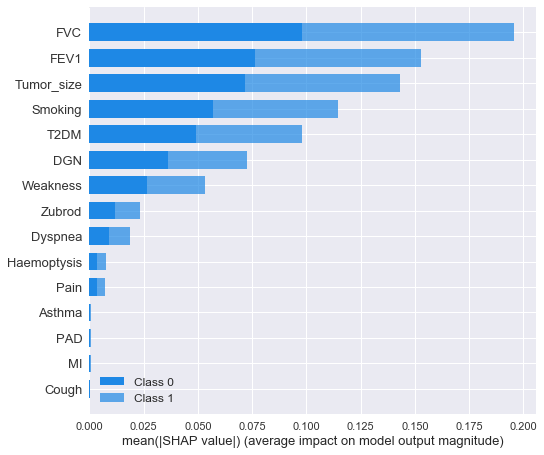

In [329]:
shap.summary_plot(shap_values, X2_test_noAge)

In [214]:
shap_values = shap.KernelExplainer(dtnA.predict_proba, X2_train_noAge).shap_values(X2_test_noAge.iloc[0:1000,:],nsamples=1000)
shap.force_plot(shap_values[0], X2_test_noAge.iloc[0:1000,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [17:58<00:00,  9.46s/it]


In [250]:
rdtnay_pred_prob = dtnA.predict_proba(X2_test_noAge)[:,1]
print('AU-ROC score:', round(roc_auc_score(y2_test, rdtnay_pred_prob),4))

AU-ROC score: 0.7962


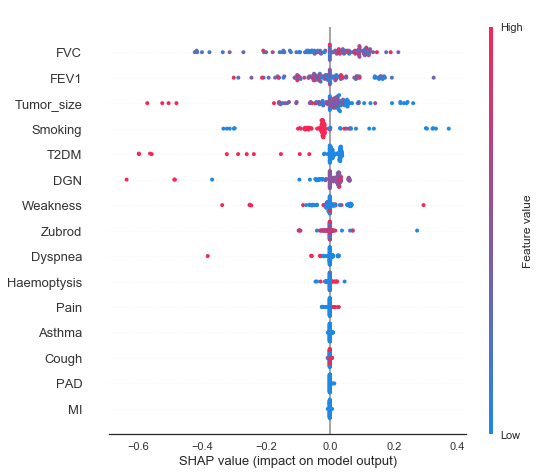

In [215]:
shap.summary_plot(shap_values[0], X2_test_noAge)

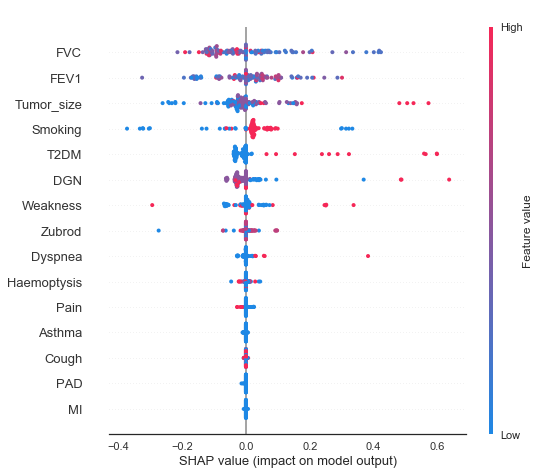

In [216]:
shap.summary_plot(shap_values[1], X2_test_noAge)

In [316]:
print(y2_test.iloc[0])
print(y2_test.iloc[1])

0
1


#### XGBoost SHAP without Age

In [251]:

xgb_full = xgboost.DMatrix(X2_train_noAge, label=y2_train)


xgb50_train = xgboost.DMatrix(X_train, label=y_train)
xgb50_test = xgboost.DMatrix(X_test, label=y_test)

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X2_train_noAge, label=y2_train), 500)

In [252]:
shap.initjs() 

shap_values = shap.TreeExplainer(model).shap_values(X2_test_noAge)

# visualize the first prediction's explanation
shap.force_plot(shap_values[0,:], X2_test_noAge.iloc[0,:])

In [322]:
#shap.force_plot(shap_values, X)
shap.force_plot(shap_values, X2_test_noAge)

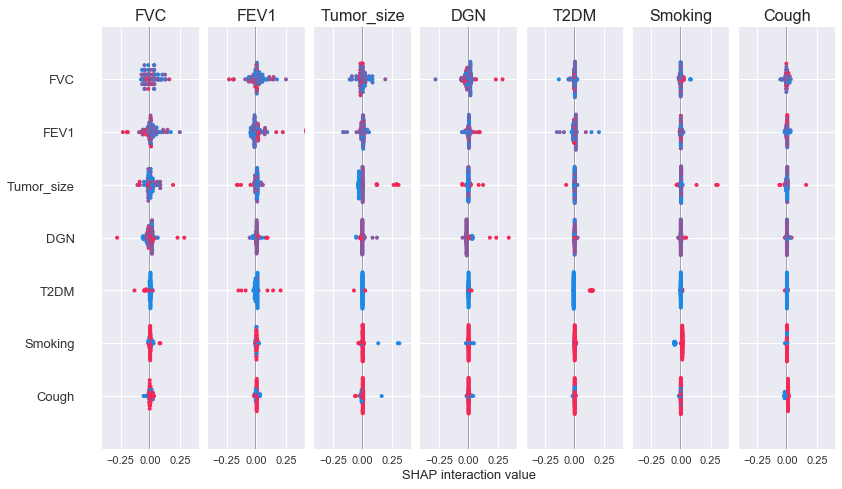

In [323]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X2_test_noAge)
shap.summary_plot(shap_interaction_values, X2_test_noAge)

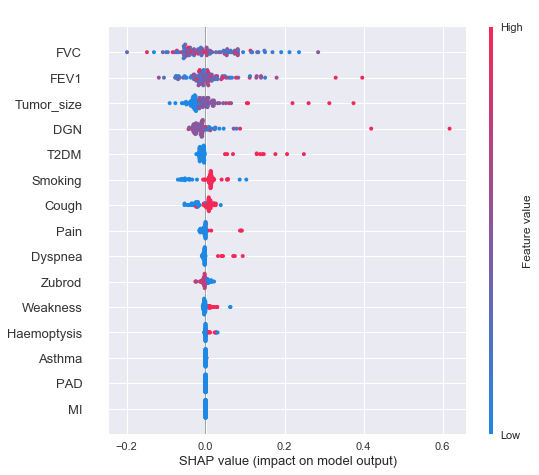

In [324]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X2_test_noAge)

#### SHAP with random forest with age removed

In [220]:
shap_values = shap.KernelExplainer(rfnA.predict_proba, X2_train_noAge).shap_values(X2_test_noAge.iloc[0:1000,:],nsamples=1000)
shap.force_plot(shap_values[0], X2_test_noAge.iloc[0:1000,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [33:39<00:00, 17.72s/it]


In [253]:
rnay_pred_prob = rfnA.predict_proba(X2_test_noAge)[:,1]
print('AU-ROC score:', round(roc_auc_score(y2_test, rnay_pred_prob),4))

AU-ROC score: 0.7514


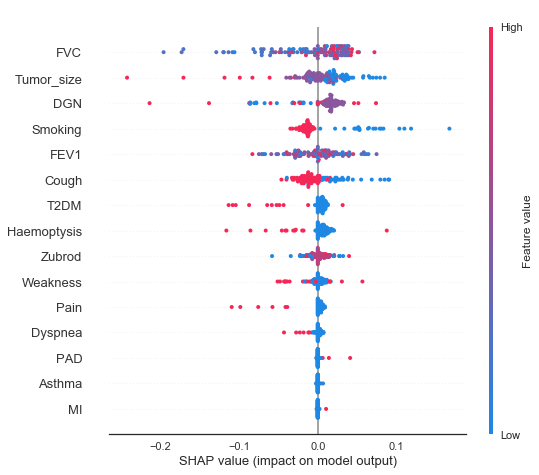

In [221]:
shap.summary_plot(shap_values[0], X2_test_noAge)

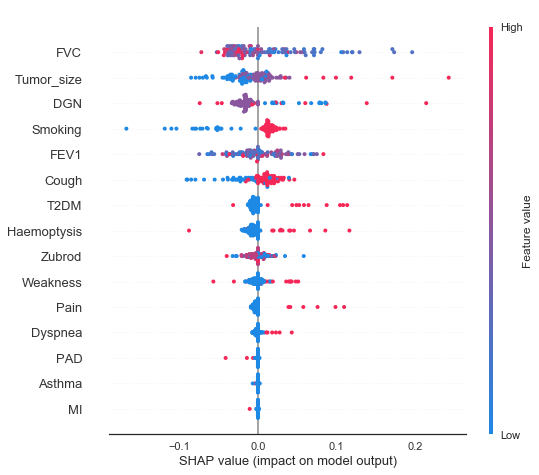

In [222]:
shap.summary_plot(shap_values[1], X2_test_noAge)

#### SHAP Decision tree - no age, haemoptysis, MI, PAD, asthma

In [254]:
X25_train_noAHMPDA, X25_test_noAHMPDA, y25_train, y25_test

dtnAHMPDA = DecisionTreeClassifier(class_weight='balanced')
dtnAHMPDA.fit(X25_train_noAHMPDA, y25_train)

shap_values = shap.KernelExplainer(dtnAHMPDA.predict_proba, X25_train_noAHMPDA).shap_values(X25_test_noAHMPDA.iloc[0,:])
shap.force_plot(shap_values[0], X25_test_noAHMPDA.iloc[0,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [429]:
shap_values = shap.KernelExplainer(dtnAHMPDA.predict_proba, X25_train_noAHMPDA).shap_values(X25_test_noAHMPDA)
shap.force_plot(shap_values[0], X25_test_noAHMPDA)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [29:59<00:00, 15.78s/it]


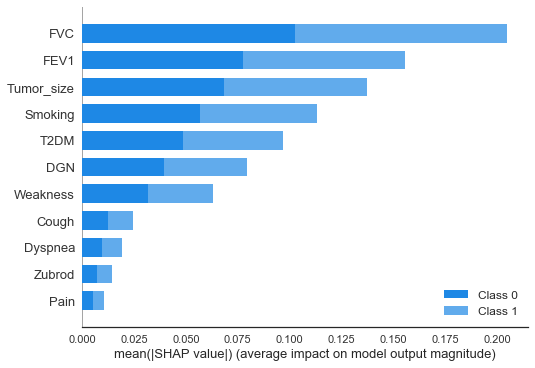

In [430]:
shap.summary_plot(shap_values, X25_test_noAHMPDA)

In [ ]:
#shap_values = shap.KernelExplainer(dtnAHMPDA.predict_proba, X25_train_noAHMPDA).shap_values(X25_test_noAHMPDA.iloc[0:1000,:],nsamples=1000)
#shap.force_plot(shap_values[0], X25_test_noAHMPDA.iloc[0:1000,:])

In [255]:
dtnahmpday_pred_prob = dtnAHMPDA.predict_proba(X25_test_noAHMPDA)[:,1]
print('AU-ROC score:', round(roc_auc_score(y25_test, dtnahmpday_pred_prob),4))

dtnahmpdayIndiv_pred = dtnAHMPDA.predict(X25_test_noAHMPDA)
print(list(zip(y25_test,dtnahmpdayIndiv_pred)))
print(confusion_matrix(y25_test, dtnahmpdayIndiv_pred))

AU-ROC score: 0.7911
[(0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (1, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1)]
[[85 12]
 [ 5 12]]


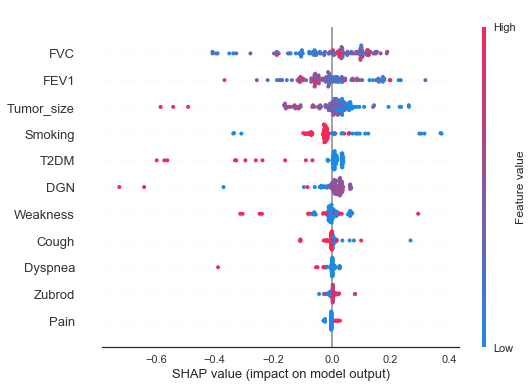

In [431]:
shap.summary_plot(shap_values[0], X25_test_noAHMPDA)

#### SHAP Random forest - no age, haemoptysis, MI, PAD, asthma

In [256]:
X25_train_noAHMPDA, X25_test_noAHMPDA, y25_train, y25_test

rfnAHMPDA = RandomForestClassifier(class_weight='balanced')
rfnAHMPDA.fit(X25_train_noAHMPDA, y25_train)

shap_values = shap.KernelExplainer(rfnAHMPDA.predict_proba, X25_train_noAHMPDA).shap_values(X25_test_noAHMPDA.iloc[0,:])
shap.force_plot(shap_values[0], X25_test_noAHMPDA.iloc[0,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [434]:
shap_values = shap.KernelExplainer(rfnAHMPDA.predict_proba, X25_train_noAHMPDA).shap_values(X25_test_noAHMPDA)
shap.force_plot(shap_values[0], X25_test_noAHMPDA)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [30:06<00:00, 15.84s/it]


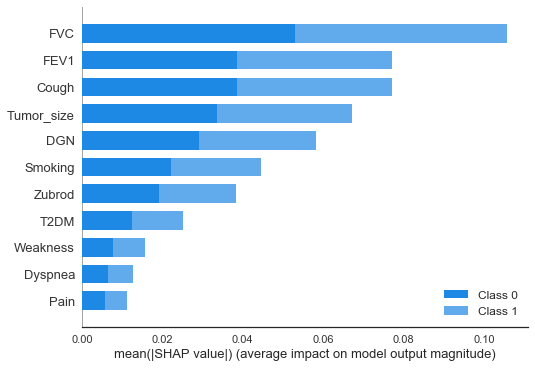

In [435]:
shap.summary_plot(shap_values, X25_test_noAHMPDA)

In [258]:
rfnahmpday_pred_prob = rfnAHMPDA.predict_proba(X25_test_noAHMPDA)[:,1]
print('AU-ROC score:', round(roc_auc_score(y25_test, rfnahmpday_pred_prob),4))

AU-ROC score: 0.6422


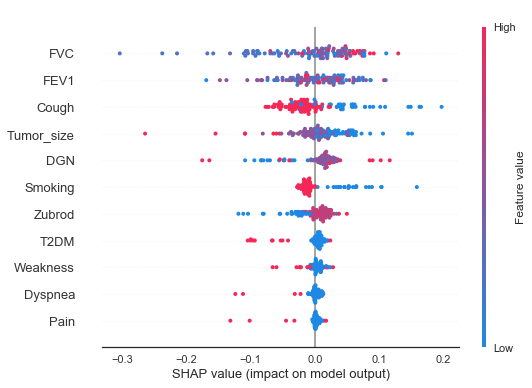

In [437]:
shap.summary_plot(shap_values[0], X25_test_noAHMPDA)

In [259]:
print(X25_test_noAHMPDA.iloc[0])
print(y25_test.iloc[0])
print(X25_test_noAHMPDA.iloc[1])
print(y25_test.iloc[1])

DGN            3.00
FVC            2.92
FEV1           2.32
Zubrod         0.00
Pain           0.00
Dyspnea        0.00
Cough          0.00
Weakness       0.00
Tumor_size    11.00
T2DM           0.00
Smoking        1.00
Name: 257, dtype: float64
0
DGN            3.00
FVC            2.68
FEV1           2.40
Zubrod         0.00
Pain           0.00
Dyspnea        0.00
Cough          0.00
Weakness       0.00
Tumor_size    11.00
T2DM           0.00
Smoking        1.00
Name: 191, dtype: float64
1


In [445]:
thoracic_df_new.Haemoptysis.value_counts()

0    392
1     62
Name: Haemoptysis, dtype: int64

In [455]:
thoracic_df_new.loc[(thoracic_df_new.Risk1Y == 1).values]

DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
4      3  2.44  0.96       2     0            1        0      1         1   
6      3  4.36  3.28       1     0            0        0      1         0   
7      2  3.19  2.50       1     0            0        0      1         0   
13     2  3.98  3.06       2     0            0        0      1         1   
24     8  4.32  3.20       0     0            0        0      0         0   
27     3  3.40  3.06       1     0            0        0      1         1   
30     3  3.24  2.40       1     1            1        0      0         0   
40     5  3.80  2.98       1     0            0        0      1         0   
41     2  3.24  2.52       1     0            0        0      1         0   
43     5  2.68  2.12       0     0            0        0      1         0   
47     3  2.64  2.12       1     0            0        0      1         0   
57     3  3.40  2.80       1     1            0        0      1         1   
60     3  3.52  2.28       0     0            0        0      0         0   
67     4  2.32  1.76       1     0            1        0      1         1   
75     3  3.40  2.80       1     0            0        0      1         0   
77     3  3.04  3.60       1     0            0        0      1         0   
92     3  3.60  2.48       1     0            0        0      1         0   
96     4  2.68  2.00       1     0            0        0      1         0   
99     3  4.60  2.92       1     0            1        1      1         0   
115    4  2.76  1.76       1     0            1        0      1         0   
127    3  2.00  1.00       1     0            1        0      1         1   
128    4  3.31  2.00       2     0            0        1      1         0   
137    3  2.08  1.52       1     0            0        0      1         0   
143    4  2.08  1.76       0     0            0        0      0         0   
151    3  3.88  2.84       1     0            1        0      1         0   
152    3  2.72  2.04       1     1            0        0      0         0   
169    3  2.44  1.96       1     0            1        1      1         0   
173    3  2.60  2.36       1     0            0        0      1         0   
175    3  3.68  2.36       0     0            0        1      1         0   
185    5  3.52  2.56       0     0            0        1      0         0   
..   ...   ...   ...     ...   ...          ...      ...    ...       ...   
238    5  3.40  2.08       1     0            0        0      0         1   
239    3  3.52  2.52       1     0            0        0      1         0   
242    2  4.88  3.44       0     0            1        0      1         0   
251    3  3.04  2.24       2     0            0        0      1         1   
260    3  2.72  2.09       0     0            0        0      0         0   
268    3  2.52  1.72       2     0            0        1      1         1   
270    3  2.52  1.72       1     0            0        0      1         1   
274    2  4.04  2.76       1     0            0        0      1         0   
296    3  2.48  1.84       1     0            0        0      1         0   
297    3  4.36  3.24       1     1            0        1      1         0   
302    3  4.59  3.02       2     1            0        0      1         1   
305    3  2.76  1.80       1     0            0        0      1         0   
312    3  3.12  2.52       1     1            0        0      1         0   
321    3  4.65  3.78       1     0            0        0      1         0   
334    2  4.00  3.12       1     0            0        0      1         0   
340    3  3.88  2.92       0     0            0        0      0         0   
348    2  4.20  3.60       1     0            0        0      0         1   
350    3  2.64  2.16       1     0            1        0      1         0   
357    3  2.00  1.36       0     0            0        0      0         0   
362    3  3.08  1.72       1     0            0        0      1         1   
3

In [488]:
round((thoracic_df_new.loc[(thoracic_df_new.Risk1Y == 0).values]).mean().T, 3)

DGN             3.070
FVC             3.305
FEV1            2.541
Zubrod          0.774
Pain            0.052
Haemoptysis     0.125
Dyspnea         0.044
Cough           0.678
Weakness        0.158
Tumor_size     11.683
T2DM            0.062
MI              0.005
PAD             0.016
Smoking         0.816
Asthma          0.005
Age            62.678
Risk1Y          0.000
dtype: float64

In [641]:
thoracic_df_new.loc[(thoracic_df_new.Risk1Y == 0).values].describe()

DGN         FVC        FEV1      Zubrod        Pain  \
count  385.000000  385.000000  385.000000  385.000000  385.000000   
mean     3.070130    3.304597    2.540805    0.774026    0.051948   
std      0.651733    0.891130    0.788578    0.528708    0.222211   
min      1.000000    1.440000    1.000000    0.000000    0.000000   
25%      3.000000    2.600000    1.960000    0.000000    0.000000   
50%      3.000000    3.160000    2.400000    1.000000    0.000000   
75%      3.000000    3.870000    3.040000    1.000000    0.000000   
max      8.000000    6.300000    5.480000    2.000000    1.000000   

       Haemoptysis     Dyspnea       Cough    Weakness  Tumor_size  \
count   385.000000  385.000000  385.000000  385.000000  385.000000   
mean      0.124675    0.044156    0.677922    0.158442   11.683117   
std       0.330780    0.205709    0.467881    0.365630    0.664071   
min       0.000000    0.000000    0.000000    0.000000   11.000000   
25%       0.000000    0.000000    0.000000    0.000000   11.000000   
50%       0.000000    0.000000    1.000000    0.000000   12.000000   
75%       0.000000    0.000000    1.000000    0.000000   12.000000   
max       1.000000    1.000000    1.000000    1.000000   14.000000   

             T2DM          MI         PAD     Smoking      Asthma         Age  \
count  385.000000  385.000000  385.000000  385.000000  385.000000  385.000000   
mean     0.062338    0.005195    0.015584    0.815584    0.005195   62.677922   
std      0.242082    0.071981    0.124022    0.388327    0.071981    8.321981   
min      0.000000    0.000000    0.000000    0.000000    0.000000   37.000000   
25%      0.000000    0.000000    0.000000    1.000000    0.000000   57.000000   
50%      0.000000    0.000000    0.000000    1.000000    0.000000   62.000000   
75%      0.000000    0.000000    0.000000    1.000000    0.000000   69.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   87.000000   

       Risk1Y  
count   385.0  
mean      0.0  
std       0.0  
min       0.0  
25%       0.0  
50%       0.0  
75%       0.0  
max       0.0

In [484]:
round((thoracic_df_new.loc[(thoracic_df_new.Risk1Y == 1).values]).mean().T, 3)

DGN             3.217
FVC             3.195
FEV1            2.383
Zubrod          0.913
Pain            0.101
Haemoptysis     0.203
Dyspnea         0.116
Cough           0.797
Weakness        0.246
Tumor_size     12.014
T2DM            0.145
MI              0.000
PAD             0.029
Smoking         0.899
Asthma          0.000
Age            63.333
Risk1Y          1.000
dtype: float64

In [642]:
thoracic_df_new.loc[(thoracic_df_new.Risk1Y == 1).values].describe()

DGN        FVC       FEV1     Zubrod       Pain  Haemoptysis  \
count  69.000000  69.000000  69.000000  69.000000  69.000000    69.000000   
mean    3.217391   3.195072   2.383188   0.913043   0.101449     0.202899   
std     0.998080   0.758161   0.660409   0.535206   0.304135     0.405104   
min     2.000000   2.000000   0.960000   0.000000   0.000000     0.000000   
25%     3.000000   2.640000   2.000000   1.000000   0.000000     0.000000   
50%     3.000000   3.040000   2.240000   1.000000   0.000000     0.000000   
75%     3.000000   3.680000   2.840000   1.000000   0.000000     0.000000   
max     8.000000   4.960000   4.160000   2.000000   1.000000     1.000000   

         Dyspnea      Cough   Weakness  Tumor_size       T2DM    MI  \
count  69.000000  69.000000  69.000000   69.000000  69.000000  69.0   
mean    0.115942   0.797101   0.246377   12.014493   0.144928   0.0   
std     0.322501   0.405104   0.434057    0.865902   0.354607   0.0   
min     0.000000   0.000000   0.000000   11.000000   0.000000   0.0   
25%     0.000000   1.000000   0.000000   11.000000   0.000000   0.0   
50%     0.000000   1.000000   0.000000   12.000000   0.000000   0.0   
75%     0.000000   1.000000   0.000000   12.000000   0.000000   0.0   
max     1.000000   1.000000   1.000000   14.000000   1.000000   0.0   

             PAD    Smoking  Asthma        Age  Risk1Y  
count  69.000000  69.000000    69.0  69.000000    69.0  
mean    0.028986   0.898551     0.0  63.333333     1.0  
std     0.168995   0.304135     0.0   9.174239     0.0  
min     0.000000   0.000000     0.0  39.000000     1.0  
25%     0.000000   1.000000     0.0  57.000000     1.0  
50%     0.000000   1.000000     0.0  62.000000     1.0  
75%     0.000000   1.000000     0.0  70.000000     1.0  
max     1.000000   1.000000     0.0  87.000000     1.0

In [513]:
NS = thoracic_df_new[thoracic_df_new.Risk1Y > 0]
(NS.Haemoptysis > 0).values

array([ True, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False], dtype=bool)

#### SHAP decision tree without tumor size (to see if age clearer in effect)

In [260]:
X3_train_noTS, X3_test_noTS, y3_train, y3_test

dtnTS = DecisionTreeClassifier(class_weight='balanced')
dtnTS.fit(X3_train_noTS, y3_train)

shap_values = shap.KernelExplainer(dtnTS.predict_proba, X3_train_noTS).shap_values(X3_test_noTS.iloc[0,:])
shap.force_plot(shap_values[0], X3_test_noTS.iloc[0,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [523]:
shap_values = shap.KernelExplainer(dtnTS.predict_proba, X3_train_noTS).shap_values(X3_test_noTS)
shap.force_plot(shap_values[0], X3_test_noTS)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [40:20<00:00, 21.23s/it]


In [261]:
dtntsy_pred_prob = dtnTS.predict_proba(X3_test_noTS)[:,1]
print('AU-ROC score:', round(roc_auc_score(y3_test, dtntsy_pred_prob),4))

AU-ROC score: 0.6095


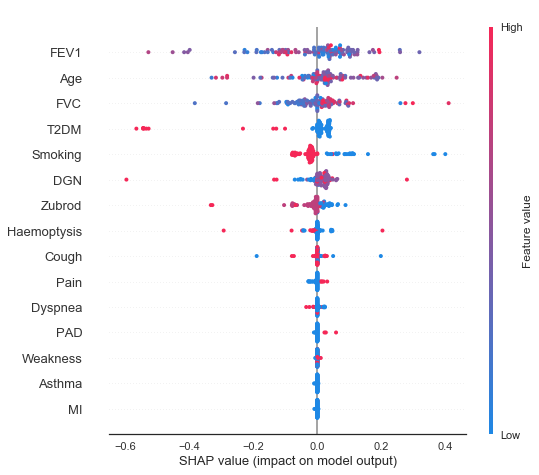

In [525]:
shap.summary_plot(shap_values[0], X3_test_noTS)

### Converting age to 3 bins and re-running

In [262]:
thoracic_agebin_df = thoracic_df_new.copy(deep=True)
u = pd.Series(thoracic_agebin_df.Age)
uc = pd.cut(u, 3, labels=['younger', 'medium', 'older'])
thoracic_agebin_df['Age'] = uc
thoracic_agebin_df.head(20)

DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0     2  2.88  2.16       1     0            0        0      1         1   
1     3  3.40  1.88       0     0            0        0      0         0   
2     3  2.76  2.08       1     0            0        0      1         0   
3     3  3.68  3.04       0     0            0        0      0         0   
4     3  2.44  0.96       2     0            1        0      1         1   
5     3  2.48  1.88       1     0            0        0      1         0   
6     3  4.36  3.28       1     0            0        0      1         0   
7     2  3.19  2.50       1     0            0        0      1         0   
8     3  3.16  2.64       2     0            0        0      1         1   
9     3  2.32  2.16       1     0            0        0      1         0   
10    3  2.56  2.32       0     0            1        0      1         0   
11    3  4.28  4.44       1     0            0        0      0         0   
12    3  3.00  2.36       1     0            0        0      1         1   
13    2  3.98  3.06       2     0            0        0      1         1   
14    3  1.96  1.40       1     0            0        0      1         0   
15    3  4.68  4.16       1     0            0        0      1         0   
16    2  2.21  1.88       0     0            1        0      0         0   
17    2  2.96  1.67       0     0            0        0      0         0   
18    3  2.60  1.68       1     0            0        0      1         0   
19    3  2.88  2.48       0     0            0        0      0         0   

    Tumor_size  T2DM  MI  PAD  Smoking  Asthma      Age  Risk1Y  
0           14     0   0    0        1       0   medium       0  
1           12     0   0    0        1       0  younger       0  
2           11     0   0    0        1       0   medium       0  
3           11     0   0    0        0       0   medium       0  
4           11     0   0    0        1       0    older       1  
5           11     0   0    0        0       0  younger       0  
6           12     1   0    0        1       0   medium       1  
7           11     0   0    1        1       0   medium       1  
8           11     0   0    0        1       0   medium       0  
9           11     0   0    0        1       0   medium       0  
10          12     0   0    0        0       0   medium       0  
11          12     0   0    0        1       0   medium       0  
12          11     0   0    0        1       0   medium       0  
13          14     0   0    0        1       0    older       1  
14          11     0   0    0        1       0    older       0  
15          12     0   0    0        1       0   medium       0  
16          12     0   0    0        1       0   medium       0  
17          12     0   0    0        1       0   medium       0  
18          12     0   0    0        1       0   medium       0  
19          11     0   0    0        1       0    older       0

In [645]:
thoracic_df_new.head(20)

DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0     2  2.88  2.16       1     0            0        0      1         1   
1     3  3.40  1.88       0     0            0        0      0         0   
2     3  2.76  2.08       1     0            0        0      1         0   
3     3  3.68  3.04       0     0            0        0      0         0   
4     3  2.44  0.96       2     0            1        0      1         1   
5     3  2.48  1.88       1     0            0        0      1         0   
6     3  4.36  3.28       1     0            0        0      1         0   
7     2  3.19  2.50       1     0            0        0      1         0   
8     3  3.16  2.64       2     0            0        0      1         1   
9     3  2.32  2.16       1     0            0        0      1         0   
10    3  2.56  2.32       0     0            1        0      1         0   
11    3  4.28  4.44       1     0            0        0      0         0   
12    3  3.00  2.36       1     0            0        0      1         1   
13    2  3.98  3.06       2     0            0        0      1         1   
14    3  1.96  1.40       1     0            0        0      1         0   
15    3  4.68  4.16       1     0            0        0      1         0   
16    2  2.21  1.88       0     0            1        0      0         0   
17    2  2.96  1.67       0     0            0        0      0         0   
18    3  2.60  1.68       1     0            0        0      1         0   
19    3  2.88  2.48       0     0            0        0      0         0   

    Tumor_size  T2DM  MI  PAD  Smoking  Asthma   Age  Risk1Y  
0           14     0   0    0        1       0  60.0       0  
1           12     0   0    0        1       0  51.0       0  
2           11     0   0    0        1       0  59.0       0  
3           11     0   0    0        0       0  54.0       0  
4           11     0   0    0        1       0  73.0       1  
5           11     0   0    0        0       0  51.0       0  
6           12     1   0    0        1       0  59.0       1  
7           11     0   0    1        1       0  66.0       1  
8           11     0   0    0        1       0  68.0       0  
9           11     0   0    0        1       0  54.0       0  
10          12     0   0    0        0       0  60.0       0  
11          12     0   0    0        1       0  58.0       0  
12          11     0   0    0        1       0  68.0       0  
13          14     0   0    0        1       0  80.0       1  
14          11     0   0    0        1       0  77.0       0  
15          12     0   0    0        1       0  62.0       0  
16          12     0   0    0        1       0  56.0       0  
17          12     0   0    0        1       0  61.0       0  
18          12     0   0    0        1       0  70.0       0  
19          11     0   0    0        1       0  71.0       0

In [263]:
thoracic_agebin_df_dum = pd.get_dummies(thoracic_agebin_df)
print(thoracic_agebin_df_dum.head())

   DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0    2  2.88  2.16       1     0            0        0      1         1   
1    3  3.40  1.88       0     0            0        0      0         0   
2    3  2.76  2.08       1     0            0        0      1         0   
3    3  3.68  3.04       0     0            0        0      0         0   
4    3  2.44  0.96       2     0            1        0      1         1   

   Tumor_size  T2DM  MI  PAD  Smoking  Asthma  Risk1Y  Age_younger  \
0          14     0   0    0        1       0       0            0   
1          12     0   0    0        1       0       0            1   
2          11     0   0    0        1       0       0            0   
3          11     0   0    0        0       0       0            0   
4          11     0   0    0        1       0       1            0   

   Age_medium  Age_older  
0           1          0  
1           0          0  
2           1          0  
3           1       

In [264]:
Xagebin = thoracic_agebin_df_dum.drop('Risk1Y', axis = 1)
yagebin = thoracic_agebin_df_dum.Risk1Y

Xagebin_train, Xagebin_test, yagebin_train, yagebin_test, sw28_train, sw28_test = train_test_split(Xagebin, yagebin, sw, random_state=100, stratify=y)

#random state makes a difference with this small dataset of few in the minority class. 

AU-ROC score for uncalibrated Decision Tree model: 0.7808
AU-ROC score for isotonically calibrated Decision Tree model: 0.5585
AU-ROC score for sigmoid calibrated Decision Tree model: 0.5716

Brier scores: (the smaller the better)
No calibration: 0.218
With isotonic calibration: 0.247
With sigmoid calibration: 0.247


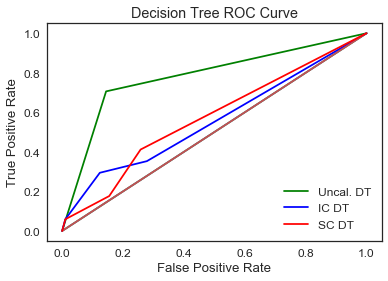

In [265]:
# DT with no calibration
dtab = DecisionTreeClassifier(class_weight='balanced')
dtab.fit(Xagebin_train, yagebin_train)  
prob_pos_dtab1 = dtab.predict_proba(Xagebin_test)[:, 1]
print('AU-ROC score for uncalibrated Decision Tree model:', round(roc_auc_score(yagebin_test, prob_pos_dtab1),4))

# DT with isotonic calibration
dtab_isotonic = CalibratedClassifierCV(dtab, cv=2, method='isotonic')
dtab_isotonic.fit(Xagebin_train, yagebin_train, sw28_train)
prob_pos_isotonicdtab = dtab_isotonic.predict_proba(Xagebin_test)[:, 1]
print('AU-ROC score for isotonically calibrated Decision Tree model:', round(roc_auc_score(yagebin_test, prob_pos_isotonicdtab),4))

# DT with sigmoid calibration
dtab_sigmoid = CalibratedClassifierCV(dtab, cv=2, method='sigmoid')
dtab_sigmoid.fit(Xagebin_train, yagebin_train, sw28_train)
prob_pos_sigmoiddtab = dtab_sigmoid.predict_proba(Xagebin_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Decision Tree model:', round(roc_auc_score(yagebin_test, prob_pos_sigmoiddtab),4))

print("\nBrier scores: (the smaller the better)")

dtab_score = brier_score_loss(yagebin_test, prob_pos_dtab1, sw28_test)
print("No calibration: %1.3f" % dtab_score)

dtab_isotonic_score = brier_score_loss(yagebin_test, prob_pos_isotonicdtab, sw28_test)
print("With isotonic calibration: %1.3f" % dtab_isotonic_score)

dtab_sigmoid_score = brier_score_loss(yagebin_test, prob_pos_sigmoiddtab, sw28_test)
print("With sigmoid calibration: %1.3f" % dtab_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(yagebin_test, prob_pos_dtab1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. DT', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr2, tpr2, thresholds2 = roc_curve(yagebin_test, prob_pos_isotonicdtab)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC DT', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr3, tpr3, thresholds3 = roc_curve(yagebin_test, prob_pos_sigmoiddtab)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC DT', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')

plt.legend()
plt.show()

In [266]:
dtsab = DecisionTreeClassifier(class_weight='balanced')
dtsab.fit(Xagebin_train, yagebin_train)

shap_values = shap.KernelExplainer(dtsab.predict_proba, Xagebin_train).shap_values(Xagebin_test.iloc[7,:])
shap.force_plot(shap_values[0], Xagebin_test.iloc[7,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [557]:
shap_values = shap.KernelExplainer(dtsab.predict_proba, Xagebin_train).shap_values(Xagebin_test)
shap.force_plot(shap_values[0], Xagebin_test)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [45:48<00:00, 24.11s/it]


In [267]:
dtsaby_pred_prob = dtsab.predict_proba(Xagebin_test)[:,1]
print('AU-ROC score:', round(roc_auc_score(yagebin_test, dtsaby_pred_prob),4))

print('Accuracy on training data:',round(dtsab.score(Xagebin_train, yagebin_train),3))
print('Accuracy on test data:',round(dtsab.score(Xagebin_test, yagebin_test),3))

AU-ROC score: 0.7911
Accuracy on training data: 1.0
Accuracy on test data: 0.851


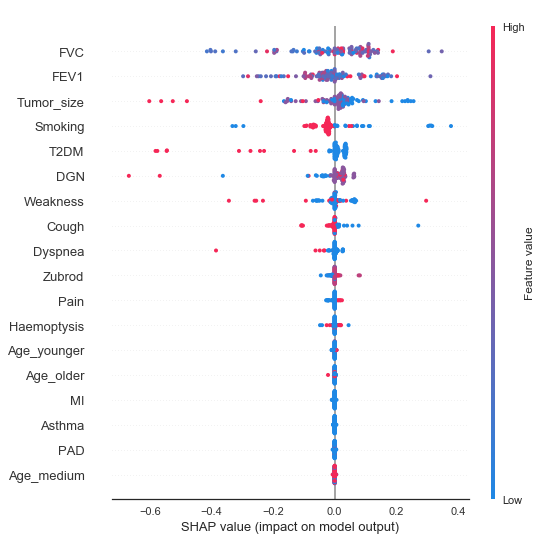

In [559]:
shap.summary_plot(shap_values[0], Xagebin_test)

In [268]:
Xagebin_noHMPDA = Xagebin.drop(['Haemoptysis', 'MI', 'PAD', 'Asthma'], axis = 1)

Xagebin_noHMPDA_train, Xagebin_noHMPDA_test, yagebin_train, yagebin_test, sw27_train, sw27_test = \
    train_test_split(Xagebin_noHMPDA, yagebin, sw, random_state=100, stratify=y)

AU-ROC score for uncalibrated Decision Tree model: 0.7808
AU-ROC score for isotonically calibrated Decision Tree model: 0.5764
AU-ROC score for sigmoid calibrated Decision Tree model: 0.6043

Brier scores: (the smaller the better)
No calibration: 0.208
With isotonic calibration: 0.246
With sigmoid calibration: 0.241


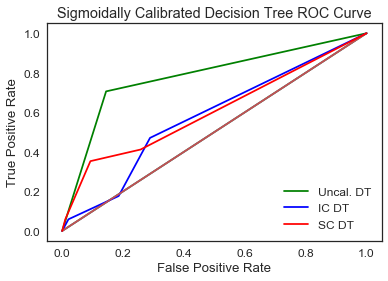

In [269]:
# DT with no calibration
dtabnoHMPDA = DecisionTreeClassifier(class_weight='balanced')
dtabnoHMPDA.fit(Xagebin_train, yagebin_train)  
prob_pos_dtabnoHMPDA1 = dtabnoHMPDA.predict_proba(Xagebin_test)[:, 1]
print('AU-ROC score for uncalibrated Decision Tree model:', round(roc_auc_score(yagebin_test, prob_pos_dtab1),4))

# DT with isotonic calibration
dtabnoHMPDA_isotonic = CalibratedClassifierCV(dtabnoHMPDA, cv=2, method='isotonic')
dtabnoHMPDA_isotonic.fit(Xagebin_train, yagebin_train, sw28_train)
prob_pos_isotonicdtabnoHMPDA = dtabnoHMPDA_isotonic.predict_proba(Xagebin_test)[:, 1]
print('AU-ROC score for isotonically calibrated Decision Tree model:', round(roc_auc_score(yagebin_test, prob_pos_isotonicdtabnoHMPDA),4))

# DT with sigmoid calibration
dtabnoHMPDA_sigmoid = CalibratedClassifierCV(dtabnoHMPDA, cv=2, method='sigmoid')
dtabnoHMPDA_sigmoid.fit(Xagebin_train, yagebin_train, sw28_train)
prob_pos_sigmoiddtabnoHMPDA = dtabnoHMPDA_sigmoid.predict_proba(Xagebin_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Decision Tree model:', round(roc_auc_score(yagebin_test, prob_pos_sigmoiddtabnoHMPDA),4))

print("\nBrier scores: (the smaller the better)")

dtabnoHMPDA_score = brier_score_loss(yagebin_test, prob_pos_dtabnoHMPDA1, sw28_test)
print("No calibration: %1.3f" % dtabnoHMPDA_score)

dtabnoHMPDA_isotonic_score = brier_score_loss(yagebin_test, prob_pos_isotonicdtabnoHMPDA, sw28_test)
print("With isotonic calibration: %1.3f" % dtabnoHMPDA_isotonic_score)

dtabnoHMPDA_sigmoid_score = brier_score_loss(yagebin_test, prob_pos_sigmoiddtabnoHMPDA, sw28_test)
print("With sigmoid calibration: %1.3f" % dtabnoHMPDA_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(yagebin_test, prob_pos_dtab1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. DT', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Uncalibrated Decision Tree ROC Curve')

fpr2, tpr2, thresholds2 = roc_curve(yagebin_test, prob_pos_isotonicdtabnoHMPDA)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC DT', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isotonically Calibrated Decision Tree ROC Curve')

fpr3, tpr3, thresholds3 = roc_curve(yagebin_test, prob_pos_sigmoiddtabnoHMPDA)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC DT', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sigmoidally Calibrated Decision Tree ROC Curve')

plt.legend()
plt.show()

In [270]:
dtabnoHMPDA_pred = dtabnoHMPDA.predict(Xagebin_test)
print(classification_report(yagebin_test,dtabnoHMPDA_pred))
print(confusion_matrix(yagebin_test, dtabnoHMPDA_pred))

dtisoabnoHMPDA_pred = dtabnoHMPDA_isotonic.predict(Xagebin_test)
print(classification_report(yagebin_test,dtisoabnoHMPDA_pred))
print(confusion_matrix(yagebin_test, dtisoabnoHMPDA_pred))

dtsigabnoHMPDA_pred = dtabnoHMPDA_sigmoid.predict(Xagebin_test)
print(classification_report(yagebin_test,dtsigabnoHMPDA_pred))
print(confusion_matrix(yagebin_test, dtsigabnoHMPDA_pred))

             precision    recall  f1-score   support

          0       0.94      0.88      0.91        97
          1       0.50      0.71      0.59        17

avg / total       0.88      0.85      0.86       114

[[85 12]
 [ 5 12]]
             precision    recall  f1-score   support

          0       0.88      0.71      0.79        97
          1       0.22      0.47      0.30        17

avg / total       0.79      0.68      0.72       114

[[69 28]
 [ 9  8]]
             precision    recall  f1-score   support

          0       0.88      0.74      0.80        97
          1       0.22      0.41      0.29        17

avg / total       0.78      0.69      0.73       114

[[72 25]
 [10  7]]


In [271]:
rfsab = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfsab.fit(Xagebin_train, yagebin_train)

shap_values = shap.KernelExplainer(rfsab.predict_proba, Xagebin_train).shap_values(Xagebin_test.iloc[1,:])
shap.force_plot(shap_values[0], Xagebin_test.iloc[1,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [565]:
shap_values = shap.KernelExplainer(rfsab.predict_proba, Xagebin_train).shap_values(Xagebin_test)
shap.force_plot(shap_values[0], Xagebin_test)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [1:39:57<00:00, 52.61s/it]


In [272]:
rfsaby_pred_prob = rfsab.predict_proba(Xagebin_test)[:,1]
print('AU-ROC score:', round(roc_auc_score(yagebin_test, rfsaby_pred_prob),4))

print('Accuracy on training data:',round(rfsab.score(Xagebin_train, yagebin_train),3))
print('Accuracy on test data:',round(rfsab.score(Xagebin_test, yagebin_test),3))

AU-ROC score: 0.7653
Accuracy on training data: 1.0
Accuracy on test data: 0.851


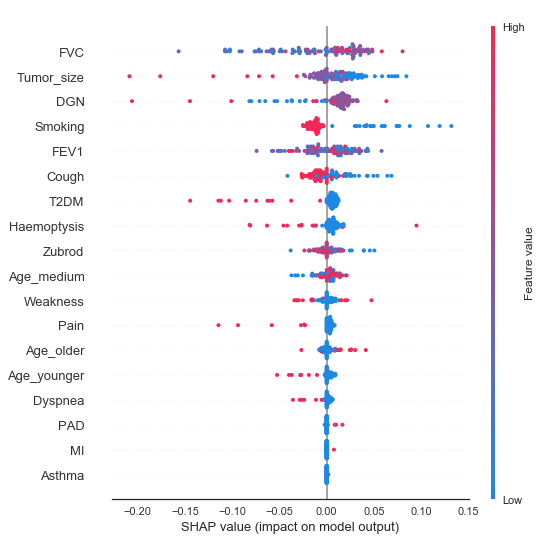

In [567]:
shap.summary_plot(shap_values[0], Xagebin_test)

In [273]:
print(Xagebin_test.iloc[0])
print(yagebin_test.iloc[0])
print(Xagebin_test.iloc[1])
print(yagebin_test.iloc[1])

DGN             3.00
FVC             2.92
FEV1            2.32
Zubrod          0.00
Pain            0.00
Haemoptysis     0.00
Dyspnea         0.00
Cough           0.00
Weakness        0.00
Tumor_size     11.00
T2DM            0.00
MI              0.00
PAD             0.00
Smoking         1.00
Asthma          0.00
Age_younger     0.00
Age_medium      1.00
Age_older       0.00
Name: 257, dtype: float64
0
DGN             3.00
FVC             2.68
FEV1            2.40
Zubrod          0.00
Pain            0.00
Haemoptysis     0.00
Dyspnea         0.00
Cough           0.00
Weakness        0.00
Tumor_size     11.00
T2DM            0.00
MI              0.00
PAD             0.00
Smoking         1.00
Asthma          0.00
Age_younger     0.00
Age_medium      1.00
Age_older       0.00
Name: 191, dtype: float64
1


In [274]:
yagebin_test

257    0
191    1
398    0
435    0
237    0
366    0
18     0
220    1
95     0
240    0
386    1
467    0
177    0
12     0
262    0
338    0
376    0
250    0
391    0
209    1
377    0
333    0
108    0
431    0
390    0
351    0
73     0
263    0
311    0
218    0
      ..
174    0
372    0
223    0
280    0
114    0
413    0
119    0
360    0
11     0
315    0
230    0
362    1
393    0
342    0
419    1
87     0
101    0
266    0
90     0
5      0
142    0
2      0
80     0
404    1
117    0
301    0
462    0
63     0
291    0
227    1
Name: Risk1Y, Length: 114, dtype: int64

In [275]:
dtsabIndiv_pred = dtsab.predict(Xagebin_test)
print(list(zip(yagebin_test,dtsabIndiv_pred)))
print(confusion_matrix(yagebin_test, dtsabIndiv_pred))

[(0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (1, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1)]
[[85 12]
 [ 5 12]]


In [276]:
rfsabIndiv_pred = rfsab.predict(Xagebin_test)
print(list(zip(yagebin_test,rfsabIndiv_pred)))
print(confusion_matrix(yagebin_test, rfsabIndiv_pred))

[(0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0)]
[[97  0]
 [17  0]]


#### Decision tree and agebin data without MI, asthma, PAD

In [277]:
XabnoMPDA = Xagebin.drop(['MI', 'PAD', 'Asthma'], axis = 1)


XabnoMPDA_train, XabnoMPDA_test, yagebin1_train, yagebin1_test, sw29_train, sw29_test = \
    train_test_split(XabnoMPDA, yagebin, sw, random_state=100, stratify=y)

AU-ROC score for uncalibrated Decision Tree model: 0.7962
AU-ROC score for isotonically calibrated Decision Tree model: 0.5904
AU-ROC score for sigmoid calibrated Decision Tree model: 0.611

Brier scores: (the smaller the better)
No calibration: 0.203
With isotonic calibration: 0.245
With sigmoid calibration: 0.241


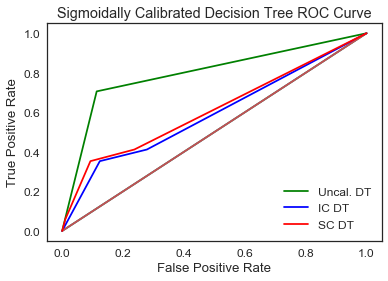

In [279]:
# DT with no calibration
dtabnoMPDA = DecisionTreeClassifier(class_weight='balanced')
dtabnoMPDA.fit(XabnoMPDA_train, yagebin1_train)  
prob_pos_dtabnoMPDA1 = dtabnoMPDA.predict_proba(XabnoMPDA_test)[:, 1]
print('AU-ROC score for uncalibrated Decision Tree model:', round(roc_auc_score(yagebin1_test, prob_pos_dtabnoMPDA1),4))

# DT with isotonic calibration
dtabnoMPDA_isotonic = CalibratedClassifierCV(dtabnoMPDA, cv=2, method='isotonic')
dtabnoMPDA_isotonic.fit(XabnoMPDA_train, yagebin1_train, sw29_train)
prob_pos_isotonicdtabnoMPDA = dtabnoMPDA_isotonic.predict_proba(XabnoMPDA_test)[:, 1]
print('AU-ROC score for isotonically calibrated Decision Tree model:', round(roc_auc_score(yagebin1_test, prob_pos_isotonicdtabnoMPDA),4))

# DT with sigmoid calibration
dtabnoMPDA_sigmoid = CalibratedClassifierCV(dtabnoMPDA, cv=2, method='sigmoid')
dtabnoMPDA_sigmoid.fit(XabnoMPDA_train, yagebin1_train, sw29_train)
prob_pos_sigmoiddtabnoMPDA = dtabnoMPDA_sigmoid.predict_proba(XabnoMPDA_test)[:, 1]
print('AU-ROC score for sigmoid calibrated Decision Tree model:', round(roc_auc_score(yagebin1_test, prob_pos_sigmoiddtabnoMPDA),4))

print("\nBrier scores: (the smaller the better)")

dtabnoMPDA_score = brier_score_loss(yagebin1_test, prob_pos_dtabnoMPDA1, sw29_test)
print("No calibration: %1.3f" % dtabnoMPDA_score)

dtabnoMPDA_isotonic_score = brier_score_loss(yagebin1_test, prob_pos_isotonicdtabnoMPDA, sw29_test)
print("With isotonic calibration: %1.3f" % dtabnoMPDA_isotonic_score)

dtabnoMPDA_sigmoid_score = brier_score_loss(yagebin1_test, prob_pos_sigmoiddtabnoMPDA, sw29_test)
print("With sigmoid calibration: %1.3f" % dtabnoMPDA_sigmoid_score)


fpr1, tpr1, thresholds1 = roc_curve(yagebin1_test, prob_pos_dtabnoMPDA1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. DT', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Uncalibrated Decision Tree ROC Curve')

fpr2, tpr2, thresholds2 = roc_curve(yagebin1_test, prob_pos_isotonicdtabnoMPDA)
plt.plot([0,1],[0,1])
plt.plot(fpr2,tpr2, label='IC DT', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isotonically Calibrated Decision Tree ROC Curve')

fpr3, tpr3, thresholds3 = roc_curve(yagebin1_test, prob_pos_sigmoiddtabnoMPDA)
plt.plot([0,1],[0,1])
plt.plot(fpr3,tpr3, label='SC DT', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sigmoidally Calibrated Decision Tree ROC Curve')

plt.legend()
plt.show()

In [280]:
dtabnoMPDA_pred = dtabnoMPDA.predict(XabnoMPDA_test)
print(classification_report(yagebin1_test,dtabnoMPDA_pred))
print(confusion_matrix(yagebin_test, dtabnoHMPDA_pred))

dtisoabnoMPDA_pred = dtabnoMPDA_isotonic.predict(XabnoMPDA_test)
print(classification_report(yagebin1_test,dtisoabnoMPDA_pred))
print(confusion_matrix(yagebin_test, dtisoabnoMPDA_pred))

dtsigabnoHMPDA_pred = dtabnoMPDA_sigmoid.predict(XabnoMPDA_test)
print(classification_report(yagebin1_test,dtsigabnoHMPDA_pred))
print(confusion_matrix(yagebin1_test, dtsigabnoHMPDA_pred))

             precision    recall  f1-score   support

          0       0.95      0.89      0.91        97
          1       0.52      0.71      0.60        17

avg / total       0.88      0.86      0.87       114

[[85 12]
 [ 5 12]]
             precision    recall  f1-score   support

          0       0.88      0.72      0.79        97
          1       0.21      0.41      0.27        17

avg / total       0.78      0.68      0.71       114

[[70 27]
 [10  7]]
             precision    recall  f1-score   support

          0       0.89      0.91      0.90        97
          1       0.40      0.35      0.38        17

avg / total       0.82      0.82      0.82       114

[[88  9]
 [11  6]]


In [281]:
dtabnoMPDAIndiv_pred = dtabnoMPDA.predict(XabnoMPDA_test)
print(list(zip(yagebin1_test,dtabnoMPDAIndiv_pred)))
print(confusion_matrix(yagebin1_test, dtabnoMPDAIndiv_pred))

[(0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (1, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1)]
[[86 11]
 [ 5 12]]


In [282]:
dtabnoMPDAs = DecisionTreeClassifier(class_weight='balanced')
dtabnoMPDAs.fit(XabnoMPDA_train, yagebin1_train)

shap_values = shap.KernelExplainer(dtabnoMPDAs.predict_proba, XabnoMPDA_train).shap_values(XabnoMPDA_test.iloc[7,:])
shap.force_plot(shap_values[0], XabnoMPDA_test.iloc[7,:])

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [620]:
shap_values = shap.KernelExplainer(dtabnoMPDAs.predict_proba, XabnoMPDA_train).shap_values(XabnoMPDA_test)
shap.force_plot(shap_values[0], XabnoMPDA_test)

/anaconda3/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))
Using 340 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 114/114 [39:16<00:00, 20.67s/it]


In [283]:
dtabnoMPDAsy_pred_prob = dtabnoMPDAs.predict_proba(XabnoMPDA_test)[:,1]
print('AU-ROC score:', round(roc_auc_score(yagebin1_test, dtabnoMPDAsy_pred_prob),4))

print('Accuracy on training data:',round(dtabnoMPDAs.score(XabnoMPDA_train, yagebin1_train),3))
print('Accuracy on test data:',round(dtabnoMPDAs.score(XabnoMPDA_test, yagebin1_test),3))

AU-ROC score: 0.7962
Accuracy on training data: 1.0
Accuracy on test data: 0.86


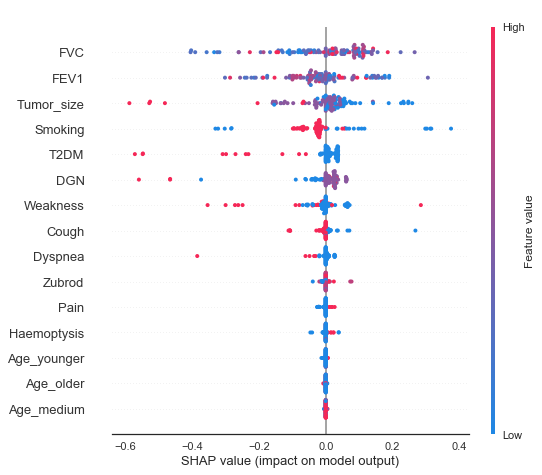

In [623]:
shap.summary_plot(shap_values[0], XabnoMPDA_test)

In [627]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

perm = PermutationImportance(dtabnoMPDAs).fit(XabnoMPDA_test, yagebin1_test)
eli5.show_weights(perm)



In [635]:
eli5.sklearn.explain_decision_tree(dtabnoMPDAs, target_names = ['0', '1'], 
                                   feature_names = ['DGN', 'FVC', 'FEV1', 'Zubrod', 'Pain', 'Haemoptysis', 'Dyspnea',
                                                    'Cough', 'Weakness', 'Tumor_size', 'T2DM', 'Smoking',
                                                    'Age_younger', 'Age_medium', 'Age_older'])

Explanation(estimator="DecisionTreeClassifier(class_weight='balanced', criterion='gini',\n            max_depth=None, max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=None,\n            splitter='best')", description='\nDecision tree feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='decision tree', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='FVC', weight=0.2885052192688875, std=None, value=None), FeatureWeight(feature='FEV1', weight=0.27977131118440135, std=None, value=None), FeatureWeight(feature='Tumor_size', weight=0.12019638212851713, std=None, value=None), FeatureWeight(feature='DGN', weight=0.066138058716484802, std=None, value=None), FeatureWeight(feature='Weakness', weight=0.059115387138489843, std=None, value=None), FeatureWeight(feature='Smoking', weight=0.050666863665935154, std=None, value=None), FeatureWeight(feature='Zubrod', weight=0.039730066935726477, std=None, value=None), FeatureWeight(feature='Dyspnea', weight=0.033865136711650659, std=None, value=None), FeatureWeight(feature='T2DM', weight=0.025434749792189109, std=None, value=None), FeatureWeight(feature='Haemoptysis', weight=0.0189631133646684, std=None, value=None), FeatureWeight(feature='Pain', weight=0.011738514633856504, std=None, value=None), FeatureWeight(feature='Cough', weight=0.0051130311279441636, std=None, value=None), FeatureWeight(feature='Age_younger', weight=0.00076216533124882468, std=None, value=None), FeatureWeight(feature='Age_older', weight=0.0, std=None, value=None), FeatureWeight(feature='Age_medium', weight=0.0, std=None, value=None)], remaining=0), decision_tree=TreeInfo(criterion='gini', tree=NodeInfo(id=0, is_leaf=False, value=[169.99999999999895, 170.00000000000011], value_ratio=[0.49999999999999822, 0.50000000000000167], impurity=0.49999999999999922, samples=340, sample_ratio=1.0, feature_name='DGN', feature_id=0, threshold=4.5, left=NodeInfo(id=1, is_leaf=False, value=[164.68749999999901, 147.1153846153847], value_ratio=[0.52817824377457234, 0.47182175622542755], impurity=0.49841197315556074, samples=324, sample_ratio=0.95294117647058818, feature_name='Smoking', feature_id=11, threshold=0.5, left=NodeInfo(id=2, is_leaf=False, value=[29.513888888888918, 6.5384615384615383], value_ratio=[0.81863979848866519, 0.18136020151133486], impurity=0.29693735763820572, samples=52, sample_ratio=0.15294117647058825, feature_name='Tumor_size', feature_id=9, threshold=12.5, left=NodeInfo(id=3, is_leaf=True, value=[29.513888888888918, 0.0], value_ratio=[1.0, 0.0], impurity=0.0, samples=50, sample_ratio=0.14705882352941177, feature_name=None, feature_id=None, threshold=None, left=None, right=None), right=NodeInfo(id=4, is_leaf=True, value=[0.0, 6.5384615384615383], value_ratio=[0.0, 1.0], impurity=-4.4408920985006262e-16, samples=2, sample_ratio=0.0058823529411764705, feature_name=None, feature_id=None, threshold=None, left=None, right=None)), right=NodeInfo(id=5, is_leaf=False, value=[135.17361111111043, 140.57692307692315], value_ratio=[0.49020253581425838, 0.50979746418574146], impurity=0.49980801939105757, samples=272, sample_ratio=0.80000000000000004, feature_name='FEV1', feature_id=2, threshold=3.809999942779541, left=NodeInfo(id=6, is_leaf=False, value=[123.95833333333276, 140.57692307692315], value_ratio=[0.46858908341915423, 0.53141091658084583], impurity=0.49802670863910059, samples=253, sample_ratio=0.74411764705882355, feature_name='Tumor_size', feature_id=9, threshold=13.5, left=NodeInfo(id=7, is_leaf=False, value=[120.41666666666613, 124.23076923076928], value_ratio=[0.49220489977728166, 0.50779510022271834], impurity=0.49987847282503395, samples=242, sample_ratio=0.71176470588235297, feature_name='T2DM', feature_id=10, threshold=0.5, left

#### Both age and DGN as dummies

In [284]:
thoracic_dgnage_df = thoracic_agebin_df_dum.copy(deep=True)
thoracic_dgnage_df['DGN'] = 'dgn' + thoracic_dgnage_df['DGN'].astype(str)
thoracic_dgnage_df.head()

DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0  dgn2  2.88  2.16       1     0            0        0      1         1   
1  dgn3  3.40  1.88       0     0            0        0      0         0   
2  dgn3  2.76  2.08       1     0            0        0      1         0   
3  dgn3  3.68  3.04       0     0            0        0      0         0   
4  dgn3  2.44  0.96       2     0            1        0      1         1   

   Tumor_size  T2DM  MI  PAD  Smoking  Asthma  Risk1Y  Age_younger  \
0          14     0   0    0        1       0       0            0   
1          12     0   0    0        1       0       0            1   
2          11     0   0    0        1       0       0            0   
3          11     0   0    0        0       0       0            0   
4          11     0   0    0        1       0       1            0   

   Age_medium  Age_older  
0           1          0  
1           0          0  
2           1          0  
3           1          0  
4           0          1

In [648]:
thoracic_agebin_df_dum.head()

DGN   FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0    2  2.88  2.16       1     0            0        0      1         1   
1    3  3.40  1.88       0     0            0        0      0         0   
2    3  2.76  2.08       1     0            0        0      1         0   
3    3  3.68  3.04       0     0            0        0      0         0   
4    3  2.44  0.96       2     0            1        0      1         1   

   Tumor_size  T2DM  MI  PAD  Smoking  Asthma  Risk1Y  Age_younger  \
0          14     0   0    0        1       0       0            0   
1          12     0   0    0        1       0       0            1   
2          11     0   0    0        1       0       0            0   
3          11     0   0    0        0       0       0            0   
4          11     0   0    0        1       0       1            0   

   Age_medium  Age_older  
0           1          0  
1           0          0  
2           1          0  
3           1          0  
4           0          1

In [285]:
thoracic_dgnage_df_dum = pd.get_dummies(thoracic_dgnage_df)
print(thoracic_dgnage_df_dum.head())

    FVC  FEV1  Zubrod  Pain  Haemoptysis  Dyspnea  Cough  Weakness  \
0  2.88  2.16       1     0            0        0      1         1   
1  3.40  1.88       0     0            0        0      0         0   
2  2.76  2.08       1     0            0        0      1         0   
3  3.68  3.04       0     0            0        0      0         0   
4  2.44  0.96       2     0            1        0      1         1   

   Tumor_size  T2DM    ...     Age_younger  Age_medium  Age_older  DGN_dgn1  \
0          14     0    ...               0           1          0         0   
1          12     0    ...               1           0          0         0   
2          11     0    ...               0           1          0         0   
3          11     0    ...               0           1          0         0   
4          11     0    ...               0           0          1         0   

   DGN_dgn2  DGN_dgn3  DGN_dgn4  DGN_dgn5  DGN_dgn6  DGN_dgn8  
0         1         0         0         

In [286]:
Xdgnage = thoracic_dgnage_df_dum.drop('Risk1Y', axis = 1)
ydgnage = thoracic_dgnage_df_dum.Risk1Y

Xdgnage_train, Xdgnage_test, ydgnage_train, ydgnage_test, sw29_train, sw29_test = train_test_split(Xdgnage, ydgnage, sw, random_state=100, stratify=y)



AU-ROC score for uncalibrated Decision Tree model: 0.7617


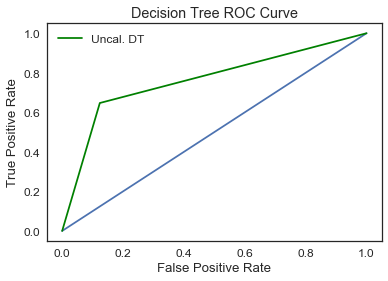

In [287]:
# DT with no calibration
dtdgnage = DecisionTreeClassifier(class_weight='balanced')
dtdgnage.fit(Xdgnage_train, ydgnage_train)  
prob_pos_dtdgnage1 = dtdgnage.predict_proba(Xdgnage_test)[:, 1]
print('AU-ROC score for uncalibrated Decision Tree model:', round(roc_auc_score(ydgnage_test, prob_pos_dtdgnage1),4))

fpr1, tpr1, thresholds1 = roc_curve(ydgnage_test, prob_pos_dtdgnage1)
plt.plot([0,1],[0,1])
plt.plot(fpr1,tpr1, label='Uncal. DT', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Decision Tree ROC Curve')

plt.legend()
plt.show()

In [288]:
dtdgnage_pred = dtdgnage.predict(Xdgnage_test)
print(classification_report(ydgnage_test,dtdgnage_pred))
print(confusion_matrix(ydgnage_test, dtdgnage_pred))

             precision    recall  f1-score   support

          0       0.93      0.88      0.90        97
          1       0.48      0.65      0.55        17

avg / total       0.87      0.84      0.85       114

[[85 12]
 [ 6 11]]
